
# Library


In [1]:
import numpy as np
import pandas as pd

from scipy import ndimage

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
from matplotlib.pyplot import imsave

import torch
from IPython.display import clear_output
import os, subprocess, textwrap
from pathlib import Path
from tqdm import tqdm

from statistics import mode

import json
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from google.colab import drive
import matplotlib
import skimage as ski
import seaborn as sns
drive.mount('/content/gdrive')
path="/content/gdrive/MyDrive/these/"


Mounted at /content/gdrive


In [2]:
DONE_ASCII = r"""
 ____   ___  _   _  _____
|  _ \ / _ \| \ | || ____|
| | | | | | |  \| ||  _|
| |_| | |_| | |\  || |___
|____/ \___/|_| \_||_____|
"""



In [3]:
def normalize(img):
  img=(img-np.min(img))/(np.max(img)-np.min(img))
  return img
def normalize_255(img):
  img=((img-np.min(img))/(np.max(img)-np.min(img)))*255
  return img


# Create the folders

In [18]:
import os
path = "/content/gdrive/MyDrive"
bool_exist=False
while bool_exist==False:
 name_path = input("Enter the path where the project will be created (if the folder is in 'MyDrive' just write the name of the project): ")
 path += "/"+name_path + "/"
 bool_exist=os.path.isdir(path)
 if bool_exist==False:
   print("❌ The path does not exist")
 else:
  print("✅ Project :"+path)
  bool_exist=True

path_img_raw=path+"images/raw/"
if os.path.isdir(path_img_raw)==False:
   print("❌ You have not completed the first step of creating PNG images")
else:
 path_img_segmentation=path+"images/images_segmentation/"
 if os.path.isdir(path_img_segmentation)==False:
   os.mkdir(path_img_segmentation)
   print("✅ Folder for images_segmentation created")
 path_segmentation=path+"segmentation/"
 if os.path.isdir(path_segmentation)==False:
     os.mkdir(path_segmentation)
     print("✅ Folder for segmentation created")
 path_segmentation_cells=path_segmentation+"segmentation_cells/"
 if os.path.isdir(path_segmentation_cells)==False:
     os.mkdir(path_segmentation_cells)
     print("✅ Folder for segmentation_cells created")
 path_segmentation_cells_mask=path_segmentation_cells+"mask/"
 if os.path.isdir(path_segmentation_cells_mask)==False:
     os.mkdir(path_segmentation_cells_mask)
 path_segmentation_cells_mask_color=path_segmentation_cells+"mask_color/"
 if os.path.isdir(path_segmentation_cells_mask_color)==False:
     os.mkdir(path_segmentation_cells_mask_color)
     print("✅ Folder for colored masks created")

Enter the path where the project will be created (if the folder is in 'MyDrive' just write the name of the project): these/pipeline/VAA
✅ Project :/content/gdrive/MyDrive/these/pipeline/VAA/
✅ Folder for images_segmentation created
✅ Folder for segmentation created
✅ Folder for segmentation_cells created
✅ Folder for colored masks created


# images for segmentation

## Functions

In [19]:
def normalize(img):
  img=(img-np.min(img))/(np.max(img)-np.min(img))
  return img
def normalize_255(img):
  img=((img-np.min(img))/(np.max(img)-np.min(img)))*255
  return img

## Execution

#### Image used for the segmentation by Mesmer and Cellpose
Images in 2 dimensions: the first one with the nucleus marker and the second one with the sum of the choosen membrane markers

In [20]:
user_input = input("enter the markers separated by commas that you want to display in the images used for cell segmentation: ")
list_marker = [word.strip() for word in user_input.split(",") if word.strip()]
print("List of markers in the images used for cell segmentation  :", list_marker)


enter the markers separated by commas that you want to display in the images used for cell segmentation: CD4,CD8a,CD20,CD68
List of markers in the images used for cell segmentation  : ['CD4', 'CD8a', 'CD20', 'CD68']


In [21]:
list_img=os.listdir(path_img_raw)
for num,roi in enumerate(list_img):
  clear_output(wait=True)
  print("|" * (num + 1) + "." * (len(list_img) - (num + 1)) + f" {round((num + 1) / len(list_img) * 100)}%")
  print(roi)
  img=Image.open(path_img_raw+roi+"/DNA.tiff")
  img_tot=np.zeros((img.size[1],img.size[0],3))
  img_tot[:,:,0]+=normalize(img)
  for marker in list_marker:
    img_tot[:,:,1]+=normalize(np.array(Image.open(path_img_raw+roi+"/"+marker+".tiff")))
  img_tot[:,:,1]=normalize(img_tot[:,:,1])
  img_tot = normalize_255(img_tot).astype(np.uint8)
  im = Image.fromarray(img_tot)
  im.save(path_img_segmentation+roi+".tiff")
print("✅ Images created for cell segmentation ready :"+path_img_segmentation)


|||||||||||||||||||| 100%
19U07351bb
✅ Images created for cell segmentation ready :/content/gdrive/MyDrive/these/pipeline/VAA/images/images_segmentation/


#### Image used for the segmentation by Instanseg
The images have as many dimensions as the number of markers chosen by the user

In [22]:
path_img_segmentation_instanseg=path+"images/images_segmentation_instanseg/"
if os.path.isdir(path_img_segmentation_instanseg)==False:
  os.mkdir(path_img_segmentation_instanseg)

In [23]:
list_marker=input("Enter a list of markers (separated with a commma) you want to display: ").split(',')

Enter a list of markers (separated with a commma) you want to display: CD4,CD8a,CD20,CD68


In [24]:
# ------------------------------------------------------------------
# 1) Installation (if needed)
# ------------------------------------------------------------------
!pip install -q tifffile
import tifffile as tiff

# ------------------------------------------------------------------
# 2) Parameters to adjust
# ------------------------------------------------------------------

extensions = (".tif", ".tiff", ".png")

# List of markers to keep (without extension)
# Example:
# list_marker = ["CD3", "CD4", "DNA1", "Keratin", ...]

# ------------------------------------------------------------------
# 3) Loop over ROI folders
# ------------------------------------------------------------------
for roi in os.listdir(path_img_raw):

    input_dir = Path(path_img_raw) / roi

    # List only files with allowed extensions
    files = [f for f in input_dir.iterdir() if f.suffix.lower() in extensions]

    # Filter files according to list_marker
    files = [f for f in files if f.stem in list_marker]

    # Sort alphabetically (ensures consistent channel order)
    files = sorted(files)

    print(f"\n=== ROI: {roi} ===")
    print("Files found (after filtering):")
    for f in files:
        print(" -", f.name)

    if not files:
        print(f"⚠️ No valid marker file found in {roi}. Skipping.")
        continue

    # ------------------------------------------------------------------
    # 4) Load images and stack channels
    # ------------------------------------------------------------------
    channels = []
    channel_names = []

    for f in files:
        if f.suffix.lower() == ".png":
            img = np.array(Image.open(str(f)))
        elif f.suffix.lower() in (".tif", ".tiff"):
            img = tiff.imread(str(f))
        else:
            raise ValueError(f"Unsupported file format for {f.name}")

        if img.ndim != 2:
            raise RuntimeError(
                f"Image {f.name} is not 2D (ndim={img.ndim}); "
                "expected a single-channel image."
            )

        channels.append(img)
        channel_names.append(f.stem)

    # Ensure all images have the same shape
    shapes = {c.shape for c in channels}
    if len(shapes) != 1:
        raise RuntimeError(f"Not all images have identical size: {shapes}")

    # Stack into (C, H, W)
    multiplex = np.stack(channels, axis=0)
    print("Final shape (C, H, W):", multiplex.shape)

    # ------------------------------------------------------------------
    # 5) Save multi-channel TIFF
    # ------------------------------------------------------------------
    if multiplex.dtype == np.float64:
        multiplex = multiplex.astype(np.float32)

    output_path = Path(path_img_segmentation_instanseg) / f"{roi}.tif"

    tiff.imwrite(
        str(output_path),
        multiplex,
        photometric="minisblack",
        metadata={
            "axes": "CYX",
            "Channel": {"Name": channel_names},
        },
    )

    print("✅ Multiplex image created:", output_path)
    print("Channels in order:")
    for i, name in enumerate(channel_names):
        print(f"  C{i}: {name}")



=== ROI: 19U07351a ===
Files found (after filtering):
 - CD20.tiff
 - CD4.tiff
 - CD68.tiff
 - CD8a.tiff
Final shape (C, H, W): (4, 1000, 588)
✅ Multiplex image created: /content/gdrive/MyDrive/these/pipeline/VAA/images/images_segmentation_instanseg/19U07351a.tif
Channels in order:
  C0: CD20
  C1: CD4
  C2: CD68
  C3: CD8a

=== ROI: 19U07351c ===
Files found (after filtering):
 - CD20.tiff
 - CD4.tiff
 - CD68.tiff
 - CD8a.tiff
Final shape (C, H, W): (4, 1010, 636)
✅ Multiplex image created: /content/gdrive/MyDrive/these/pipeline/VAA/images/images_segmentation_instanseg/19U07351c.tif
Channels in order:
  C0: CD20
  C1: CD4
  C2: CD68
  C3: CD8a

=== ROI: 19U07351d ===
Files found (after filtering):
 - CD20.tiff
 - CD4.tiff
 - CD68.tiff
 - CD8a.tiff
Final shape (C, H, W): (4, 1292, 424)
✅ Multiplex image created: /content/gdrive/MyDrive/these/pipeline/VAA/images/images_segmentation_instanseg/19U07351d.tif
Channels in order:
  C0: CD20
  C1: CD4
  C2: CD68
  C3: CD8a

=== ROI: 19U07351e

# Segmentation of all the images

## Segmentation of all the images



### Segmentation by mesmer

In [25]:
 path_mask_mesmer=path_segmentation_cells_mask+"mesmer/"
 if os.path.isdir(path_mask_mesmer)==False:
    os.mkdir(path_mask_mesmer)
    print("✅ Folder for mesmer masks created")
 else:
    print("✅ Folder for mesmer masks already created")
 path_mask_color_mesmer=path_segmentation_cells_mask_color+"mesmer/"
 if os.path.isdir(path_mask_color_mesmer)==False:
    os.mkdir(path_mask_color_mesmer)
    print("✅ Folder for color mesmer masks created")
 else:
    print("✅ Folder for color mesmer masks already created")

✅ Folder for mesmer masks created
✅ Folder for color mesmer masks created


#### Segmentation

##### Functions

In [13]:
# Étape 1 : Installer micromamba (mini version d'Anaconda compatible Colab)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
!mkdir -p /root/micromamba/envs

# Étape 2 : Créer un environnement Python 3.9 avec micromamba
!./bin/micromamba create -y -p /root/micromamba/envs/deepcell-env python=3.9

# Étape 3 : Activer l'environnement et installer DeepCell + dépendances
!./bin/micromamba run -p /root/micromamba/envs/deepcell-env pip install deepcell==0.12.6 scikit-image matplotlib

# Étape 4 : Démarrer Python dans ce nouvel environnement
import os
from IPython.display import clear_output

os.environ['PYTHONPATH'] = "/root/micromamba/envs/deepcell-env/lib/python3.9/site-packages"
os.environ['PATH'] = "/root/micromamba/envs/deepcell-env/bin:" + os.environ['PATH']
clear_output()
print("✅ Environnement Python 3.9 avec DeepCell prêt dans Colab")


✅ Environnement Python 3.9 avec DeepCell prêt dans Colab


##### Execution

In [26]:
resolution=float(input("Enter the resolution in micrometer per pixel (depending on the size of the biopsie, 1.5 mpp by default):"))

Enter the resolution in micrometer per pixel (depending on the size of the biopsie, 1.5 mpp by default):1.5


In [27]:
code = f"""
from deepcell.applications import Mesmer
from tifffile import imsave
from PIL import Image
import numpy as np
import os
import traceback

project = "rejection"
path = "{path}"
path_img = "{path_img_segmentation}"
path_mask_mesmer = "{path_mask_mesmer}"

# Vérifie que les dossiers existent
if not os.path.isdir(path_img):
    raise FileNotFoundError(f"📁 Dossier d'images introuvable : {{path_img}}")
if not os.path.isdir(path_mask_mesmer):
    os.makedirs(path_mask_mesmer)
    print(f"📂 Dossier créé : {{path_mask_mesmer}}")

# Charger le modèle
try:
    app = Mesmer()
    print("🧠 Modèle Mesmer chargé avec succès.")
except Exception as e:
    raise RuntimeError("❌ Échec du chargement de Mesmer : " + str(e))

# Traiter les images
for img_file in os.listdir(path_img):
    try:
        if not img_file.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff")):
            continue

        output_file = os.path.join(path_mask_mesmer, img_file.rsplit(".", 1)[0] + ".tif")
        if os.path.isfile(output_file):
            print(f"⏭️ Déjà traité : {{img_file}}")
            continue

        img_path = os.path.join(path_img, img_file)
        img = np.array(Image.open(img_path))

        # Utiliser uniquement les deux premiers canaux
        img = img[:, :, :2] if img.ndim == 3 and img.shape[2] >= 2 else np.stack([img] * 2, axis=-1)
        img = np.expand_dims(img, axis=0)

        predictions = app.predict(img, image_mpp={resolution})
        mask = predictions[0, :, :, 0].astype(np.uint16)

        imsave(output_file, mask)
        print("✅ Traitée :", img_file)

    except Exception as e:
        print(f"❌ Erreur avec {{img_file}} : {{e}}")
        traceback.print_exc()
    print("✅ Folder for color mesmer masks available there: output_file")

"""


In [ ]:
with open("run_mesmer.py", "w") as f:
    f.write(code)

# Exécution
!./bin/micromamba run -p /root/micromamba/envs/deepcell-env python run_mesmer.py


2025-12-10 18:39:44.688064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/micromamba/envs/deepcell-env/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/lib/python3.12/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-12-10 18:39:44.688144: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-12-10 18:39:51.452790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/micromamba/envs/deepcell-env/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/lib/python3.12/dist-packages/cv2/../../lib64:/usr/local/nvidia/lib:/usr/local/nvidia/

#### Colored masks

In [ ]:

rgb_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
rgb_colors = [mcolors.to_rgb(c) for c in rgb_colors]

def random_color():
    return rgb_colors[np.random.randint(0, len(rgb_colors))]

for file_img in os.listdir(path_mask_mesmer):

    print(file_img)

    mask = np.array(Image.open(os.path.join(path_mask_mesmer, file_img)))
    label=ski.measure.label(mask,connectivity=mask.ndim)
    df_mask=ski.measure.regionprops_table(label,intensity_image=mask,properties=["area","coords","equivalent_diameter_area","bbox","axis_major_length","axis_minor_length","centroid"])
    df_mask=pd.DataFrame(df_mask)

    crop_iou = np.zeros((*mask.shape, 3), dtype=np.float32)

    obj_colors = [random_color() for _ in range(len(df_mask))]

    for i, coords in enumerate(df_mask["coords"]):
        coord_array = np.array(coords)
        crop_iou[coord_array[:, 0], coord_array[:, 1]] = obj_colors[i]

    imsave(os.path.join(path_mask_color_mesmer, file_img[:-5] + ".png"),crop_iou)
    plt.close()
print("✅ Folder with color mesmer masks available there: "+ path_mask_color_mesmer)


### Cellpose v3
It's necessary to restart the runtime after the mesmer segmentation

In [ ]:
 path_mask_cellposev3=path_segmentation_cells_mask+"cellposev3/"
 if os.path.isdir(path_mask_cellposev3)==False:
    os.mkdir(path_mask_cellposev3)
    print("✅ Folder for cellpose v3 mask created")
 path_mask_color_cellposev3=path_segmentation_cells_mask_color+"cellposev3/"
 if os.path.isdir(path_mask_color_cellposev3)==False:
    os.mkdir(path_mask_color_cellposev3)
    print("✅ Folder for color cellpose v3 masks created")

✅ Folder for cellpose v3 mask created


#### Installation of cellpose

In [ ]:
%pip install cellpose
from cellpose import core, utils, io, models, metrics
model = models.CellposeModel(gpu=True, model_type="cyto3")


  Using cached cellpose-4.0.8-py3-none-any.whl.metadata (22 kB)
  Using cached segment_anything-1.0-py3-none-any.whl.metadata (487 bytes)
Using cached cellpose-4.0.8-py3-none-any.whl (212 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 115.9 MB/s eta 0:00:00
Using cached segment_anything-1.0-py3-none-any.whl (36 kB)


100%|██████████| 1.15G/1.15G [00:02<00:00, 467MB/s]


#### Segmentation

In [ ]:
list_img= os.listdir(path_img_segmentation)
for num,img_file in enumerate(list_img):
    clear_output(wait=True)
    print("|"*(num+1)+"."*(len(list_img)-(num+1))+" "+str(round((num+1)/len(list_img)*100))+"%")
    print(img_file)
    img= np.array(Image.open(path_img_segmentation+"/"+img_file))
    masks_pred, flows, styles = model.eval(img, diameter=None, channels=[2,1],niter=2000) # using more iterations for bacteria
    im = Image.fromarray(masks_pred)
    im.save(path_mask_cellposev3+"/"+img_file[:-5]+".tif")
    print(img_file+": "+str(len(np.unique(masks_pred)))+" objects")
    print("✅ Mask available here:"+path_mask_cellposev3)



||||||||||||||||||||||| 100%
19U08731 g.tiff
19U08731 g.tiff: 4436 objects
✅ Mask available here:/content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/mask/cellposev3/


#### Colored masks

In [ ]:

rgb_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
rgb_colors = [mcolors.to_rgb(c) for c in rgb_colors]

def random_color():
    return rgb_colors[np.random.randint(0, len(rgb_colors))]

for file_img in os.listdir(path_mask_cellposev3):

    print(file_img)

    mask = np.array(Image.open(os.path.join(path_mask_cellposev3, file_img)))
    label=ski.measure.label(mask,connectivity=mask.ndim)
    df_mask=ski.measure.regionprops_table(label,intensity_image=mask,properties=["area","coords","equivalent_diameter_area","bbox","axis_major_length","axis_minor_length","centroid"])
    df_mask=pd.DataFrame(df_mask)

    crop_iou = np.zeros((*mask.shape, 3), dtype=np.float32)

    obj_colors = [random_color() for _ in range(len(df_mask))]

    for i, coords in enumerate(df_mask["coords"]):
        coord_array = np.array(coords)
        crop_iou[coord_array[:, 0], coord_array[:, 1]] = obj_colors[i]

    imsave(os.path.join(path_mask_color_cellposev3, file_img[:-5] + ".png"),crop_iou)
    plt.close()
print("✅ Folder with color cellposev3 masks available there: "+ path_mask_color_cellposev3)


21U01570 a.tif
21U01570 b.tif
21U02147 a.tif
21U01570 c.tif
21U01570 d.tif
21U01570 e.tif
21U01570 f.tif
21U01570 g.tif
20U03813 a.tif
20U03813 b.tif
20U03813 c.tif
21U05395 a.tif
21U05395 b.tif
20U09477 a.tif
20U09477 b.tif
20U09477 c.tif
19U08731 a.tif
19U08731 b.tif
19U08731 c.tif
19U08731 d.tif
19U08731 e.tif
19U08731 f.tif
19U08731 g.tif


### InstanSeg

In [ ]:
 path_mask_instanseg=path_segmentation_cells_mask+"instanseg/"
 path_img_segmentation_instanseg=path+"images/images_segmentation_instanseg/"
 if os.path.isdir(path_mask_instanseg)==False:
    os.mkdir(path_mask_instanseg)
    print("✅ Folder for InstanSeg mask created")
 path_mask_color_instanseg=path_segmentation_cells_mask_color+"instanseg/"
 if os.path.isdir(path_mask_color_instanseg)==False:
    os.mkdir(path_mask_color_instanseg)
    print("✅ Folder for color Instanseg masks created")

#### Installation of Instanseg

In [ ]:
# === Cellule 1 : installation de l'environnement InstanSeg ===

# 1) Installer micromamba (mini-conda)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
!mkdir -p /root/micromamba/envs

# 2) Créer un environnement Python 3.11 pour InstanSeg
!./bin/micromamba create -y -p /root/micromamba/envs/instanseg-env python=3.11

# 3) Installer InstanSeg + dépendances dans cet environnement
!./bin/micromamba run -p /root/micromamba/envs/instanseg-env pip install -q \
    "instanseg-torch[full]" "matplotlib<3.9"


bin/micromamba
[+] 0.0s
[+] 0.1s
conda-forge/linux-64   1%
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64  14%
conda-forge/noarch    20%[+] 0.3s
conda-forge/linux-64  26%
conda-forge/noarch    44%[+] 0.4s
conda-forge/linux-64  37%
conda-forge/noarch    68%[+] 0.5s
conda-forge/linux-64  50%
conda-forge/noarch    92%[+] 0.6s
conda-forge/linux-64  50%
conda-forge/noarch    92%conda-forge/noarch                                
[+] 0.7s
conda-forge/linux-64  65%[+] 0.8s
conda-forge/linux-64  89%[+] 0.9s
conda-forge/linux-64  96%[+] 1.0s
conda-forge/linux-64  96%conda-forge/linux-64                              


Transaction

  Prefix: /root/micromamba/envs/instanseg-env

  Updating specs:

   - python=3.11


  Package                Version  Build                 Channel          Size
───────────────────────────────────────────────────────────────────────────────
  Install:
───────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex           

In [ ]:
import os, subprocess, textwrap

env = os.environ.copy()
env["MPLBACKEND"] = "Agg"   # évite le backend Jupyter non supporté

code = """
import matplotlib
matplotlib.use('Agg')

import sys
print("Python utilisé :", sys.version)

from instanseg import InstanSeg
print("InstanSeg importé OK :", InstanSeg)
"""

subprocess.run(
    ["/root/micromamba/envs/instanseg-env/bin/python", "-c", code],
    check=True,
    env=env,
)


CompletedProcess(args=['/root/micromamba/envs/instanseg-env/bin/python', '-c', '\nimport matplotlib\nmatplotlib.use(\'Agg\')\n\nimport sys\nprint("Python utilisé :", sys.version)\n\nfrom instanseg import InstanSeg\nprint("InstanSeg importé OK :", InstanSeg)\n'], returncode=0)

In [ ]:
!./bin/micromamba run -p /root/micromamba/envs/instanseg-env pip install requests


#### Segmentation

In [ ]:
import os, subprocess, textwrap
from pathlib import Path

image_dir = path_img_segmentation_instanseg
output_dir = path_mask_instanseg

print("Input folder:", image_dir)
print("Output folder (masks):", output_dir)
print("-" * 70)

env = os.environ.copy()
env["MPLBACKEND"] = "Agg"

code = textwrap.dedent(f"""
import matplotlib
matplotlib.use('Agg')

from instanseg import InstanSeg
from pathlib import Path
import numpy as np
import tifffile as tiff

img_dir = Path({image_dir!r})
out_dir = Path({output_dir!r})

print("Input folder:", img_dir)
print("Output folder:", out_dir)

if not img_dir.exists():
    raise SystemExit(f"Path {{img_dir}} does not exist")

if not img_dir.is_dir():
    raise SystemExit(f"Path {{img_dir}} is not a folder")

out_dir.mkdir(parents=True, exist_ok=True)

print("Loading InstanSeg model (fluorescence_nuclei_and_cells)...")
model = InstanSeg(
    "fluorescence_nuclei_and_cells",
    image_reader="tiffslide",
    verbosity=1
)

images = sorted(list(img_dir.glob("*.tif")) + list(img_dir.glob("*.tiff")))

print("Number of images found:", len(images))
if not images:
    raise SystemExit("No .tif/.tiff images found in " + str(img_dir))

for img_path in images:
    print("\\nProcessing:", img_path.name)

    labeled_output = model.eval(
        image=str(img_path),
        save_output=False,
        save_overlay=False
    )

    mask = np.asarray(labeled_output)
    mask_path = out_dir / (img_path.stem + ".tif")

    tiff.imwrite(str(mask_path), mask)
    print("Saved mask:", mask_path)

print("Segmentation completed.")
""")

res = subprocess.run(
    ["/root/micromamba/envs/instanseg-env/bin/python", "-c", code],
    env=env,
    capture_output=True,
    text=True,
)

print("----- STDOUT -----")
print(res.stdout)
print("----- STDERR -----")
print(res.stderr)

if res.returncode != 0:
    raise RuntimeError(f"InstanSeg failed (code {res.returncode})")


Input folder: /content/gdrive/MyDrive/these/pipeline/rejection/images/images_segmentation_instanseg/
Output folder (masks): /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/mask/instanseg/
----------------------------------------------------------------------
----- STDOUT -----
Input folder: /content/gdrive/MyDrive/these/pipeline/rejection/images/images_segmentation_instanseg
Output folder: /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/mask/instanseg
Loading InstanSeg model (fluorescence_nuclei_and_cells)...
Model fluorescence_nuclei_and_cells version 0.1.0 downloaded and extracted to /root/micromamba/envs/instanseg-env/lib/python3.11/site-packages/instanseg/utils/../bioimageio_models/
Requesting default device: cuda
Number of images found: 23

Processing: 19U08731 a.tif
BioImage does not support the image: '/content/gdrive/MyDrive/these/pipeline/rejection/images/images_segmentation_instanseg/19U08731 a.tif'. You may ne

#### Colored masks

In [ ]:

rgb_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
rgb_colors = [mcolors.to_rgb(c) for c in rgb_colors]

def random_color():
    return rgb_colors[np.random.randint(0, len(rgb_colors))]

for file_img in os.listdir(path_mask_instanseg):

    print(file_img)

    mask = np.array(Image.open(os.path.join(path_mask_instanseg, file_img)))
    label=ski.measure.label(mask,connectivity=mask.ndim)
    df_mask=ski.measure.regionprops_table(label,intensity_image=mask,properties=["area","coords","equivalent_diameter_area","bbox","axis_major_length","axis_minor_length","centroid"])
    df_mask=pd.DataFrame(df_mask)

    crop_iou = np.zeros((*mask.shape, 3), dtype=np.float32)

    obj_colors = [random_color() for _ in range(len(df_mask))]

    for i, coords in enumerate(df_mask["coords"]):
        coord_array = np.array(coords)
        crop_iou[coord_array[:, 0], coord_array[:, 1]] = obj_colors[i]

    imsave(os.path.join(path_mask_color_instanseg, file_img[:-5] + ".png"),crop_iou)
    plt.close()
print("✅ Folder with color instanseg masks available there: "+ path_mask_color_instanseg)


19U08731 a.tif
19U08731 b.tif
19U08731 c.tif
19U08731 d.tif
19U08731 e.tif
19U08731 f.tif
19U08731 g.tif
20U03813 a.tif
20U03813 b.tif
20U03813 c.tif
20U09477 a.tif
20U09477 b.tif
20U09477 c.tif
21U01570 a.tif
21U01570 b.tif
21U01570 c.tif
21U01570 d.tif
21U01570 e.tif
21U01570 f.tif
21U01570 g.tif
21U02147 a.tif
21U05395 a.tif
21U05395 b.tif
✅ Folder with color instanseg masks available there: /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/mask_color/instanseg/


## Size filter
Removing too small or too big objects

In [ ]:
path_mask_filter=path_segmentation_cells+"mask_filtered/"
path_mask=path_segmentation_cells_mask
if os.path.isdir(path_mask_filter)==False:
  os.mkdir(path_mask_filter)
  print("✅ Folder for filtered masks created")
path_mask_color_filter=path_segmentation_cells+"mask_color_filtered/"
path_obj_color_filter=path_segmentation_cells+"obj_color_filtered/"
if os.path.isdir(path_mask_color_filter)==False:
  os.mkdir(path_mask_color_filter)
  print("✅ Folder for colored filtered masks created")
if os.path.isdir(path_obj_color_filter)==False:
  os.mkdir(path_obj_color_filter)
  print("✅ Folder for colored filtered objects created")

In [ ]:
min_size=int(input("Enter the minimum size of the cell you want to keep: "))
max_size=int(input("Enter the maximum size of the cell you want to keep:"))

Enter the minimum size of the cell you want to keep: 20
Enter the maximum size of the cell you want to keep:500


#### Create the mask with no object smaller than the minimum size and bigger than the maximum size

In [ ]:
# --- Parameters ---
min_size = int(min_size)
max_size = int(max_size)

in_root  = path_segmentation_cells_mask
out_root = path_mask_filter

# Create the output root folder if it doesn't exist
os.makedirs(out_root, exist_ok=True)

# List only subfolders (one per algorithm)
algos = [d for d in os.listdir(in_root) if os.path.isdir(os.path.join(in_root, d))]

# Outer progress bar: algorithms
for algo in tqdm(algos, desc="Filtering by size • algorithms", unit="alg", position=0, leave=True):
    src_dir = os.path.join(in_root, algo)
    dst_dir = os.path.join(out_root, algo)
    os.makedirs(dst_dir, exist_ok=True)

    files = sorted(os.listdir(src_dir))

    # Inner progress bar: images per algorithm
    for file_mask in tqdm(files, desc=f"{algo}", unit="img", position=1, leave=False):
        src_path = os.path.join(src_dir, file_mask)
        dst_path = os.path.join(dst_dir, file_mask)

        # Load labeled mask (background=0, objects>0)
        mask = np.array(Image.open(src_path))

        # Compute area (pixel count) for each label in a single pass
        labels, counts = np.unique(mask, return_counts=True)

        # Select labels whose area is strictly between (min_size, max_size)
        # (Use <= and >= if you want inclusive thresholds.)
        keep_labels = labels[(counts < max_size) & (counts > min_size)]

        # Vectorized filtering:
        # keep original label where it belongs to keep_labels, else set to 0
        if keep_labels.size == 0:
            mask_filtered = np.zeros_like(mask)
        else:
            mask_filtered = np.where(np.isin(mask, keep_labels), mask, 0).astype(mask.dtype)

        # Save the filtered mask (preserves integer labels)
        Image.fromarray(mask_filtered).save(dst_path)


Filtering by size • algorithms:   0%|          | 0/4 [00:00<?, ?alg/s]

mesmer:   0%|          | 0/23 [00:00<?, ?img/s]

combine_mesmer_cellposev3:   0%|          | 0/23 [00:00<?, ?img/s]

cellposev3:   0%|          | 0/23 [00:00<?, ?img/s]

instanseg:   0%|          | 0/23 [00:00<?, ?img/s]

##### Mask colored

Algorithms:   0%|          | 0/4 [00:00<?, ?alg/s]

mesmer:   0%|          | 0/23 [00:00<?, ?img/s]

Objects:   0%|          | 0/3688 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3151 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3297 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2621 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4158 [00:00<?, ?obj/s]

Objects:   0%|          | 0/5094 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4407 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3774 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3059 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2787 [00:00<?, ?obj/s]

Objects:   0%|          | 0/5048 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4651 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4626 [00:00<?, ?obj/s]

Objects:   0%|          | 0/5170 [00:00<?, ?obj/s]

Objects:   0%|          | 0/5490 [00:00<?, ?obj/s]

Objects:   0%|          | 0/7194 [00:00<?, ?obj/s]

Objects:   0%|          | 0/6748 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3178 [00:00<?, ?obj/s]

Objects:   0%|          | 0/6643 [00:00<?, ?obj/s]

Objects:   0%|          | 0/7376 [00:00<?, ?obj/s]

Objects:   0%|          | 0/5717 [00:00<?, ?obj/s]

/tmp/ipython-input-3846046006.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,10))


Objects:   0%|          | 0/3629 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3480 [00:00<?, ?obj/s]

combine_mesmer_cellposev3:   0%|          | 0/23 [00:00<?, ?img/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects:   0%|          | 0/14 [00:00<?, ?obj/s]

Objects:   0%|          | 0/348 [00:00<?, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects:   0%|          | 0/52 [00:00<?, ?obj/s]

Objects:   0%|          | 0/25 [00:00<?, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

Objects: 0obj [00:00, ?obj/s]

cellposev3:   0%|          | 0/23 [00:00<?, ?img/s]

Objects:   0%|          | 0/3547 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3085 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3106 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2457 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3938 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4854 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4327 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3516 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2923 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2516 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4672 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4323 [00:00<?, ?obj/s]

Objects:   0%|          | 0/5000 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4808 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4848 [00:00<?, ?obj/s]

Objects:   0%|          | 0/6120 [00:00<?, ?obj/s]

Objects:   0%|          | 0/5988 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2917 [00:00<?, ?obj/s]

Objects:   0%|          | 0/6605 [00:00<?, ?obj/s]

Objects:   0%|          | 0/6011 [00:00<?, ?obj/s]

Objects:   0%|          | 0/5242 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3101 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2649 [00:00<?, ?obj/s]

instanseg:   0%|          | 0/23 [00:00<?, ?img/s]

Objects:   0%|          | 0/2822 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2467 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2497 [00:00<?, ?obj/s]

Objects:   0%|          | 0/1986 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3138 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3777 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3402 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2848 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2335 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2102 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2577 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2317 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2058 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3449 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3552 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3890 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4034 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2289 [00:00<?, ?obj/s]

Objects:   0%|          | 0/4449 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3437 [00:00<?, ?obj/s]

Objects:   0%|          | 0/3893 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2546 [00:00<?, ?obj/s]

Objects:   0%|          | 0/2405 [00:00<?, ?obj/s]

✅ Folder with color masks available there: /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/mask_color_filtered/


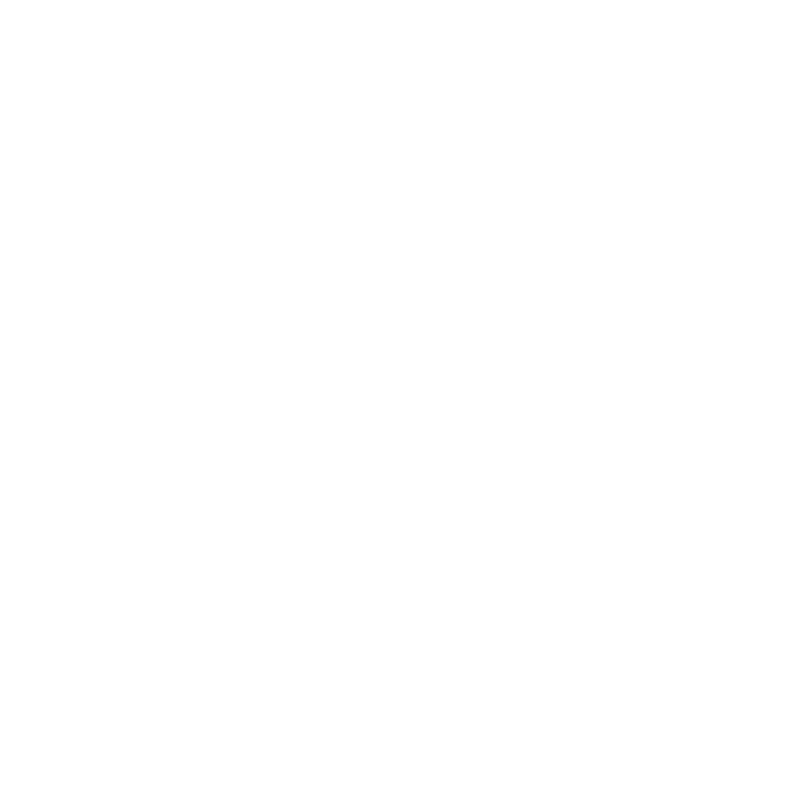

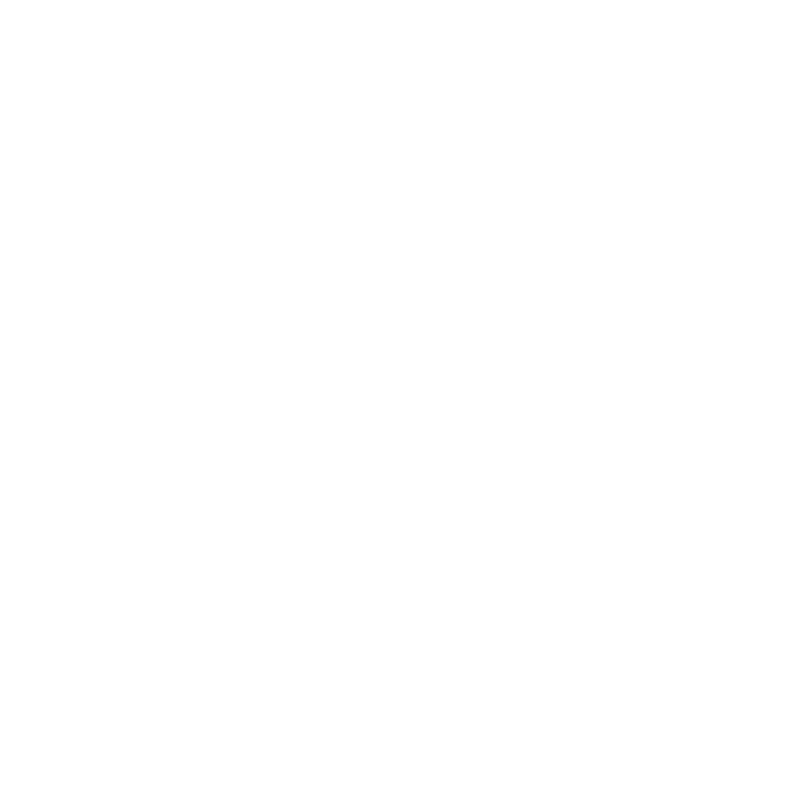

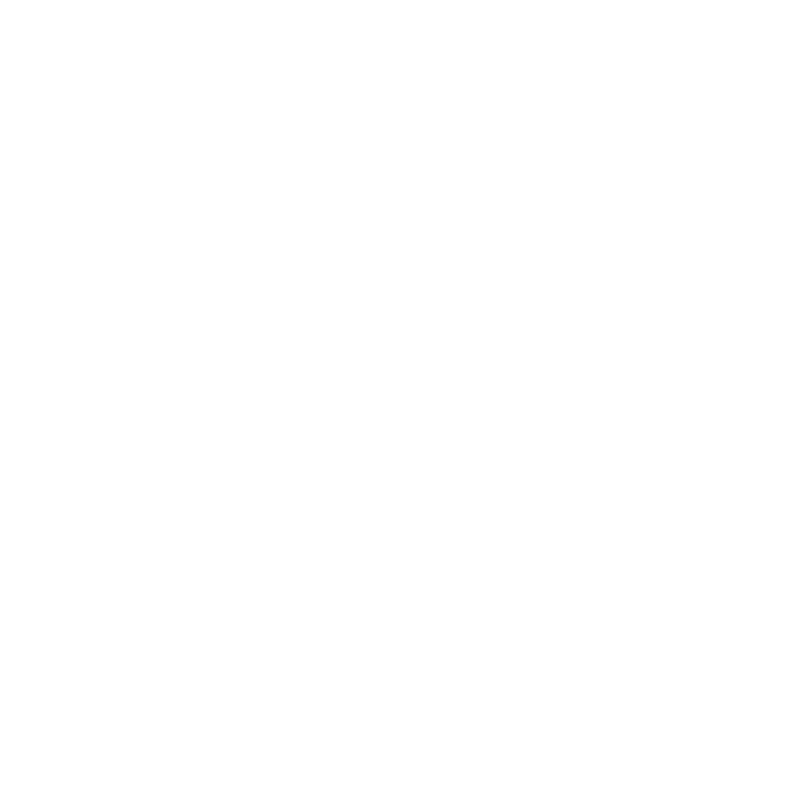

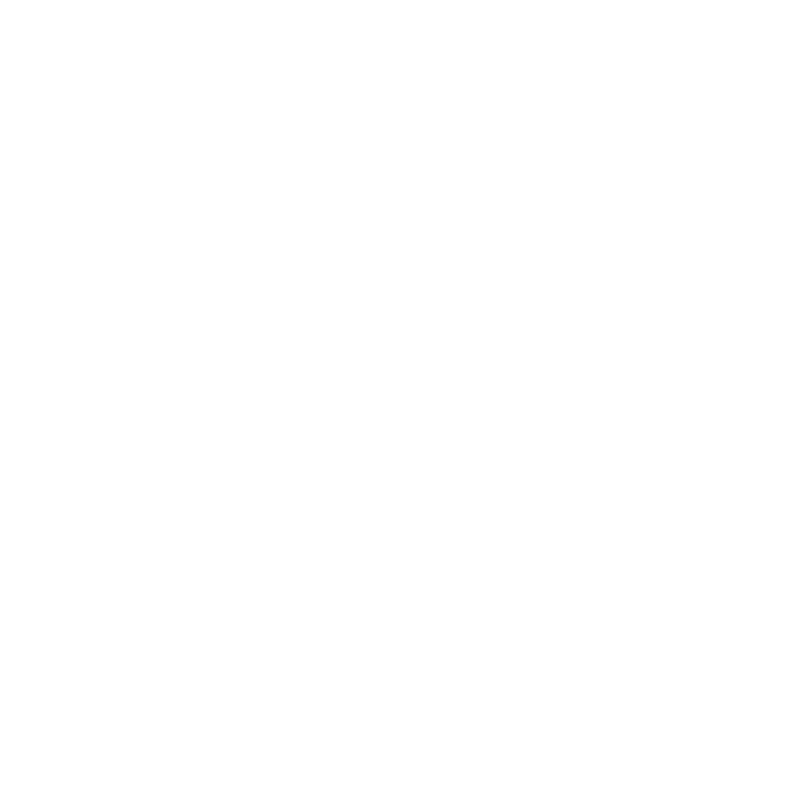

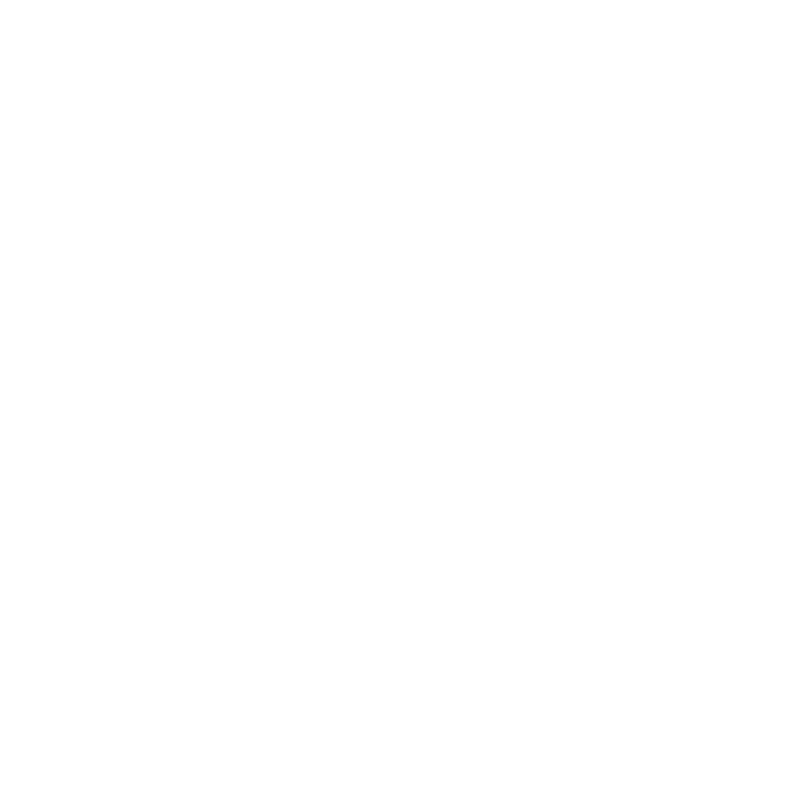

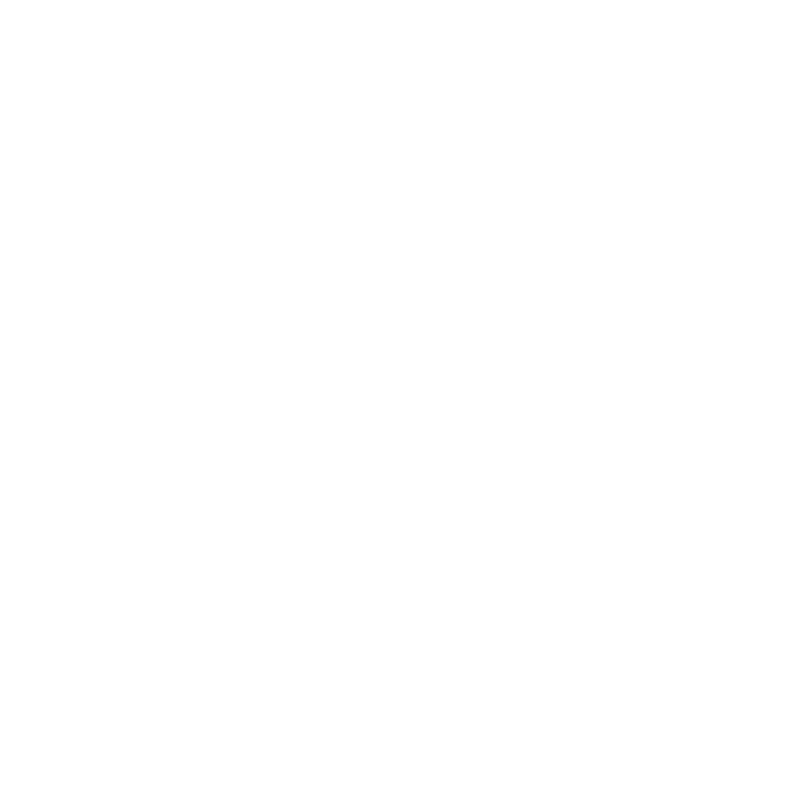

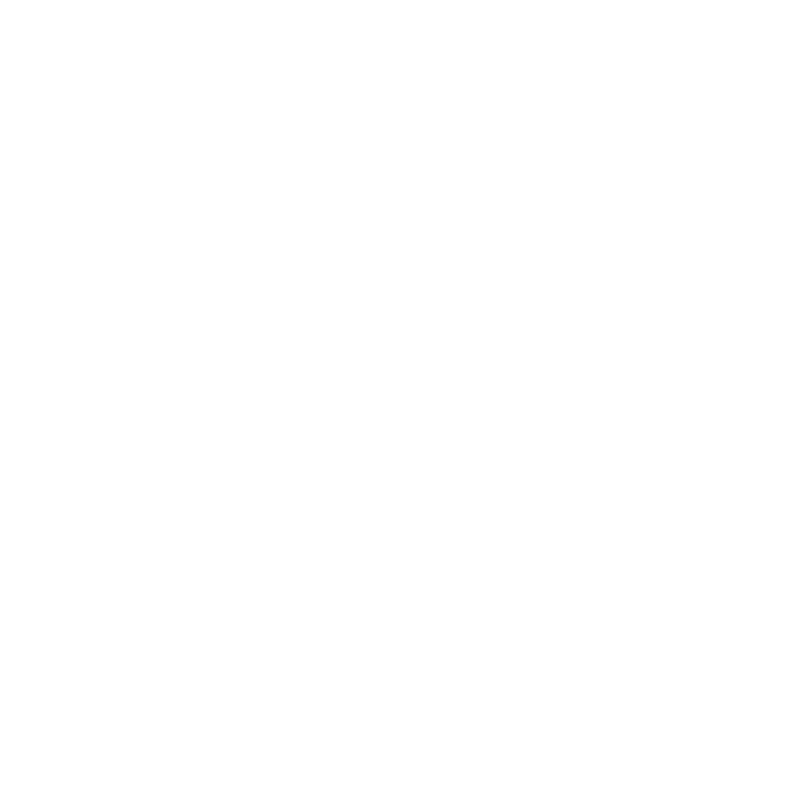

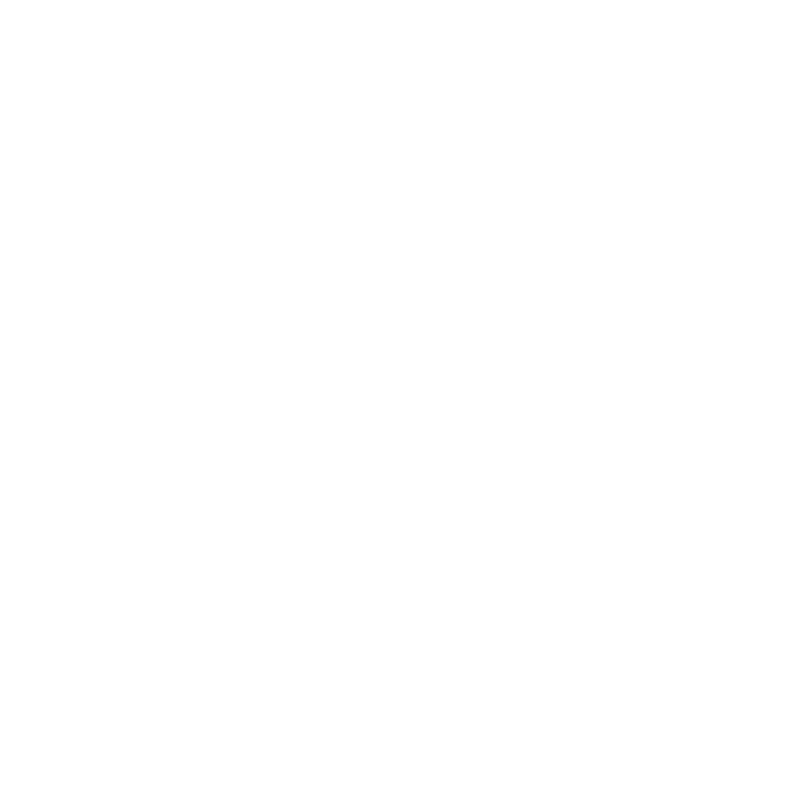

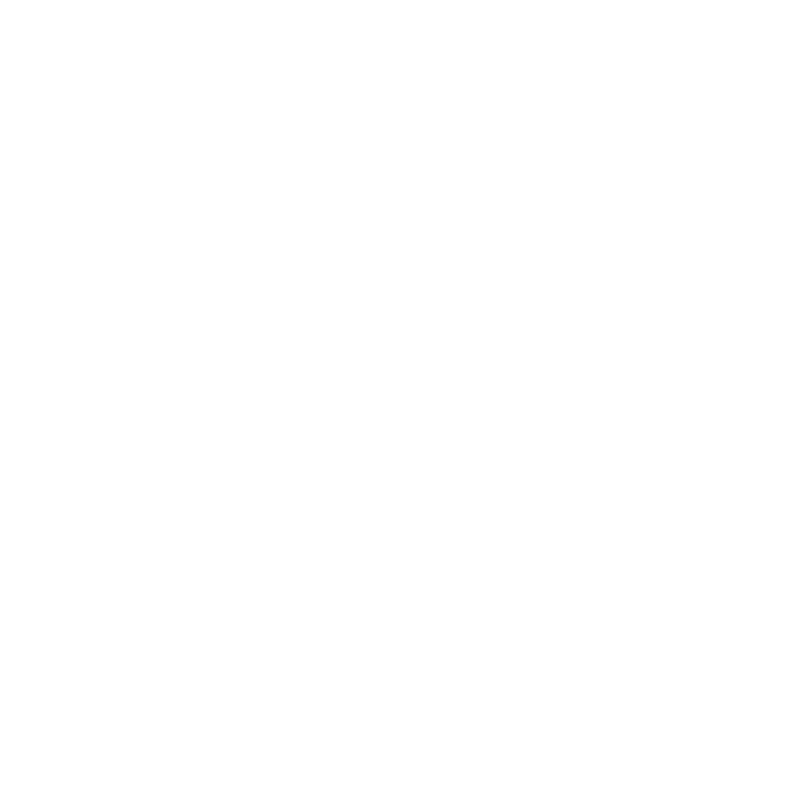

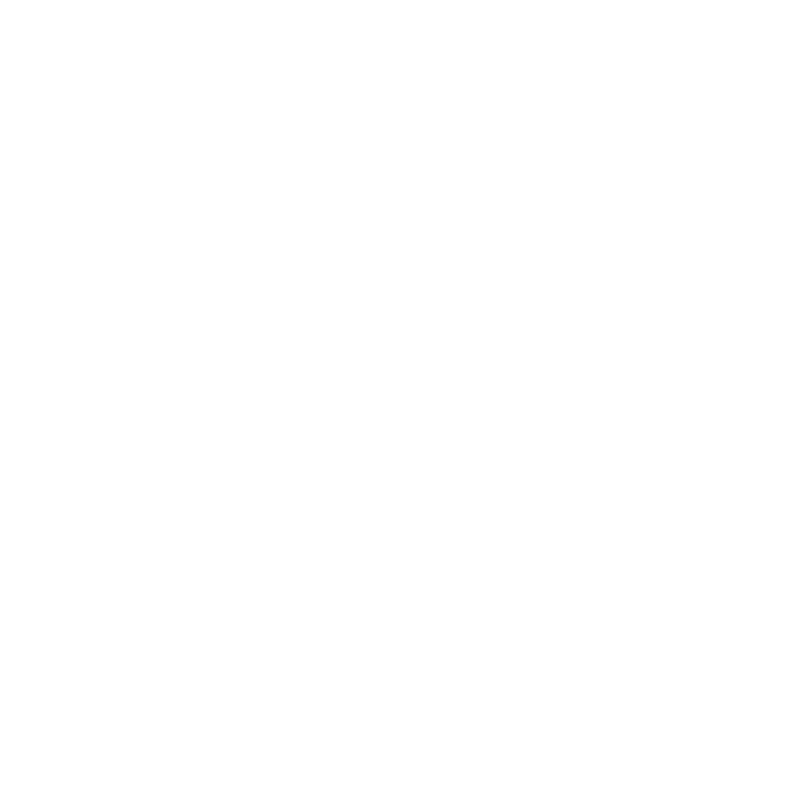

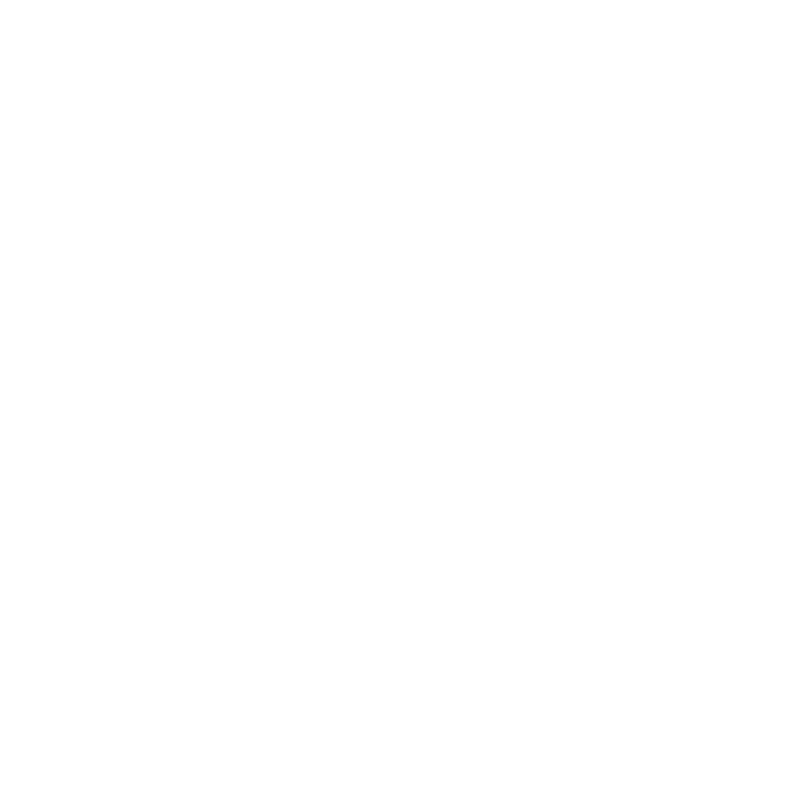

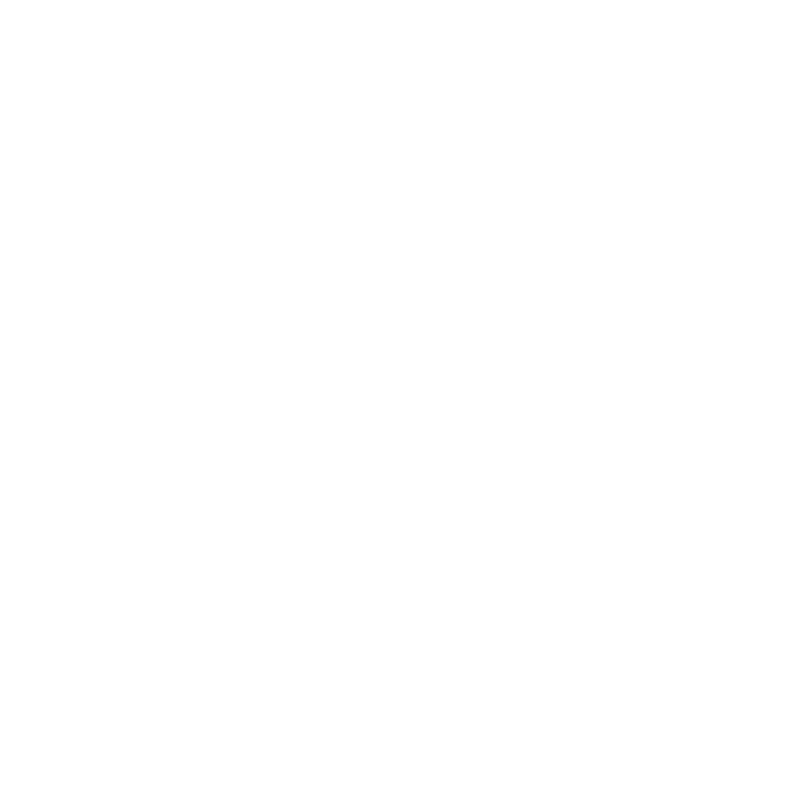

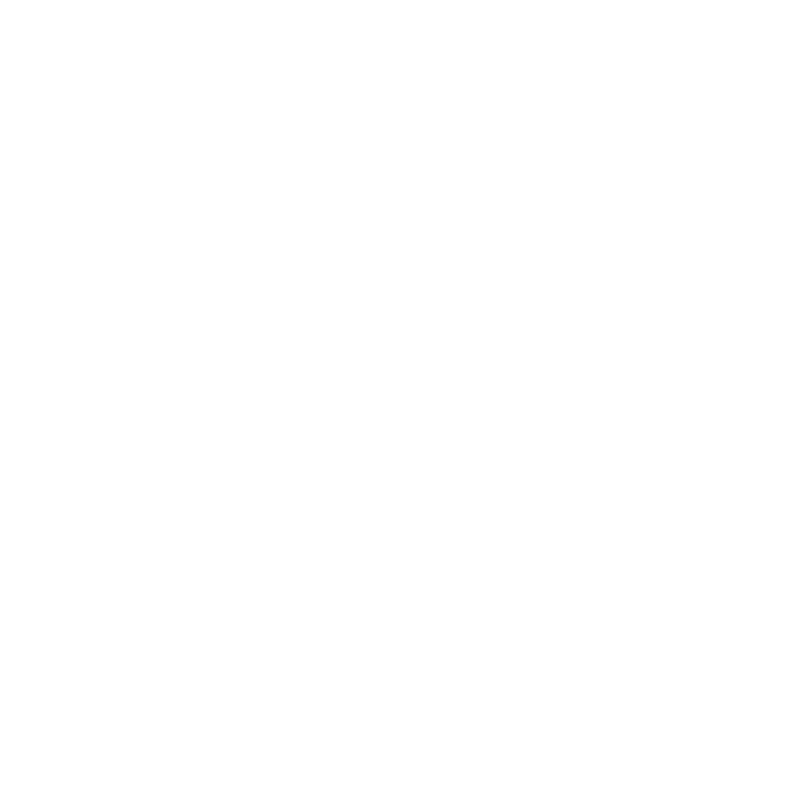

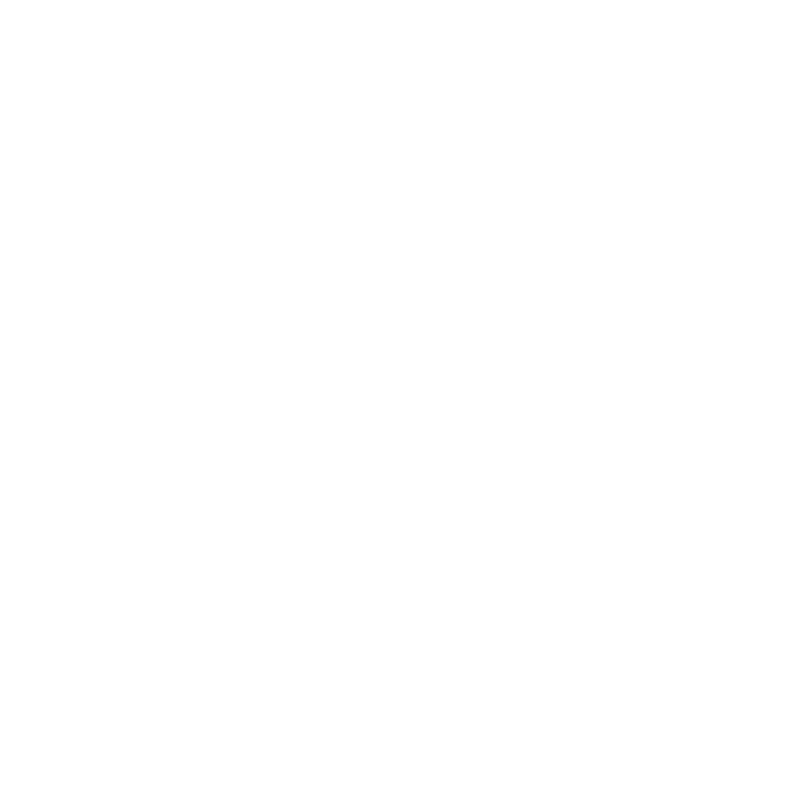

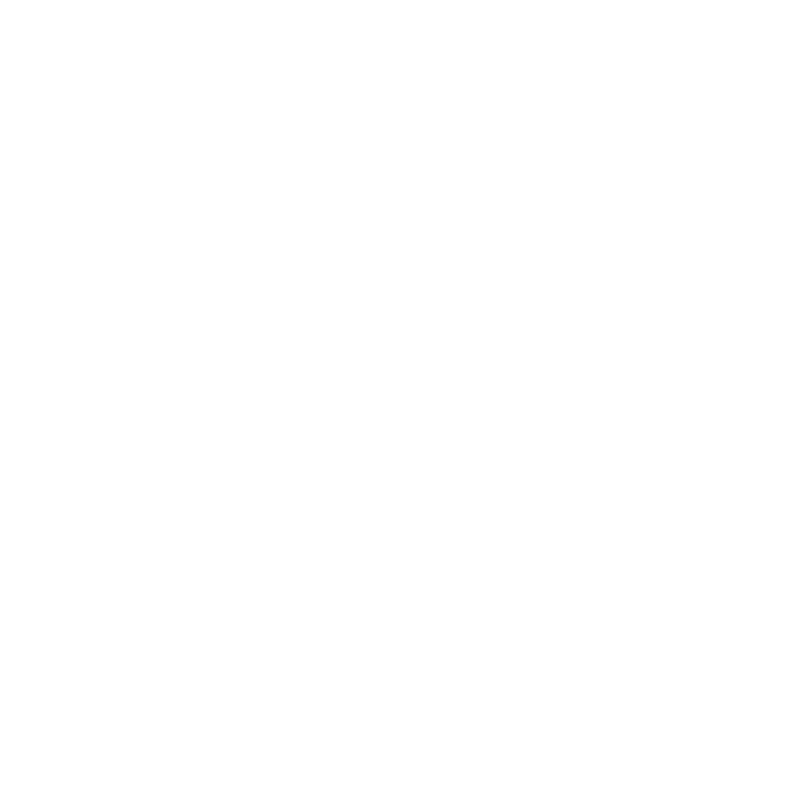

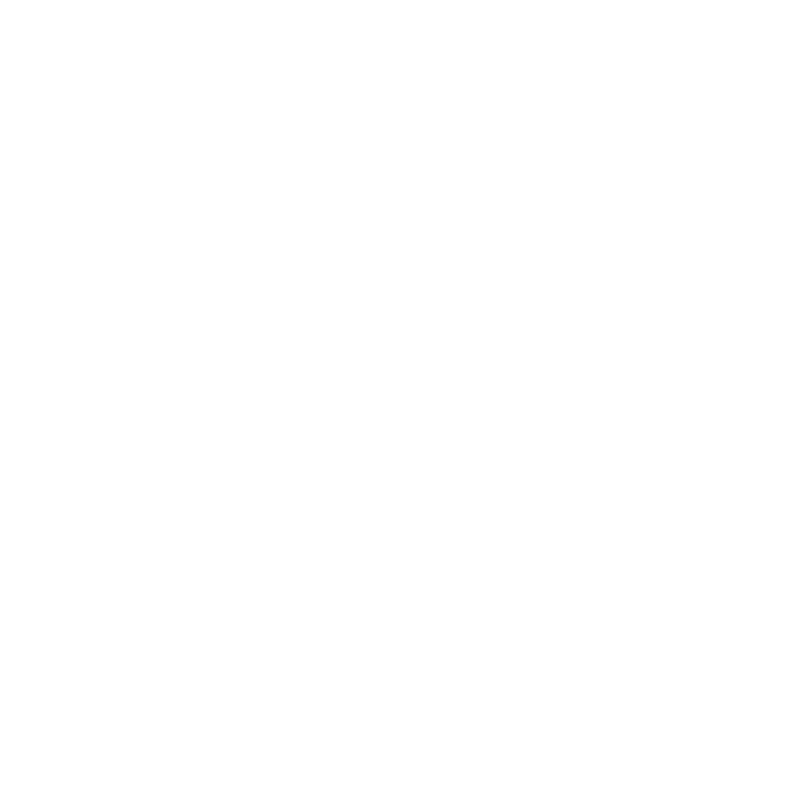

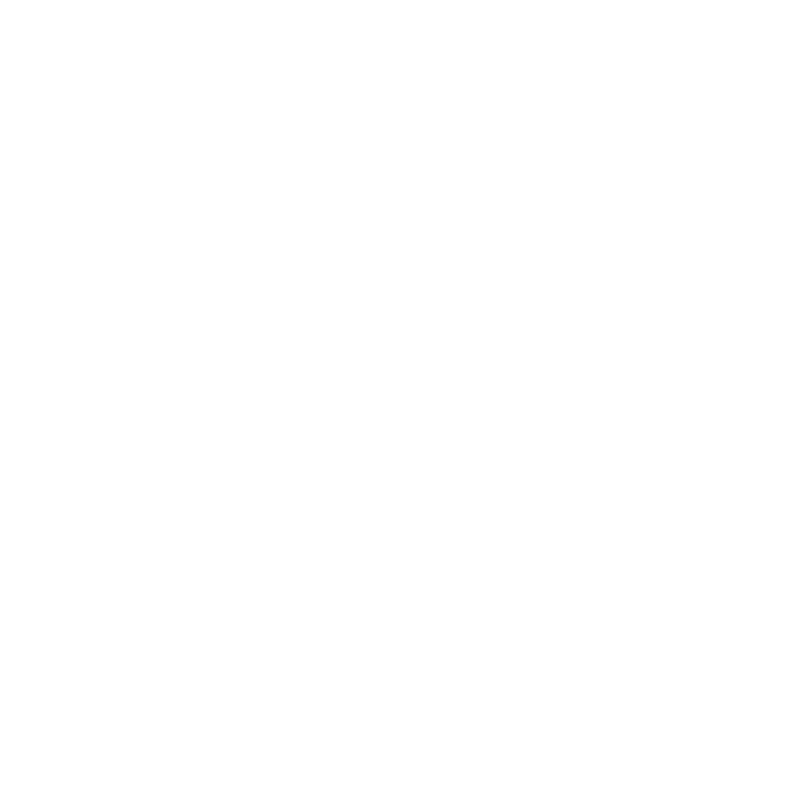

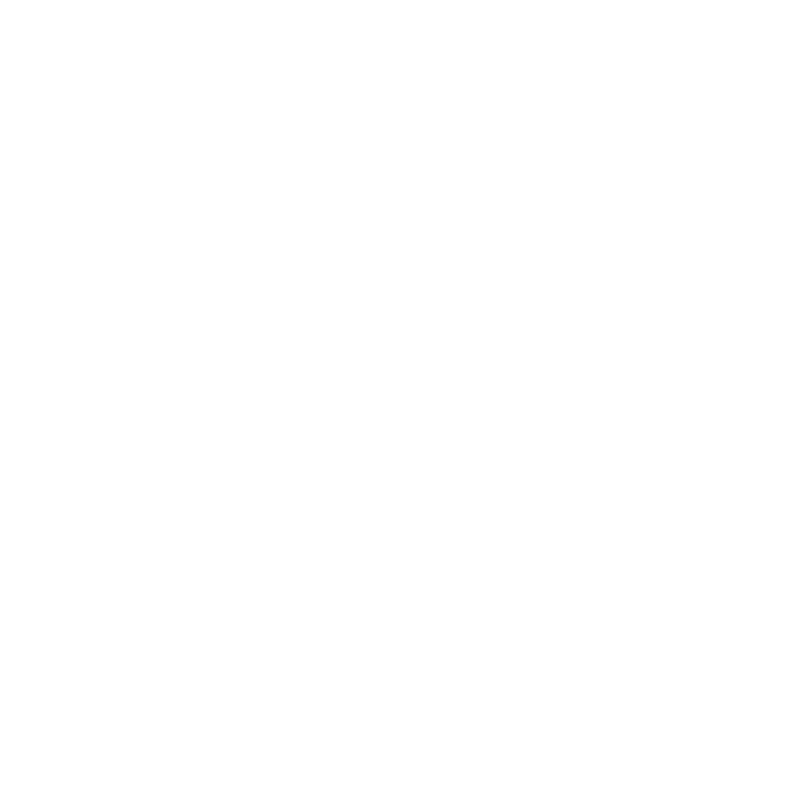

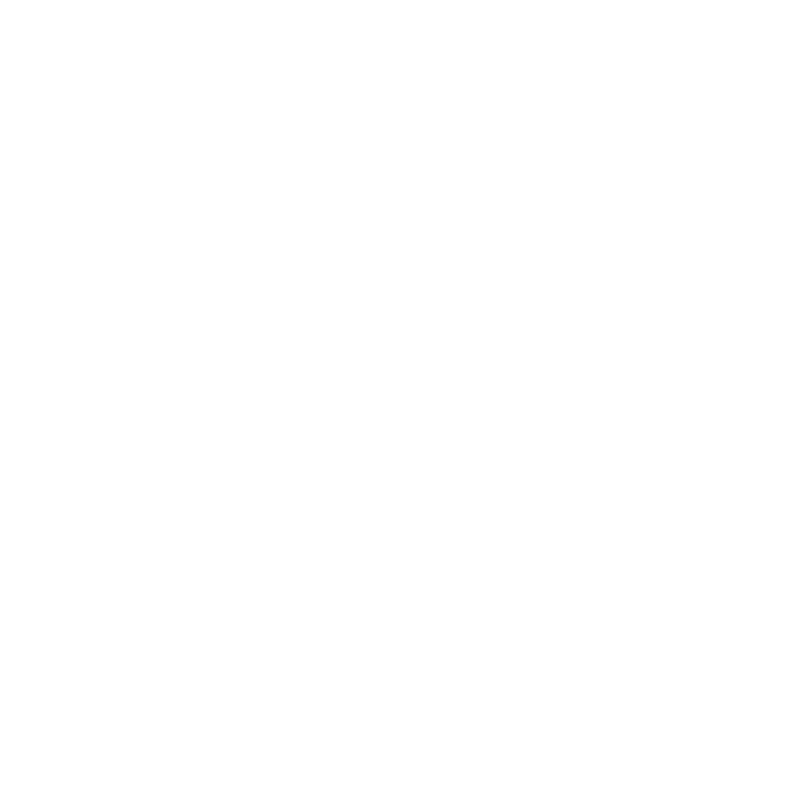

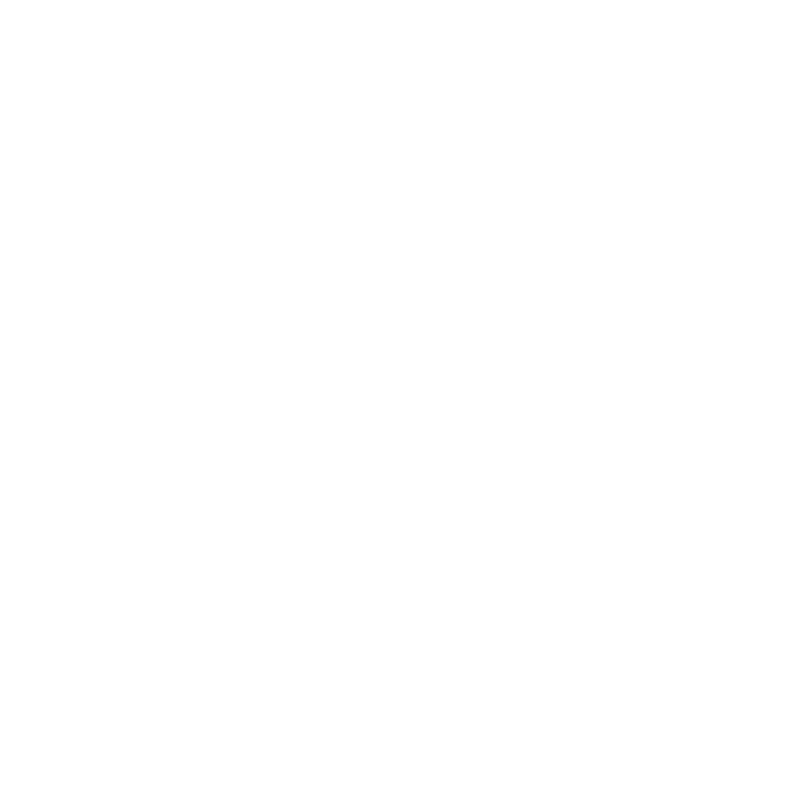

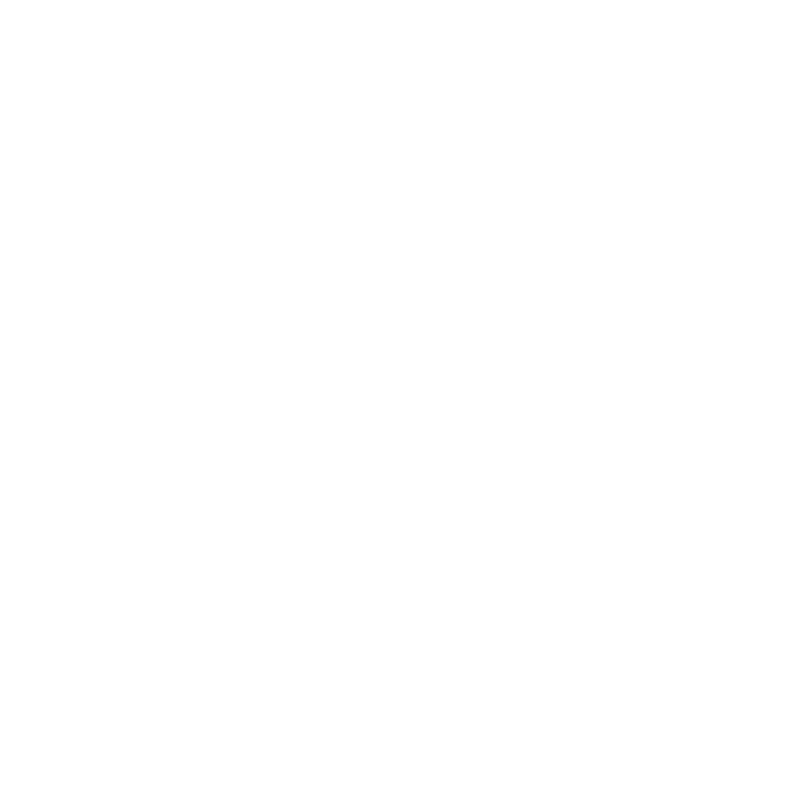

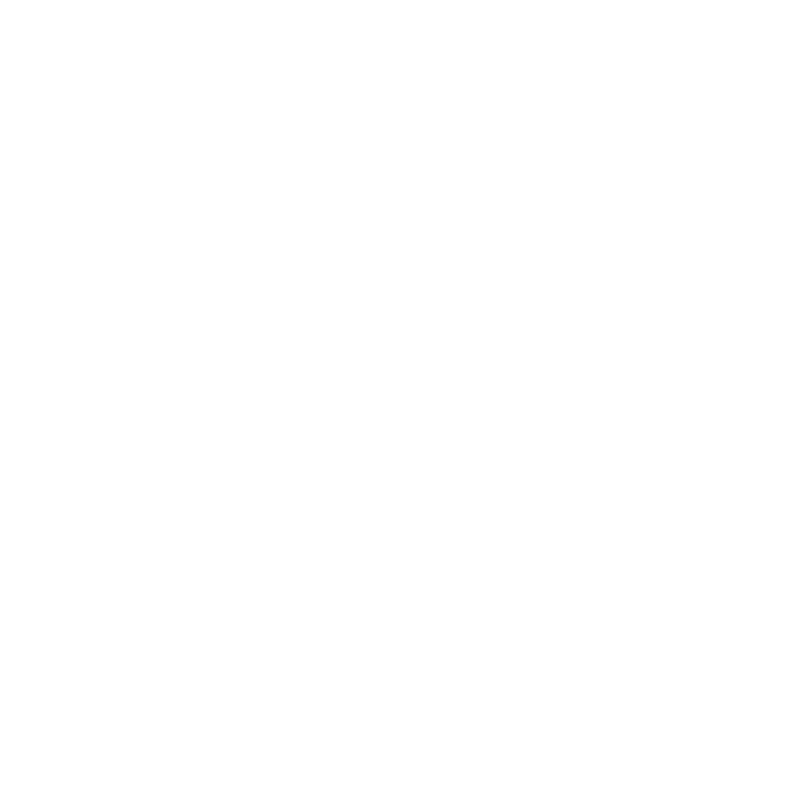

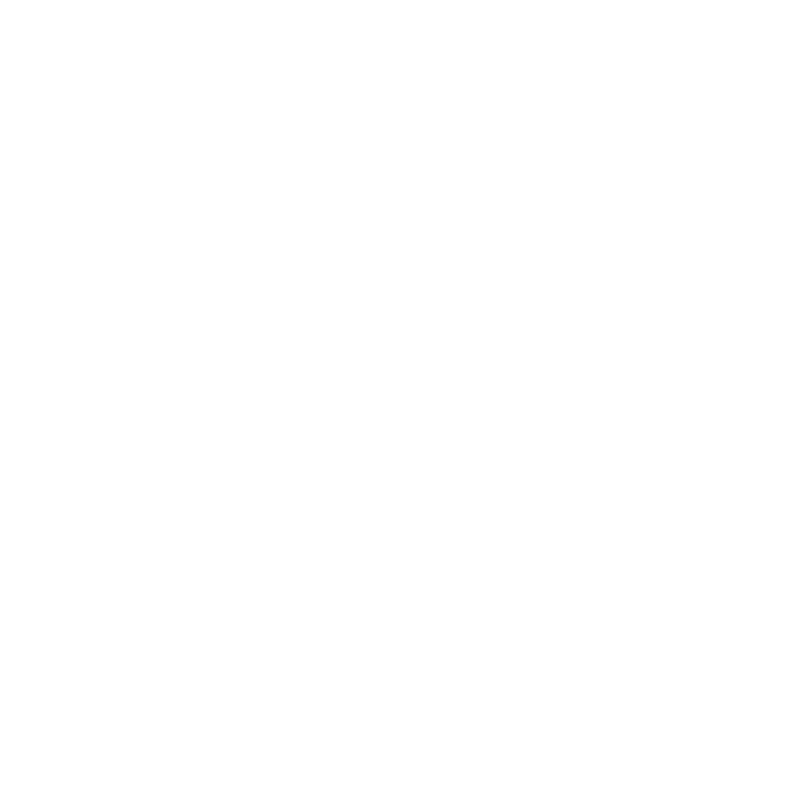

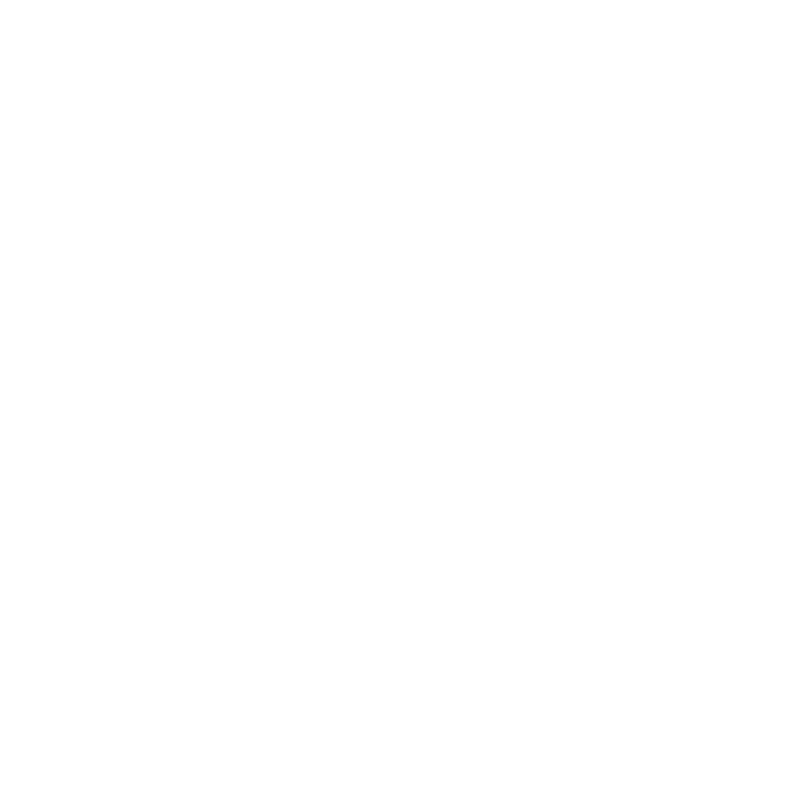

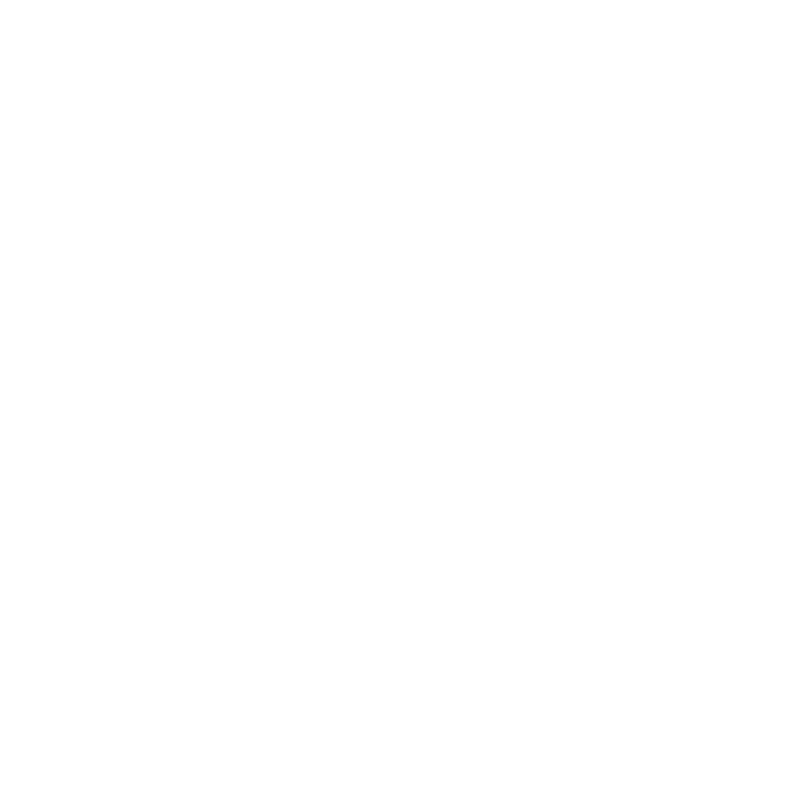

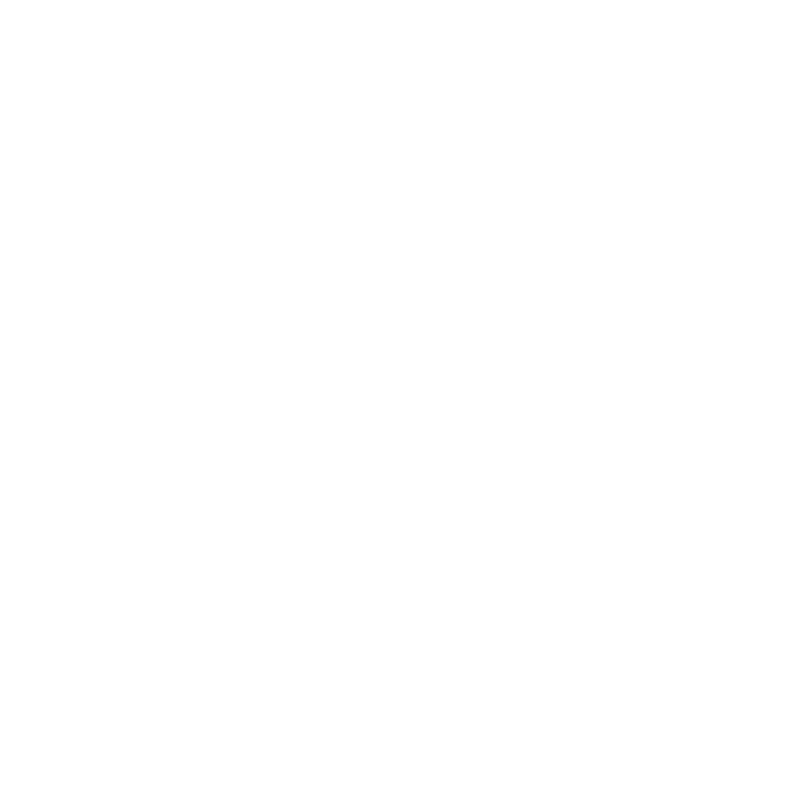

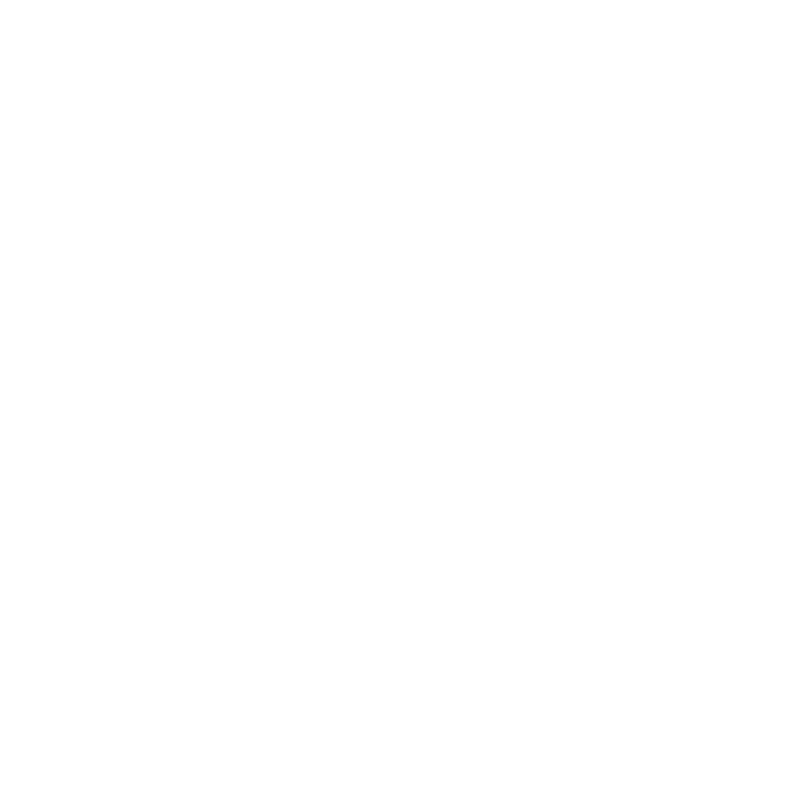

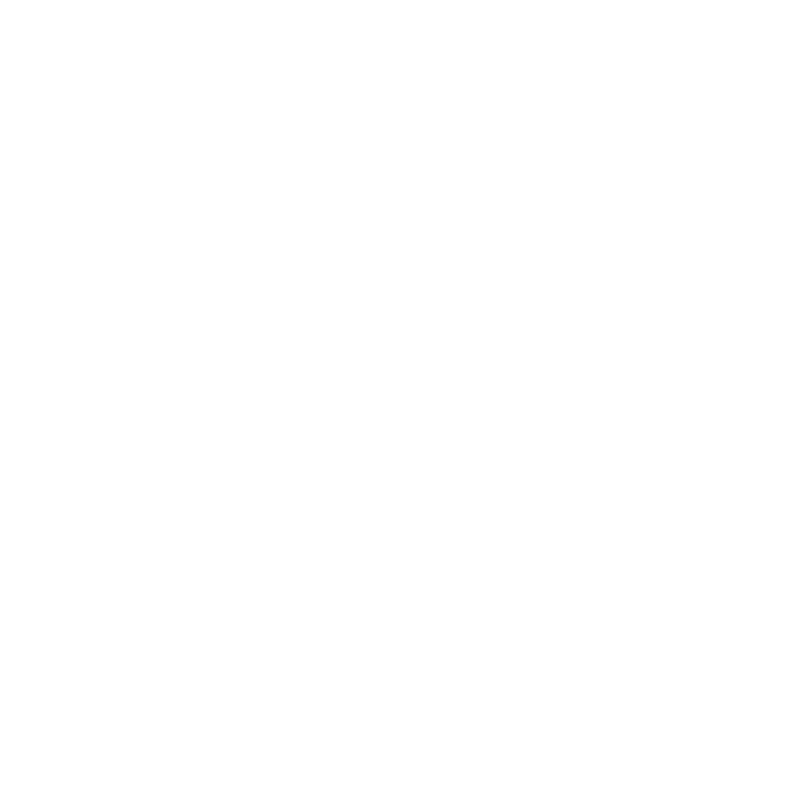

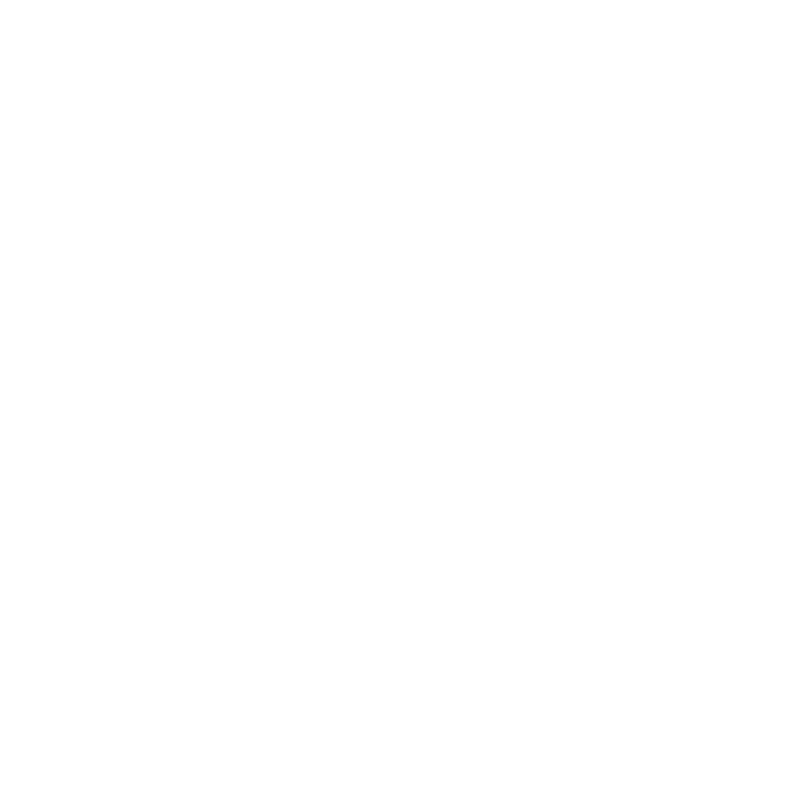

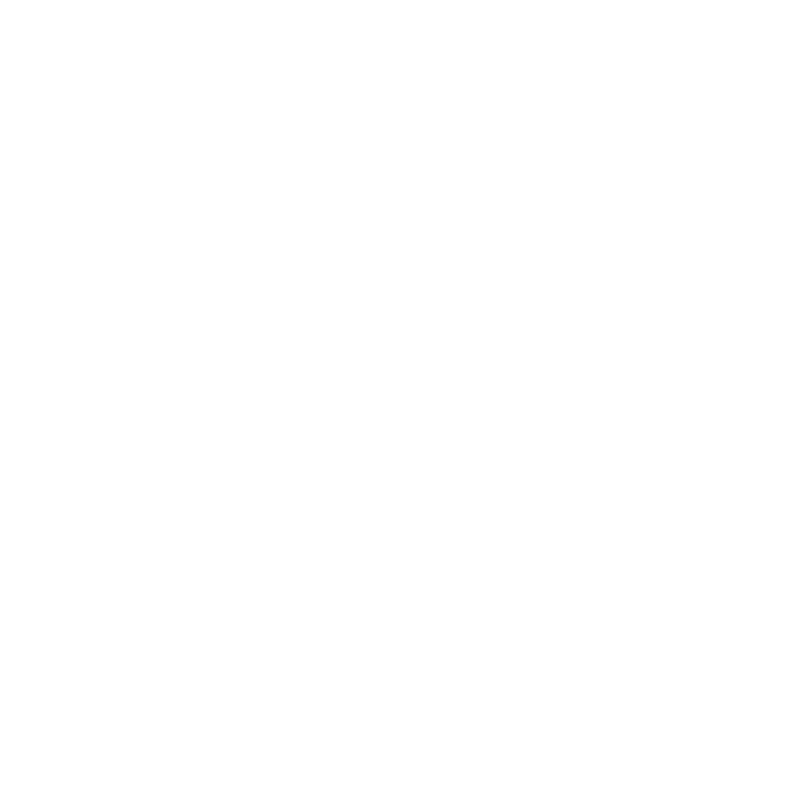

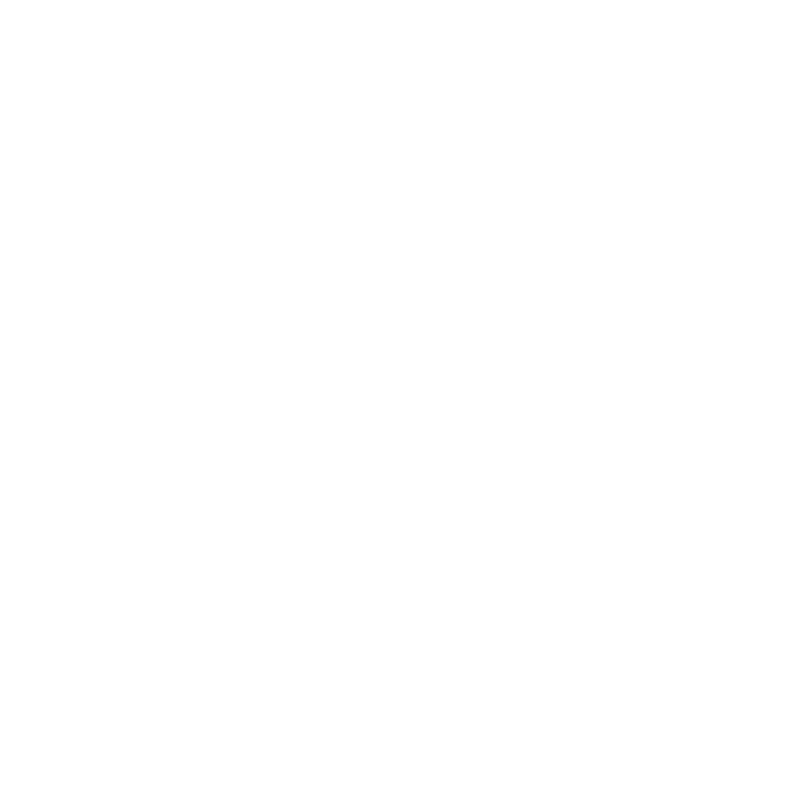

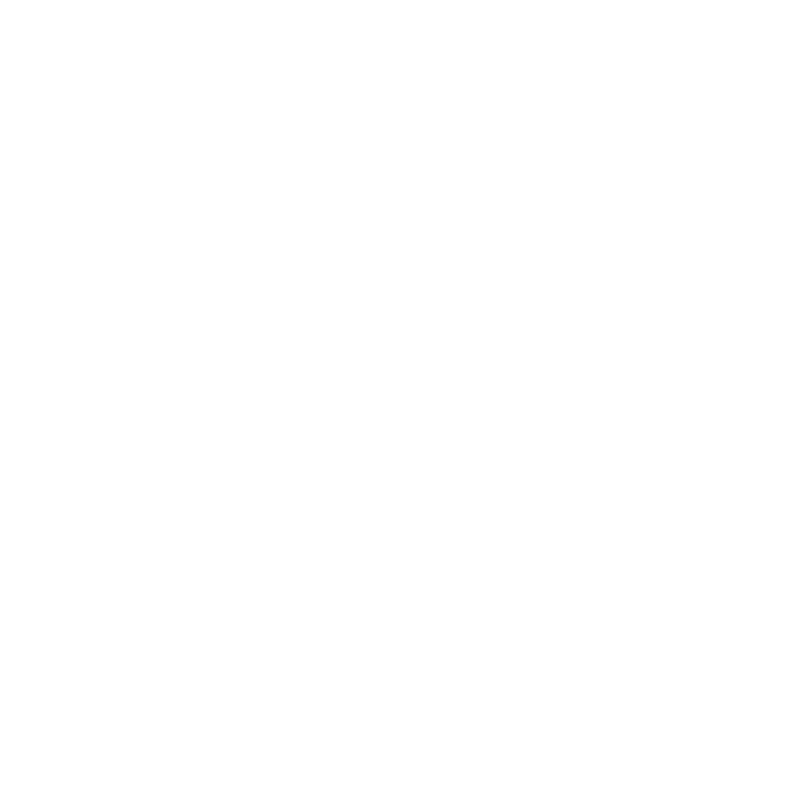

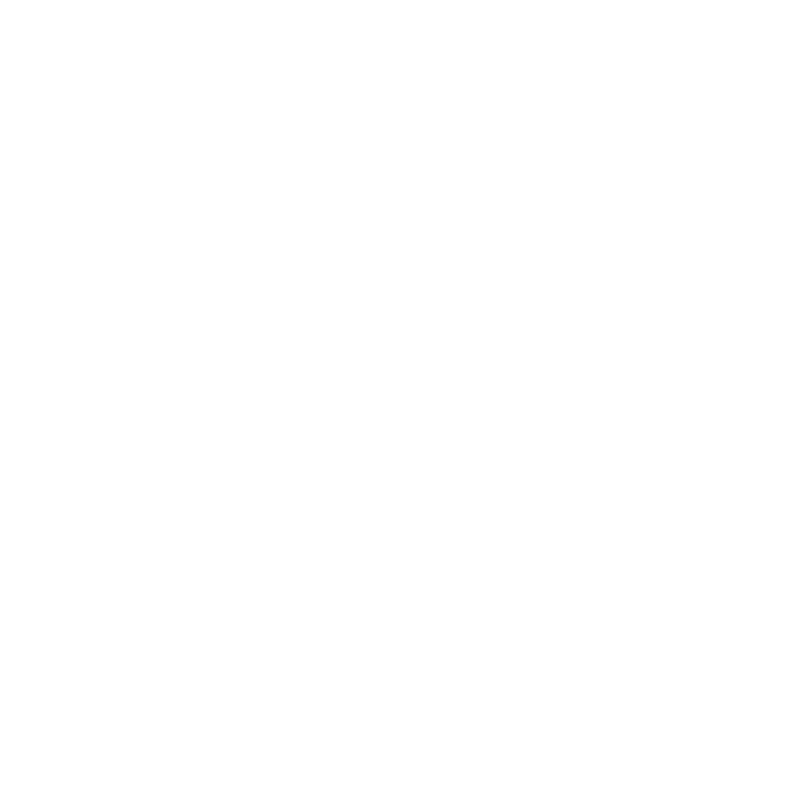

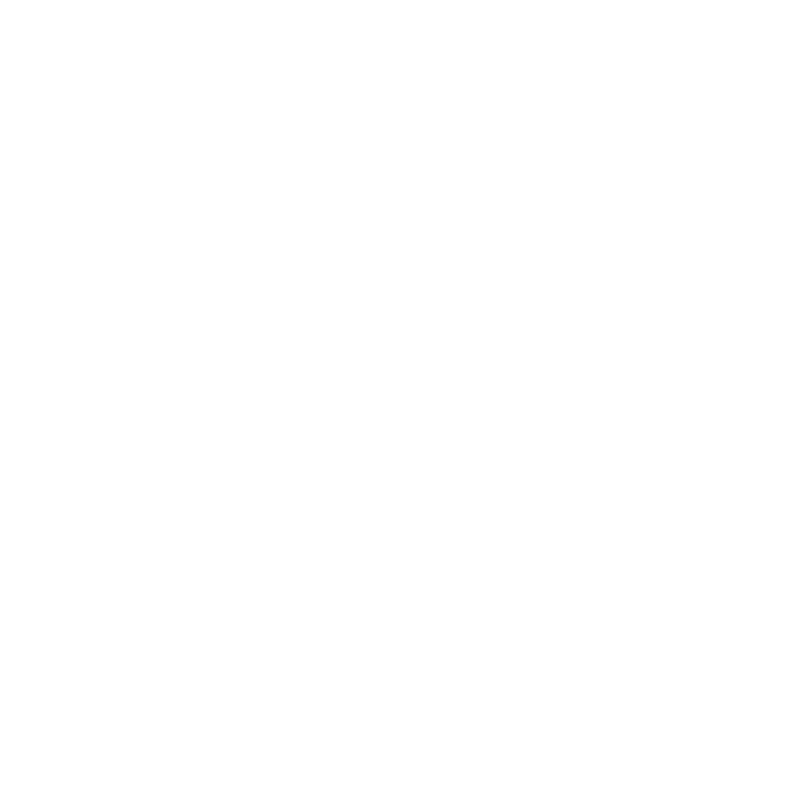

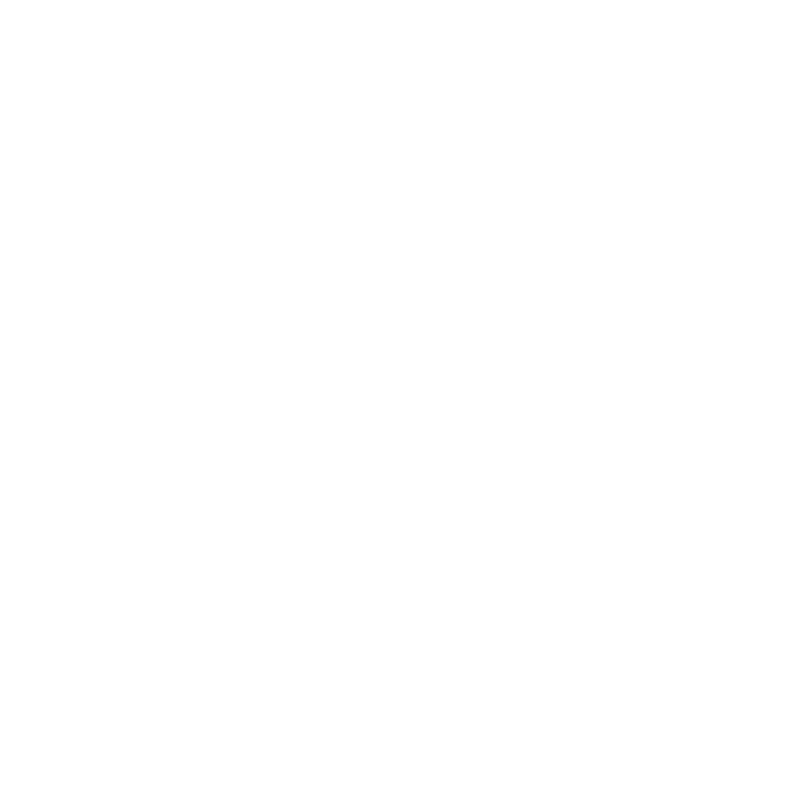

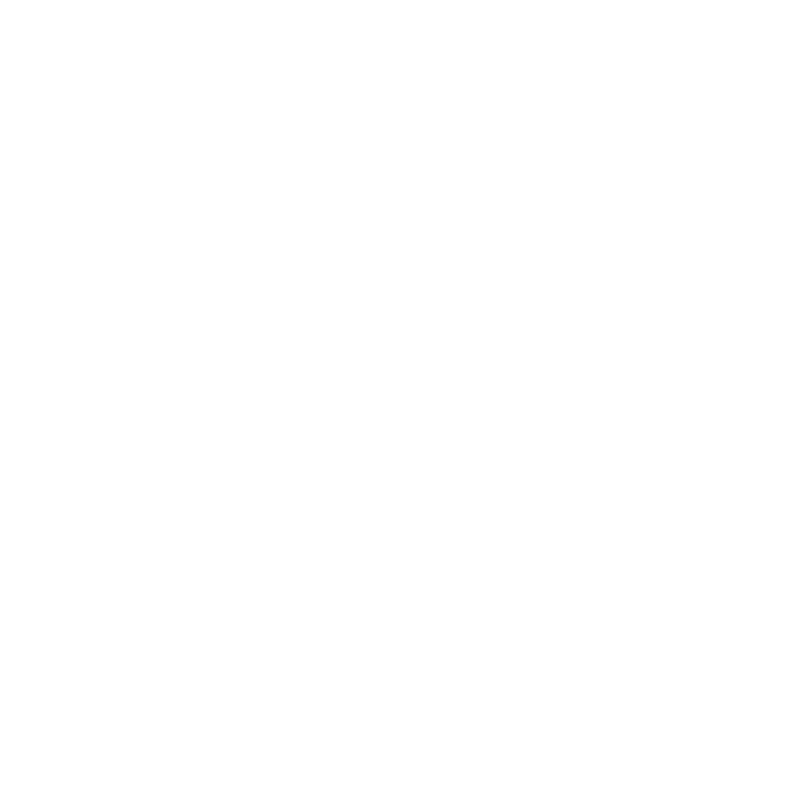

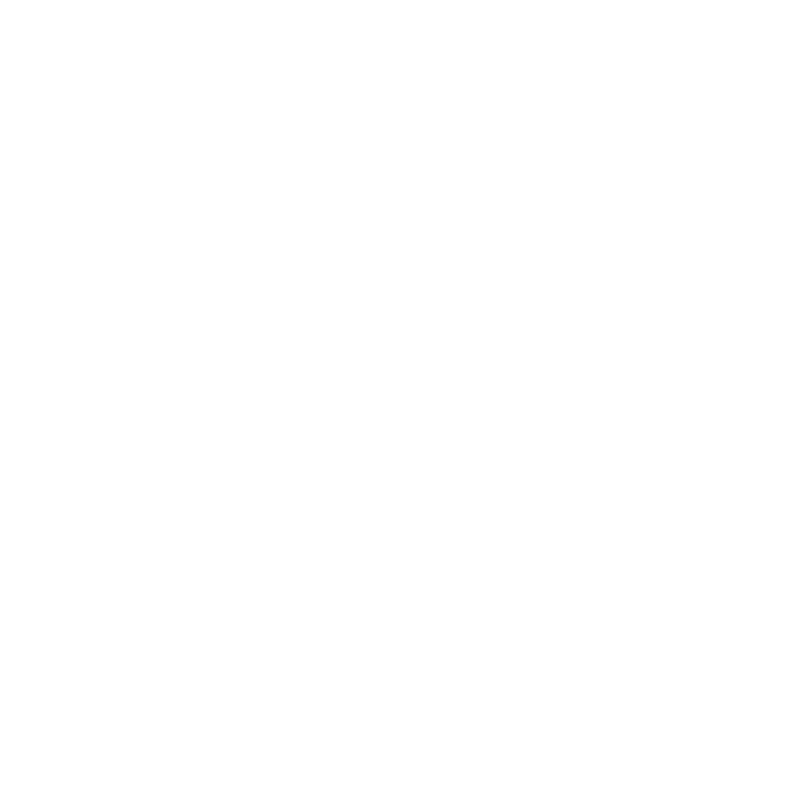

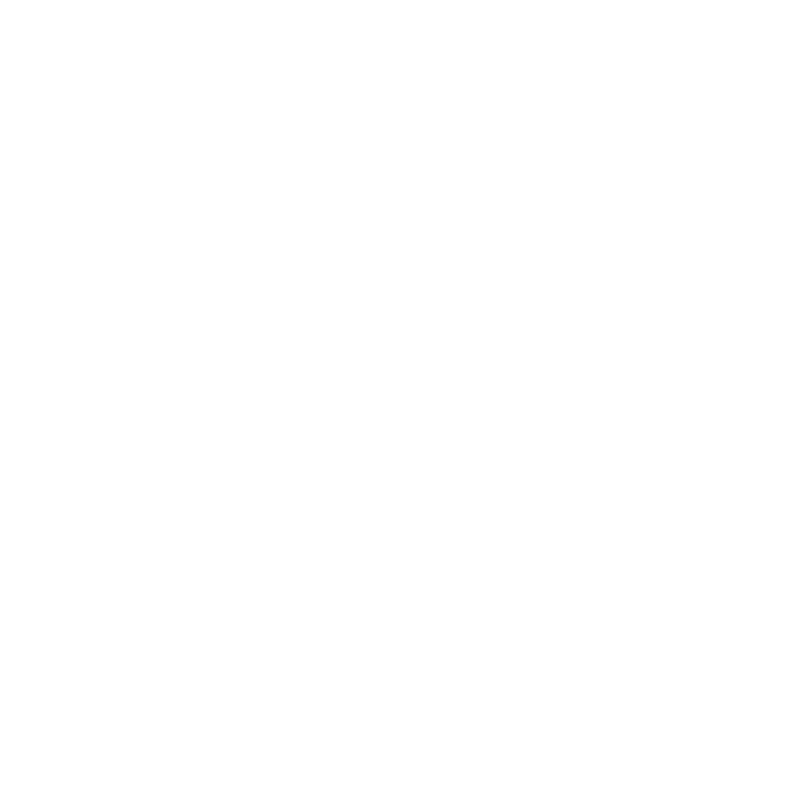

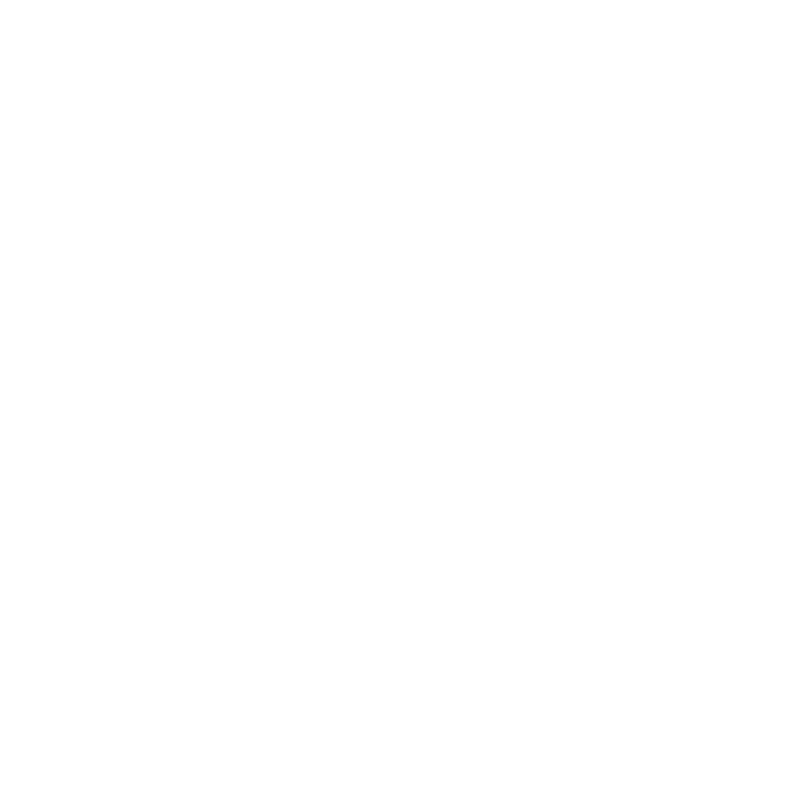

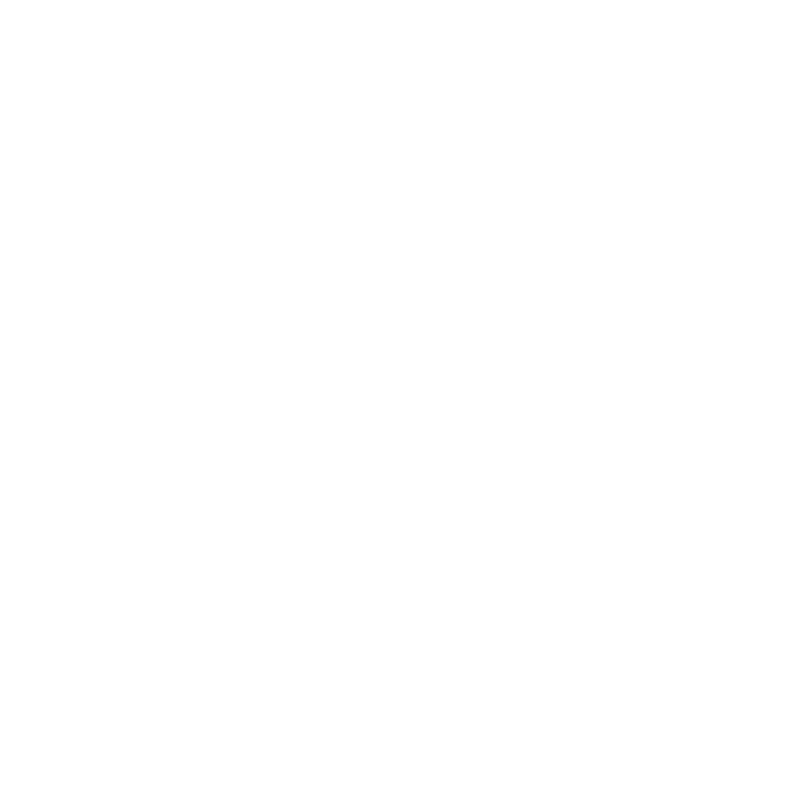

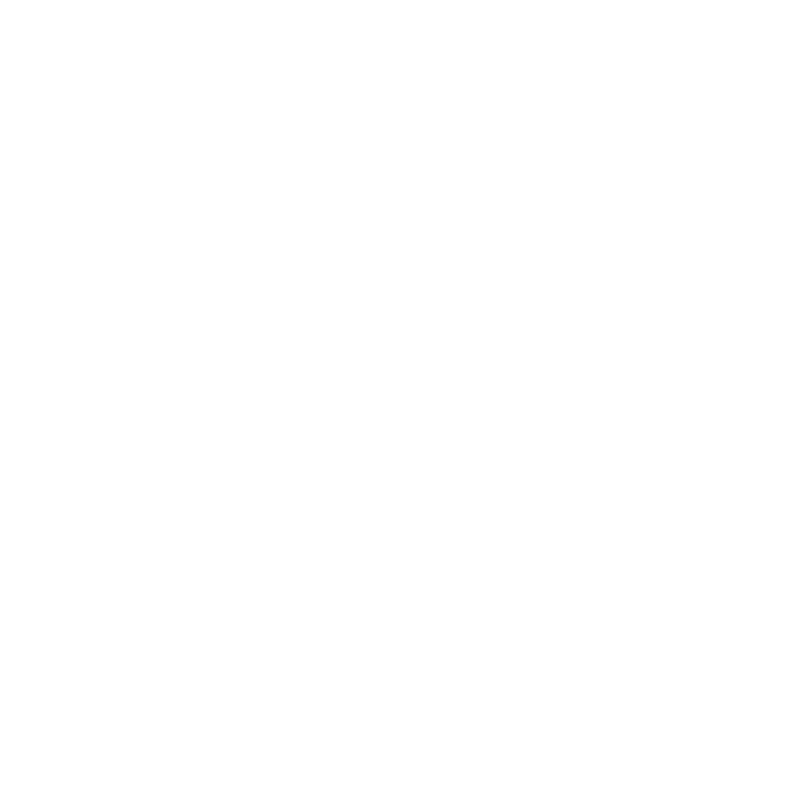

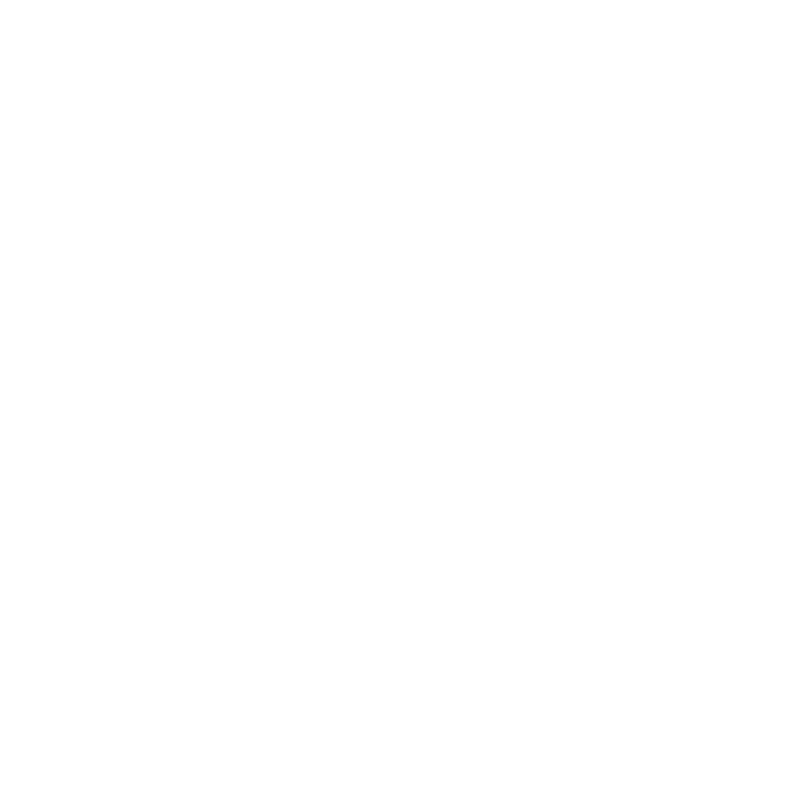

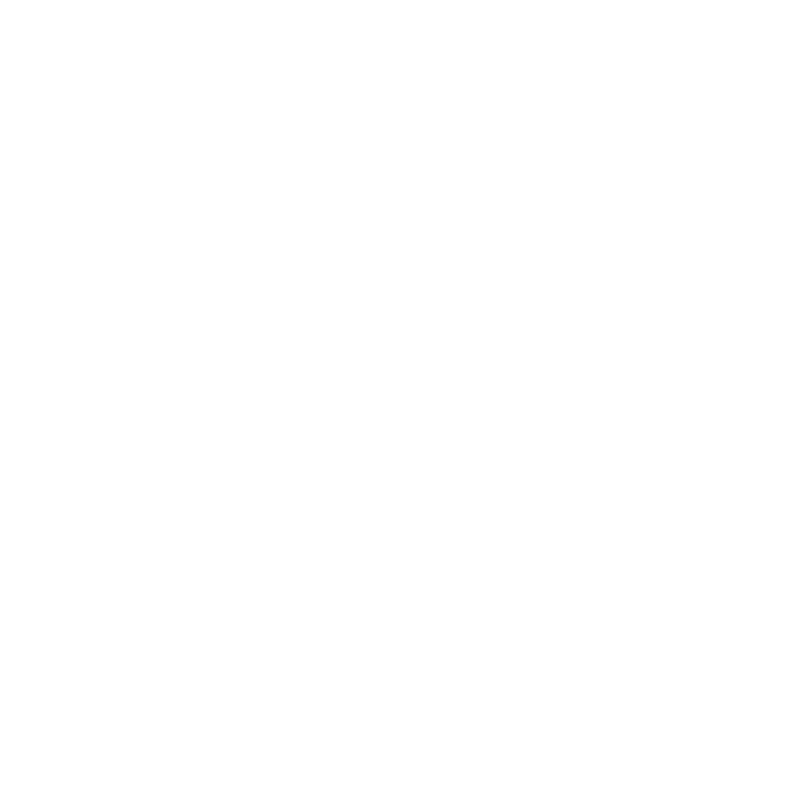

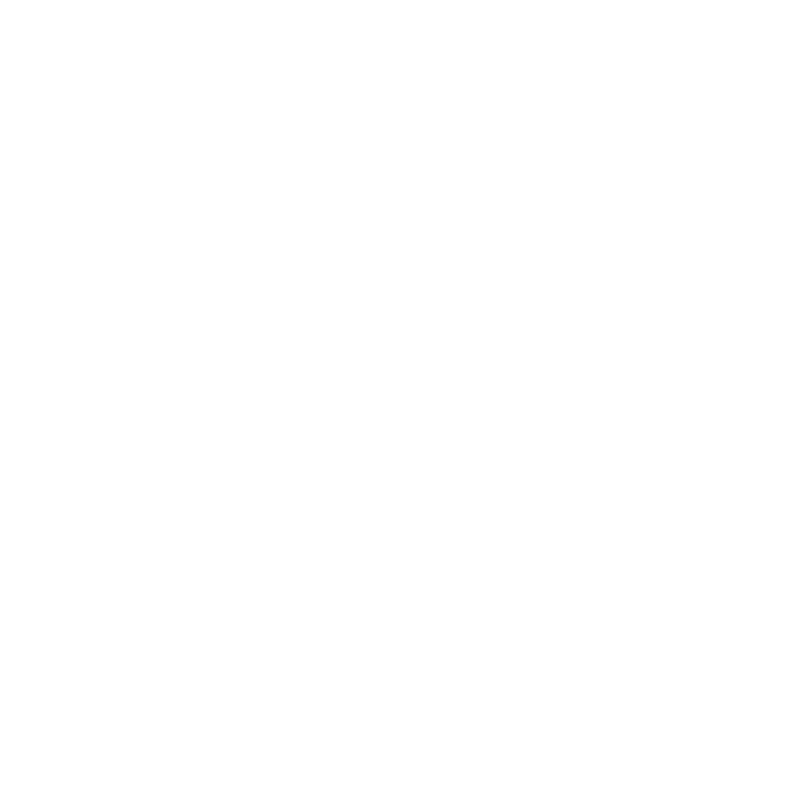

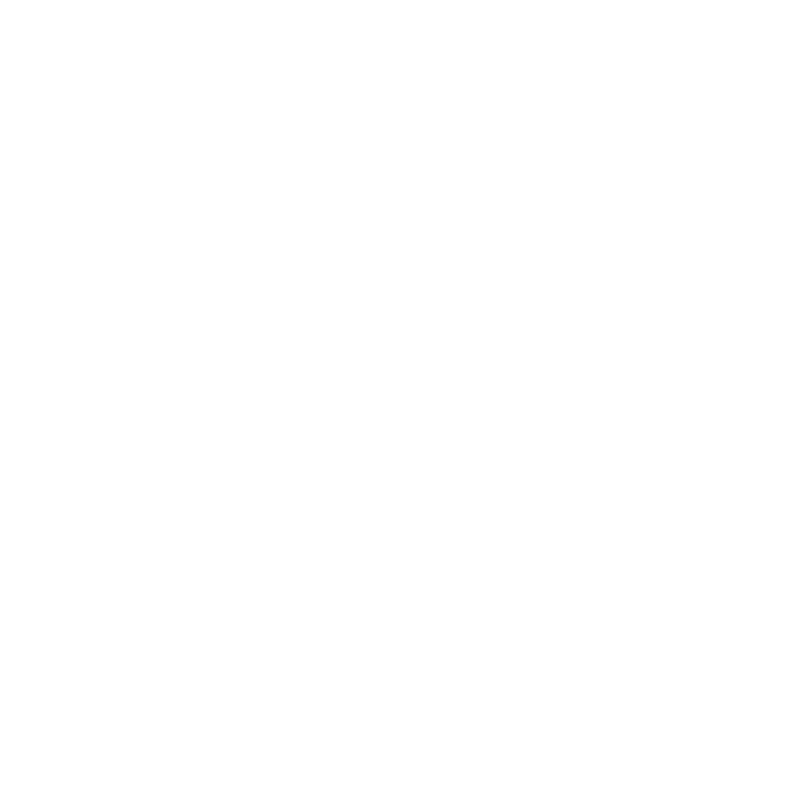

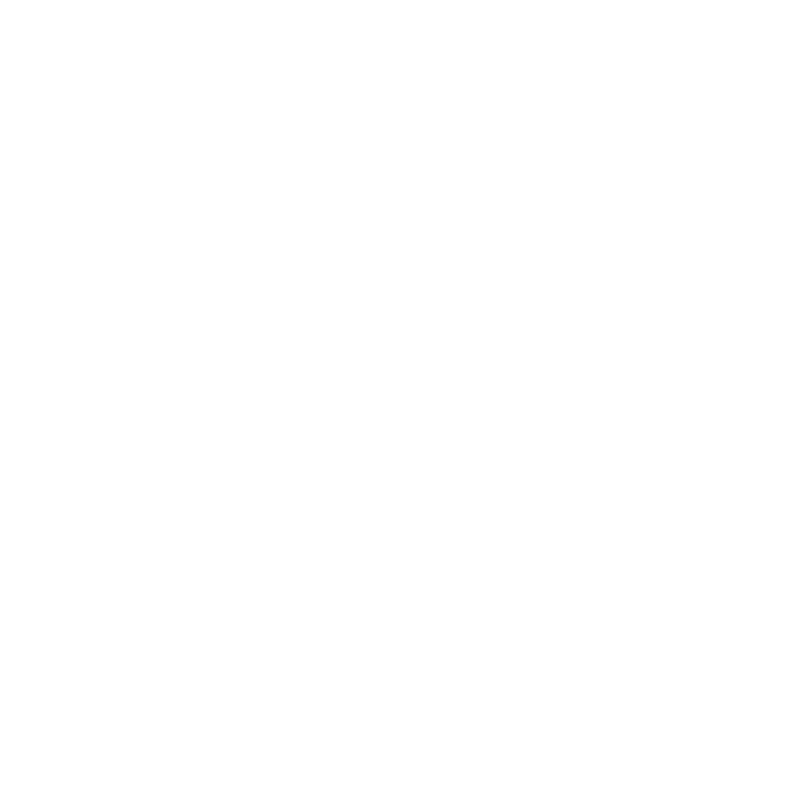

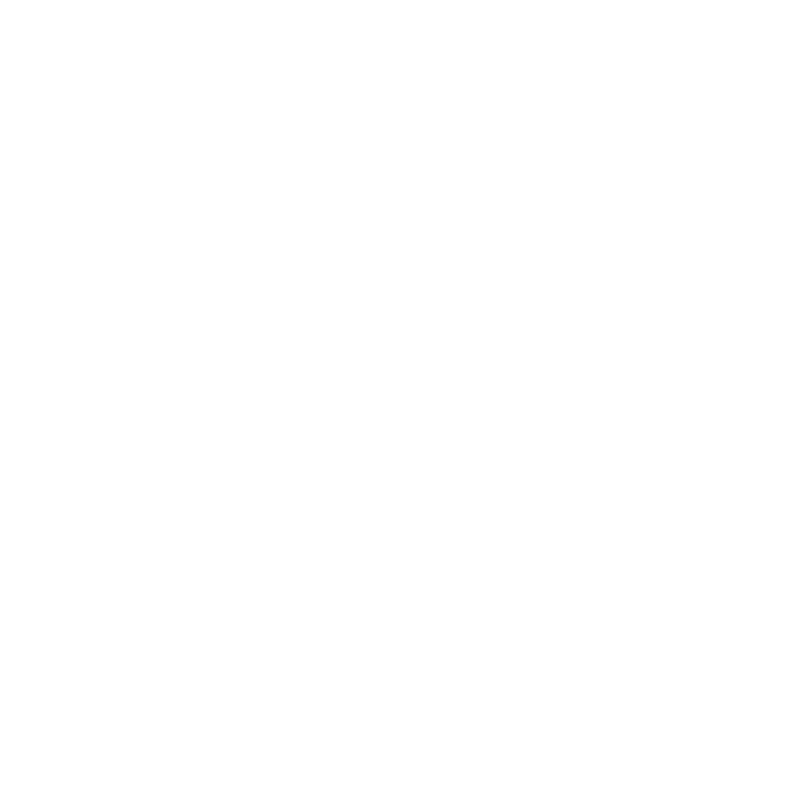

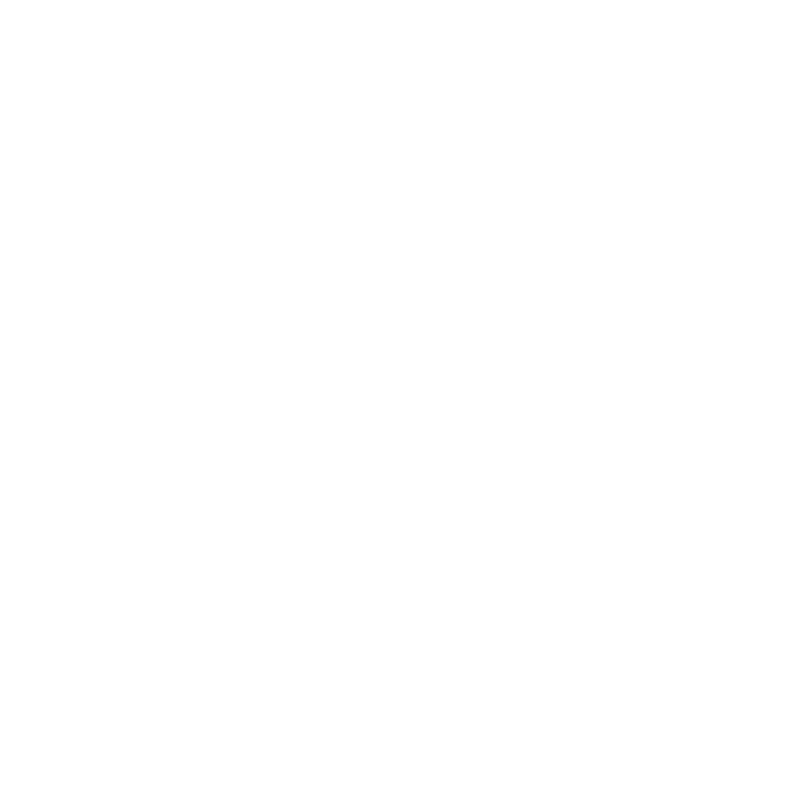

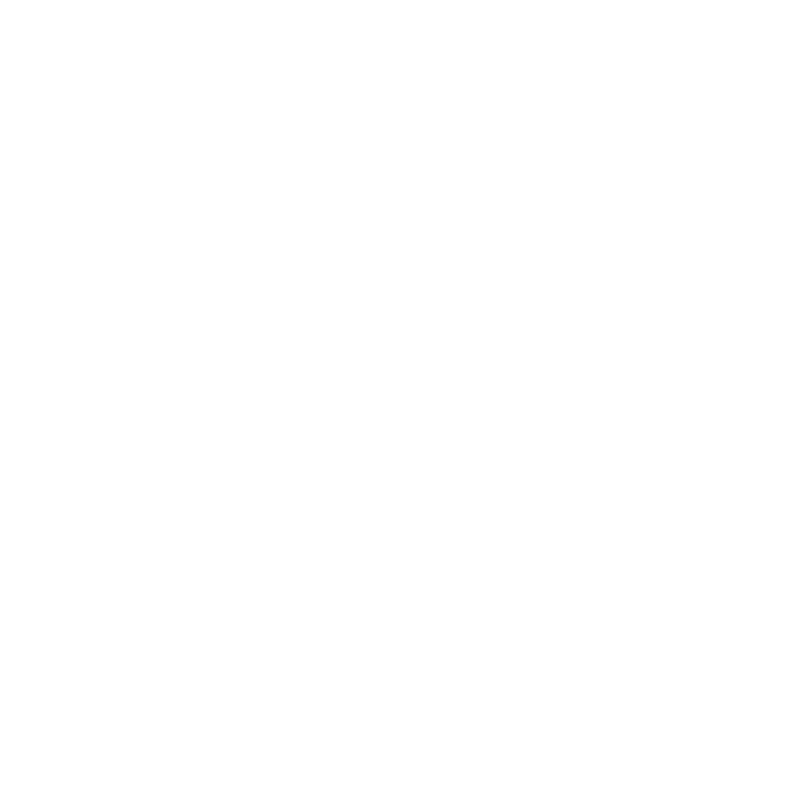

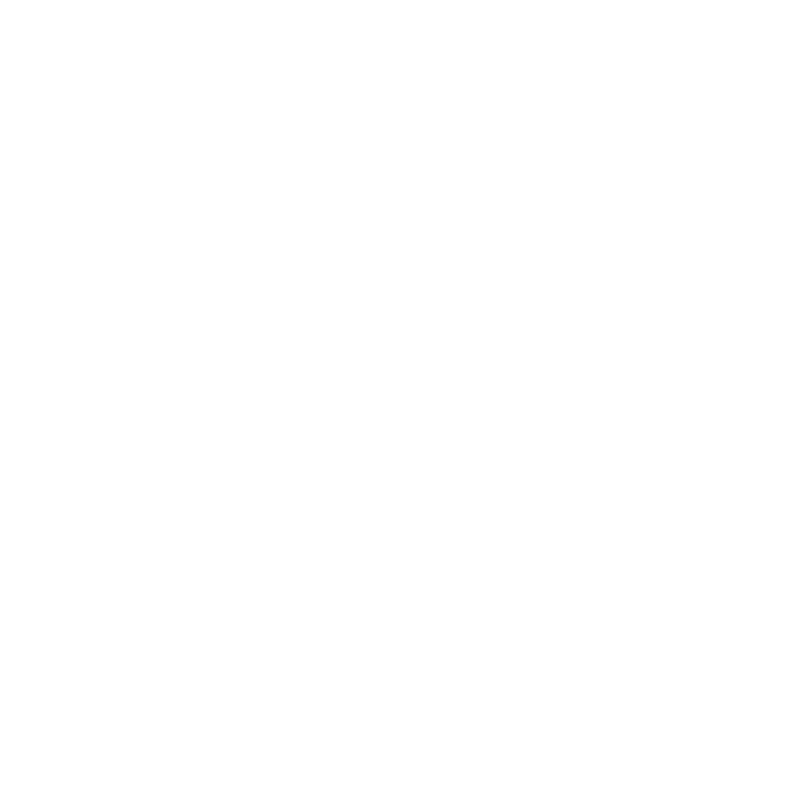

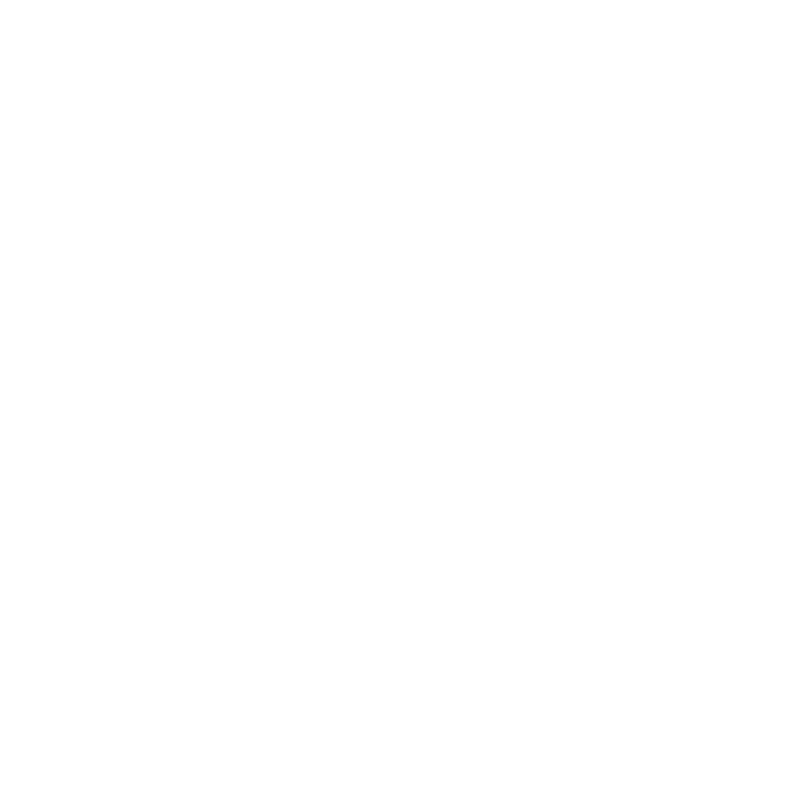

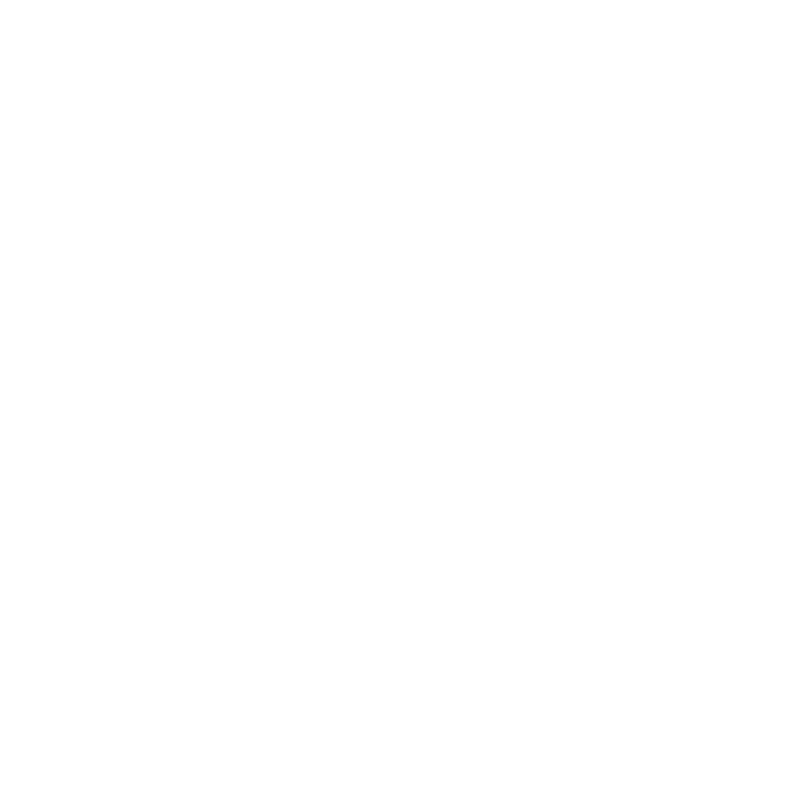

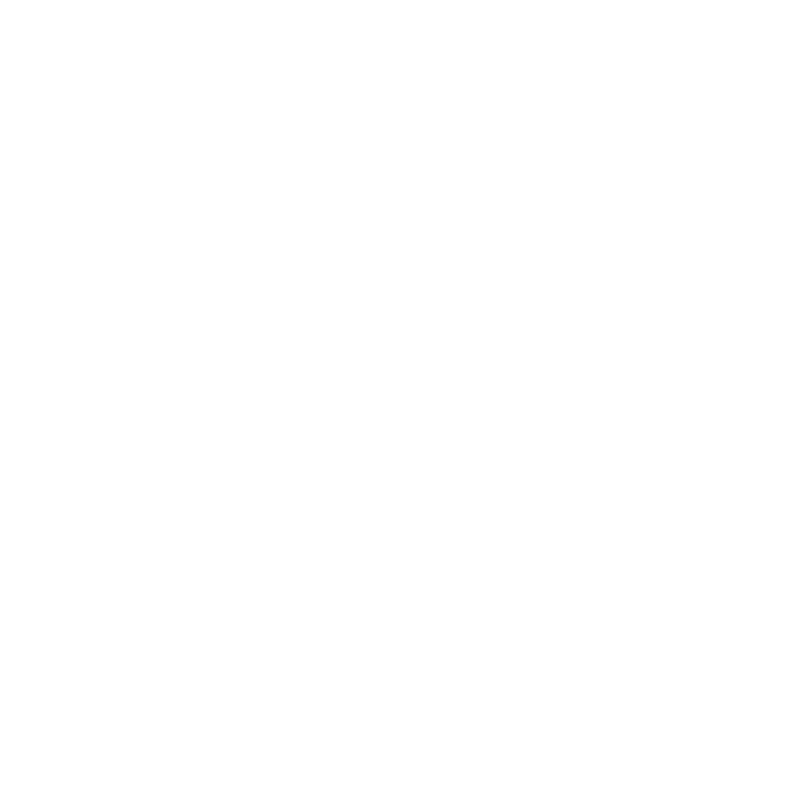

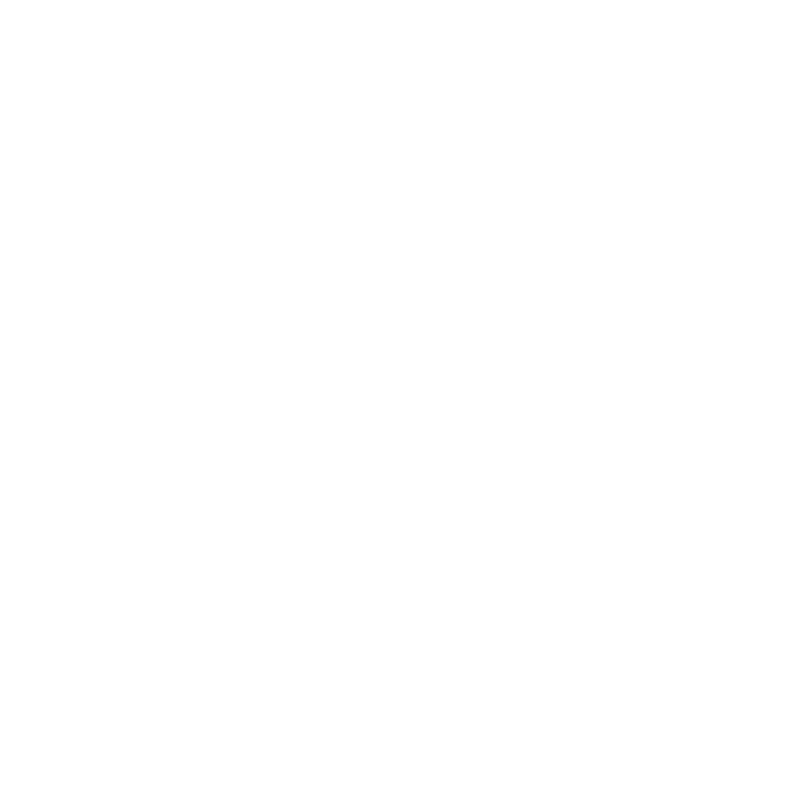

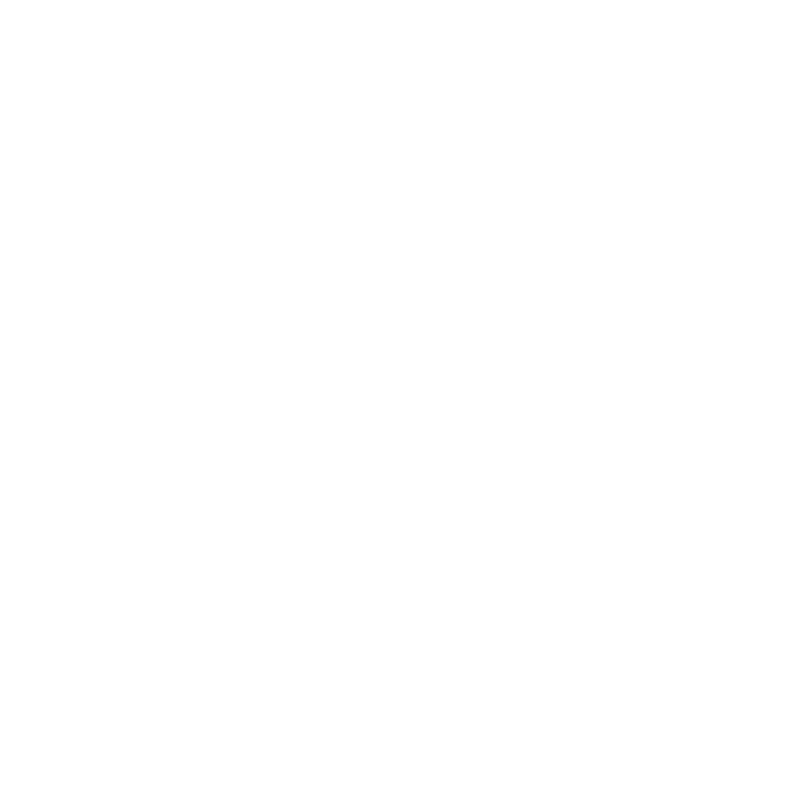

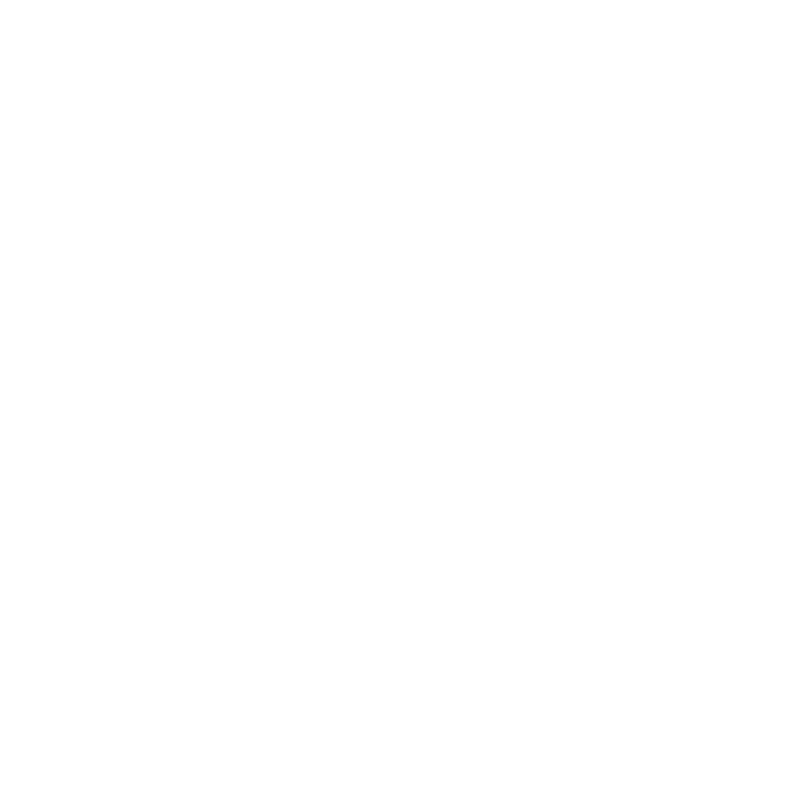

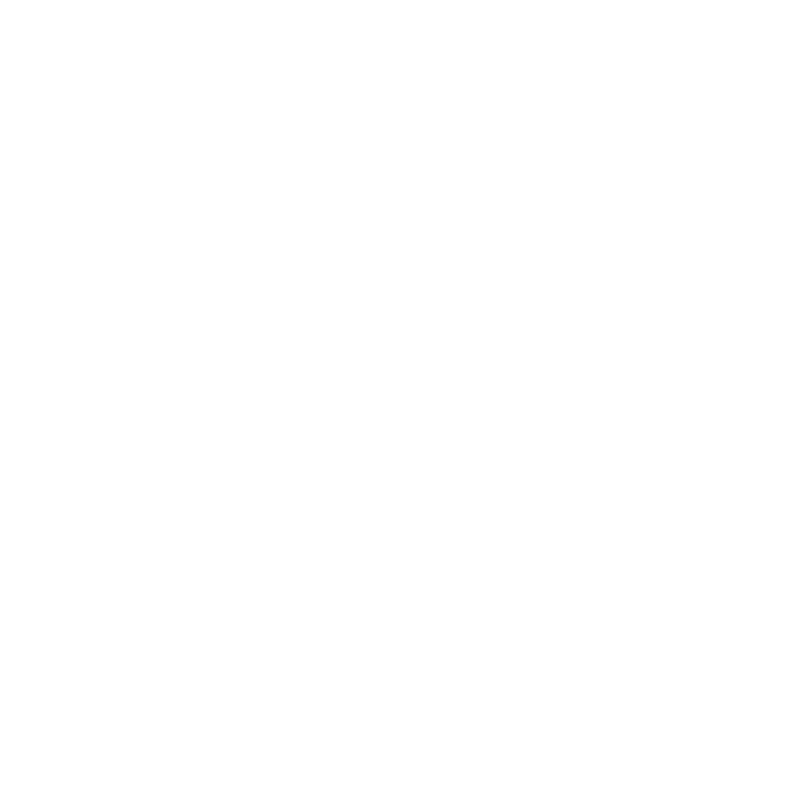

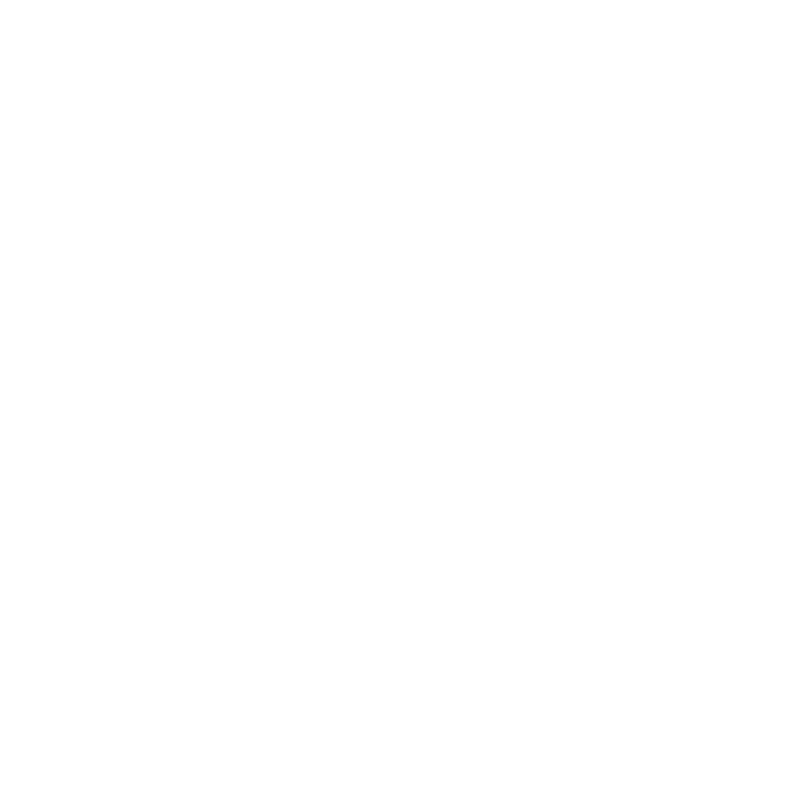

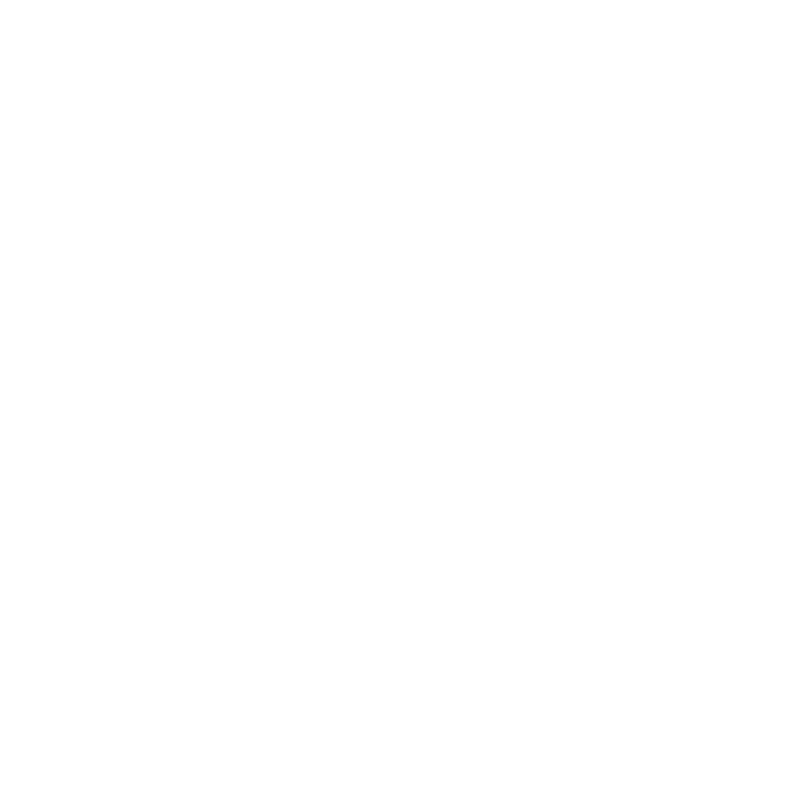

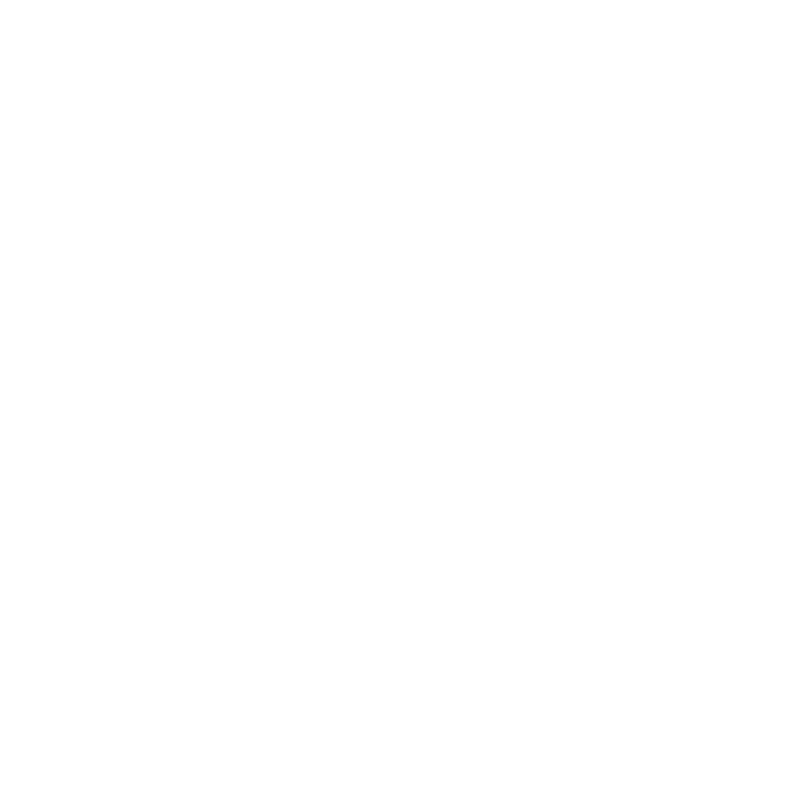

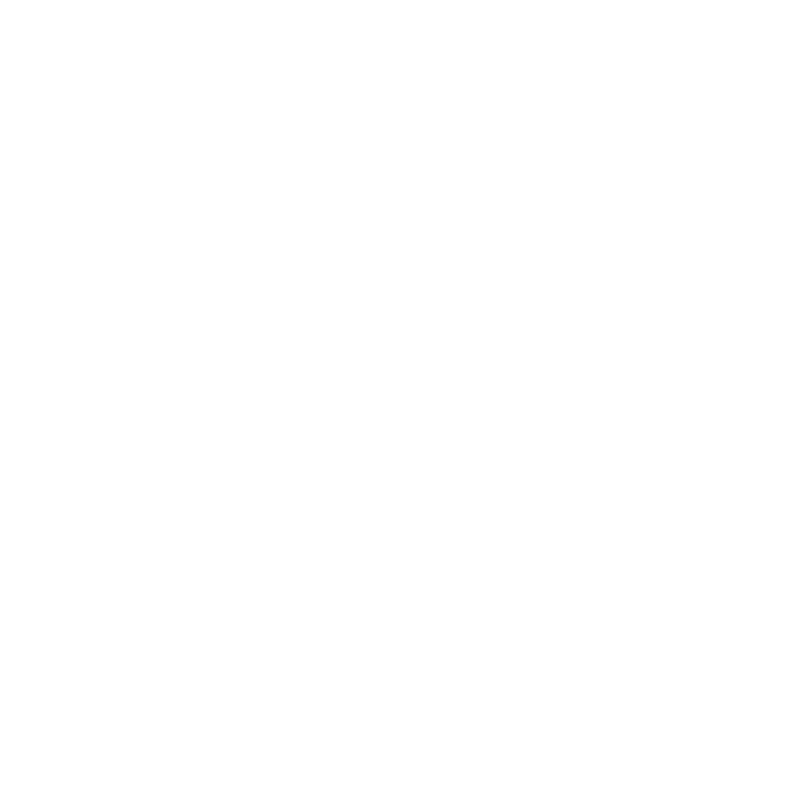

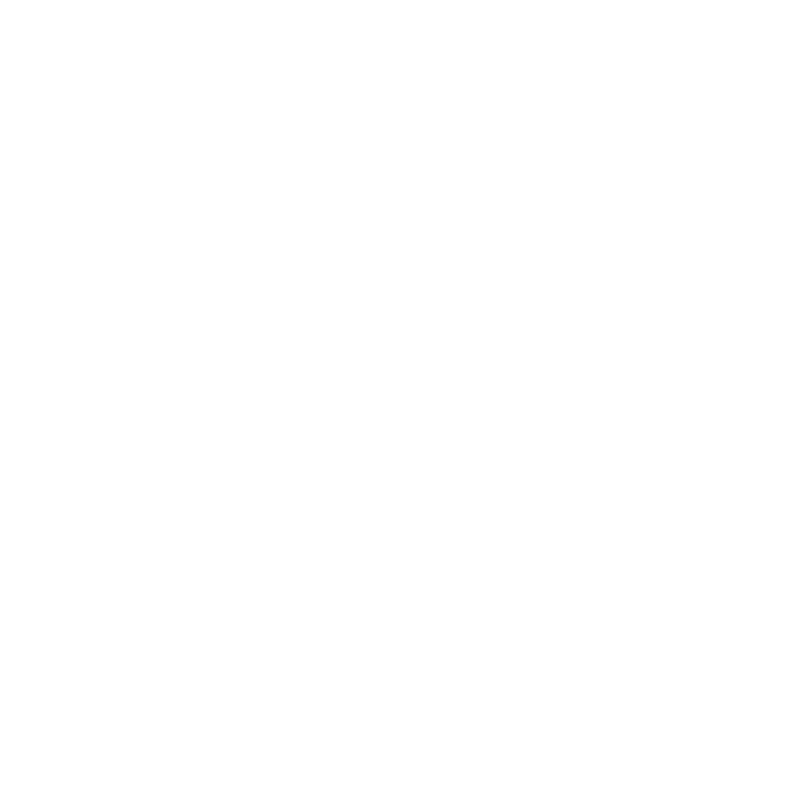

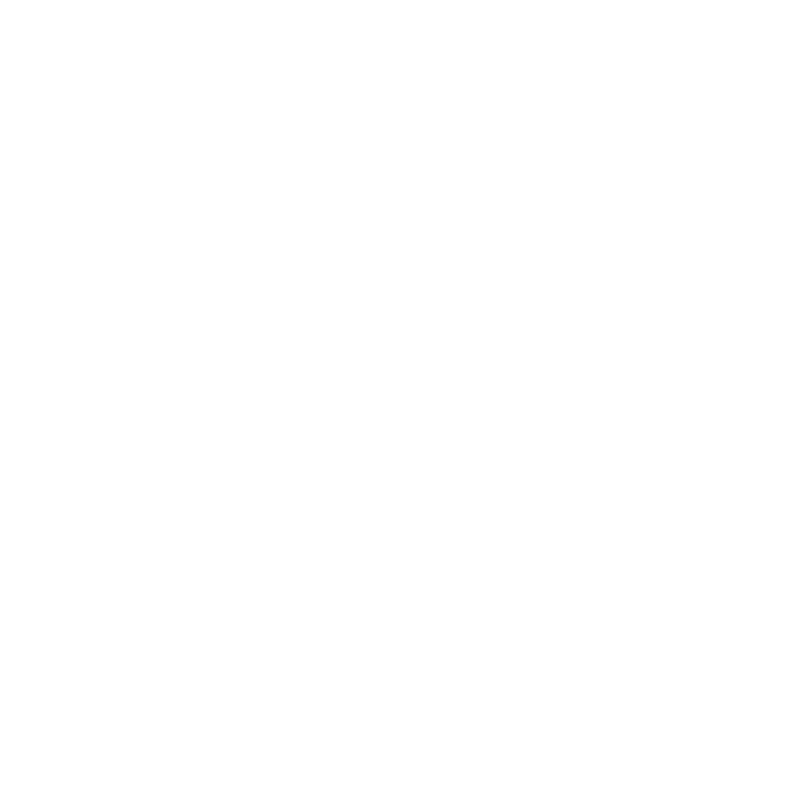

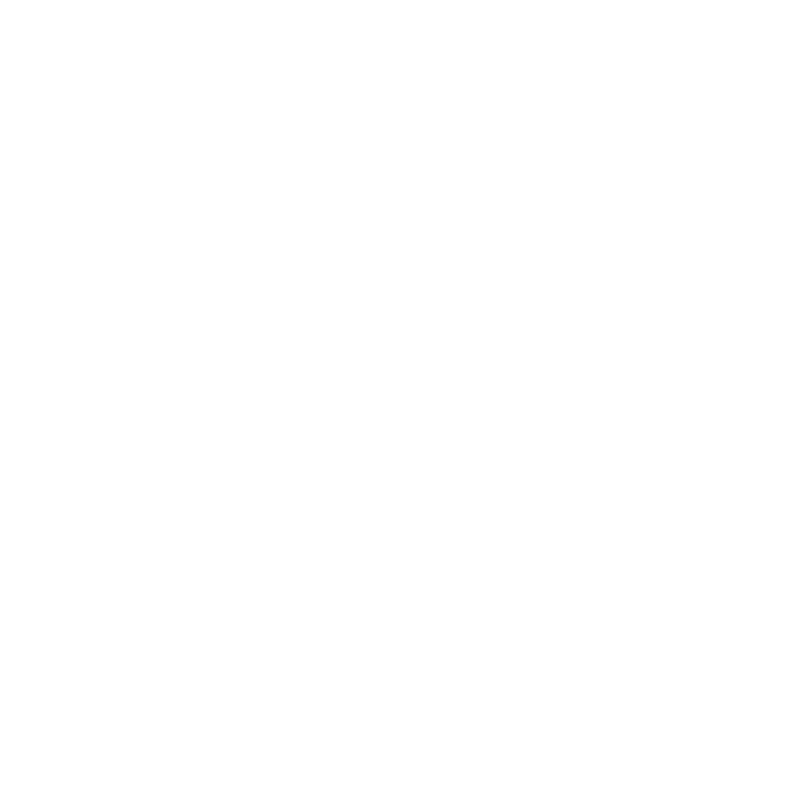

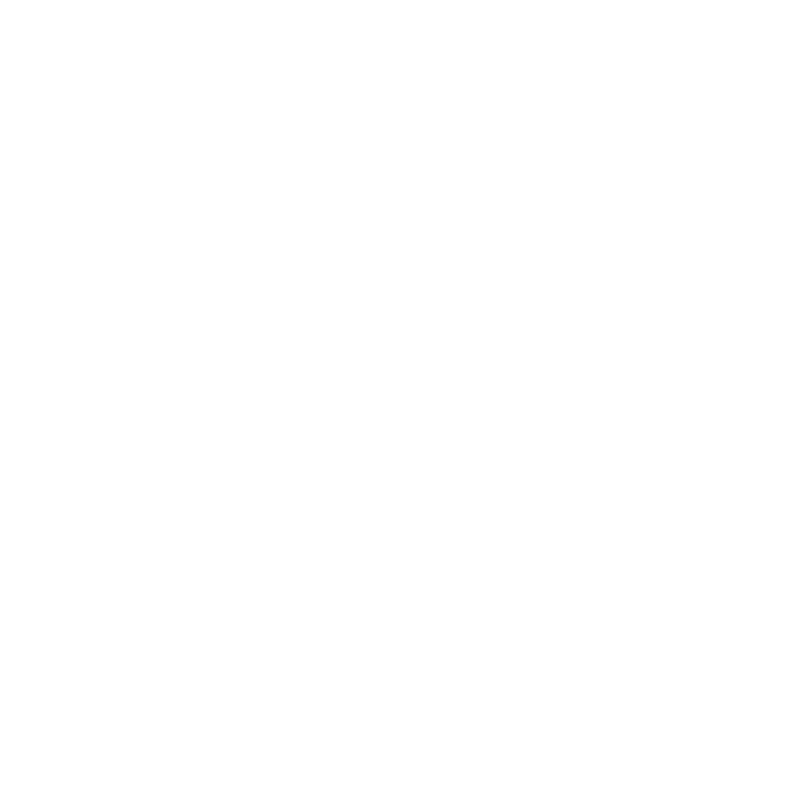

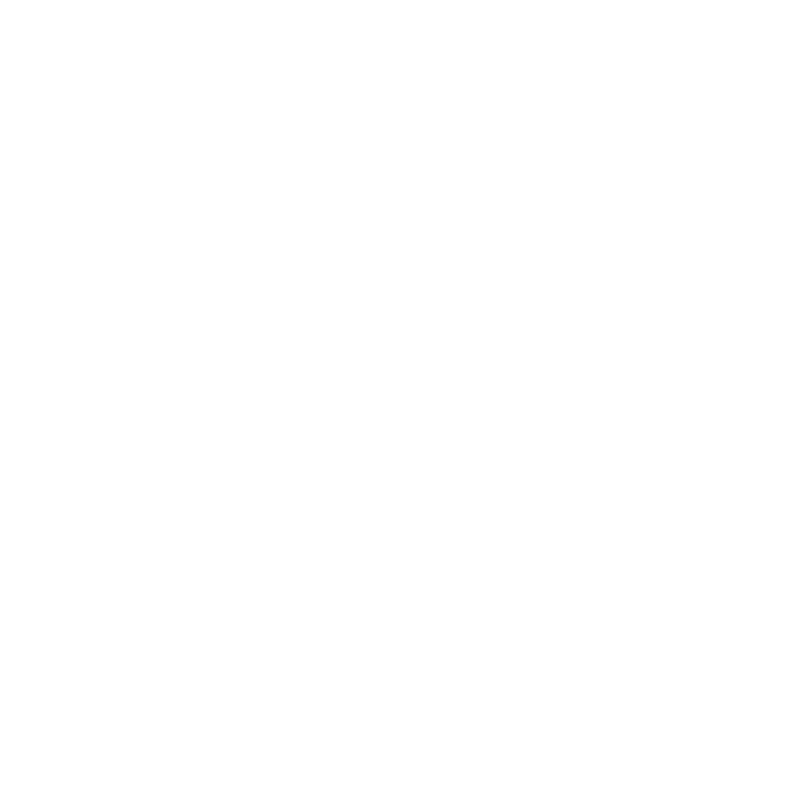

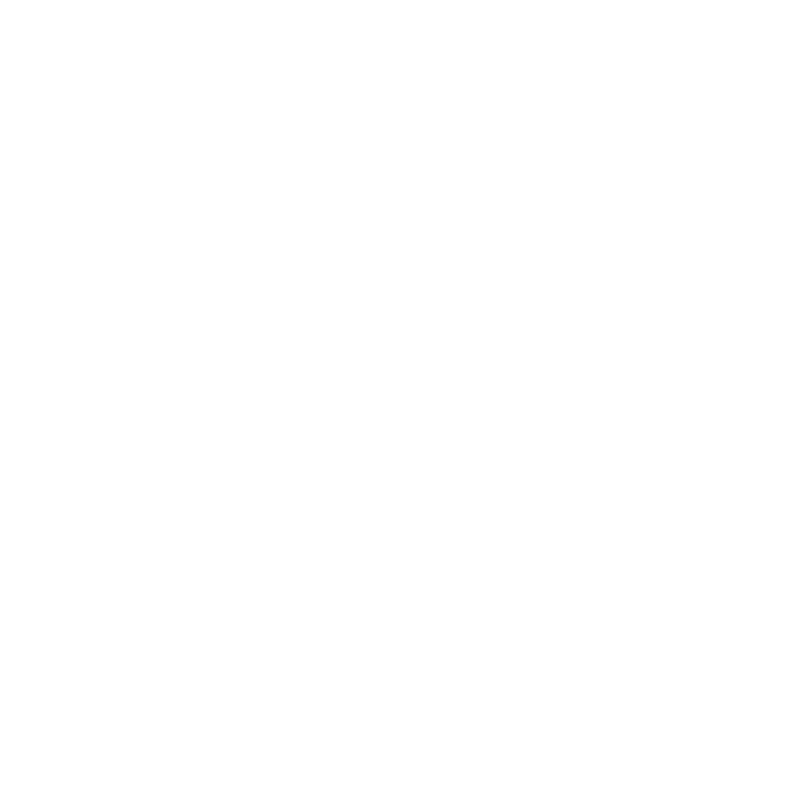

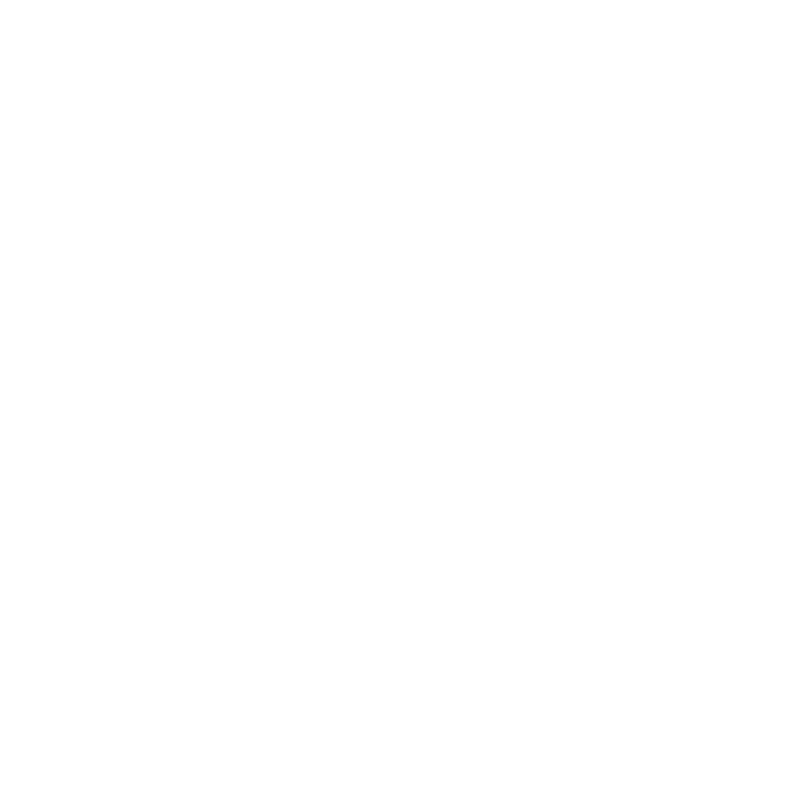

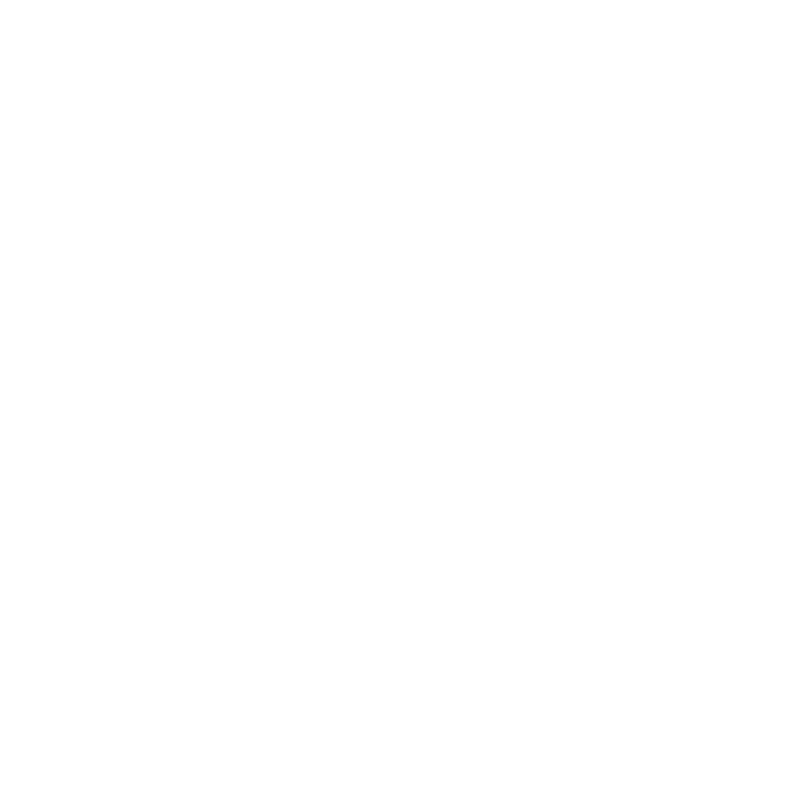

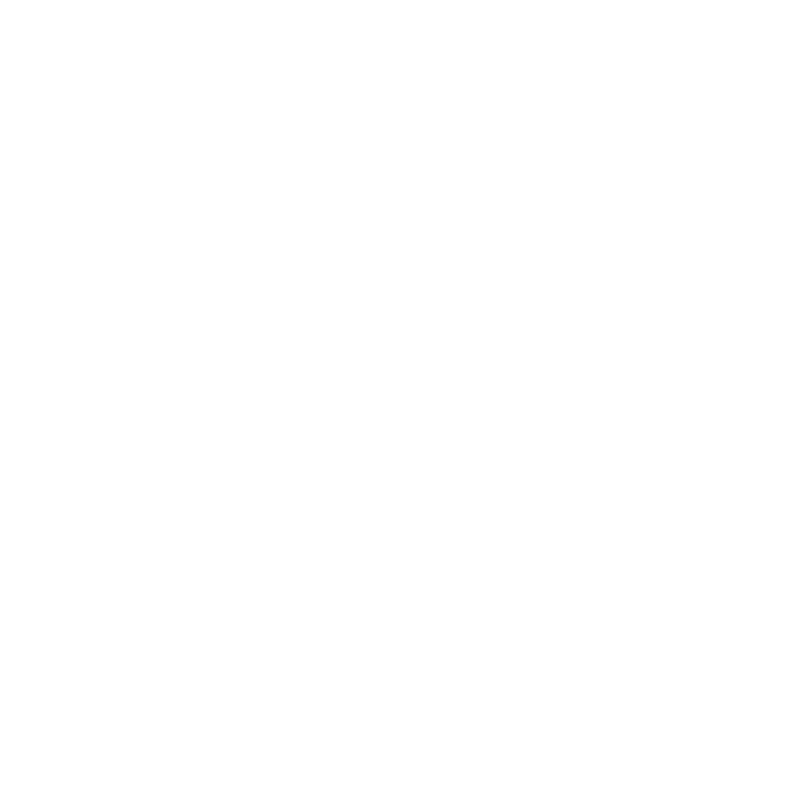

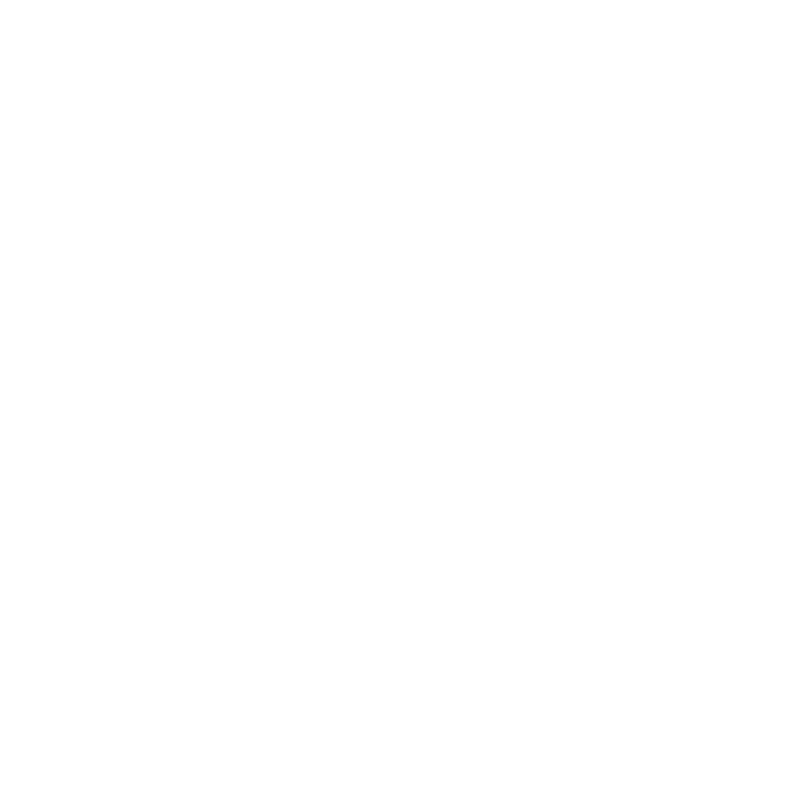

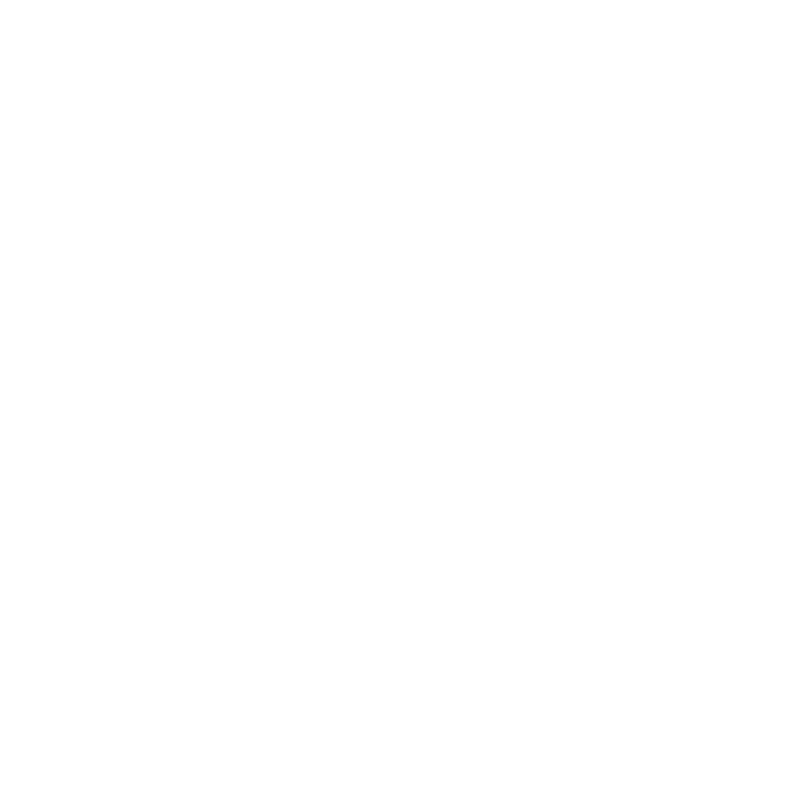

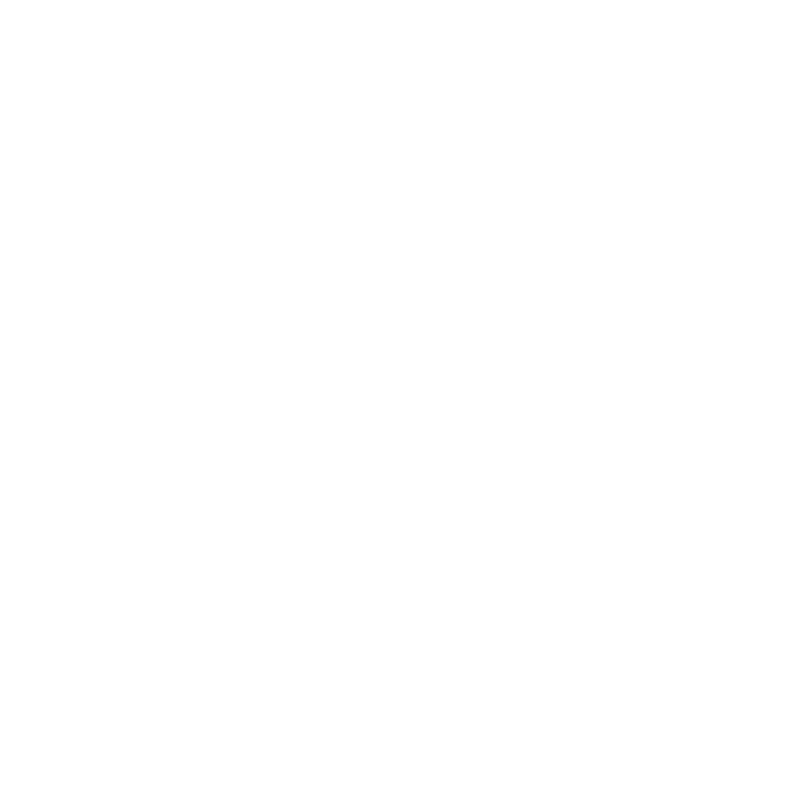

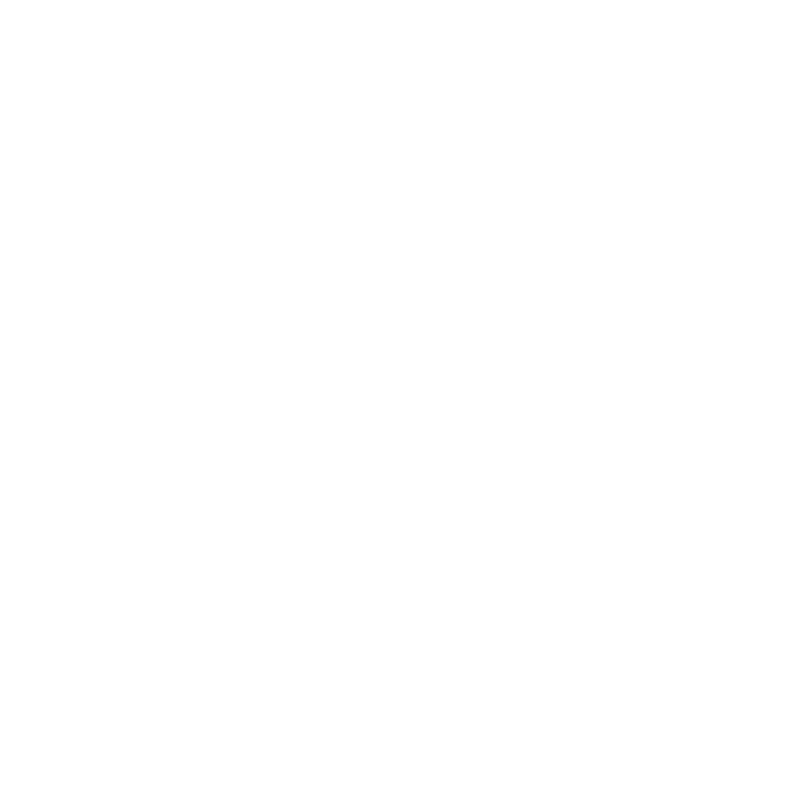

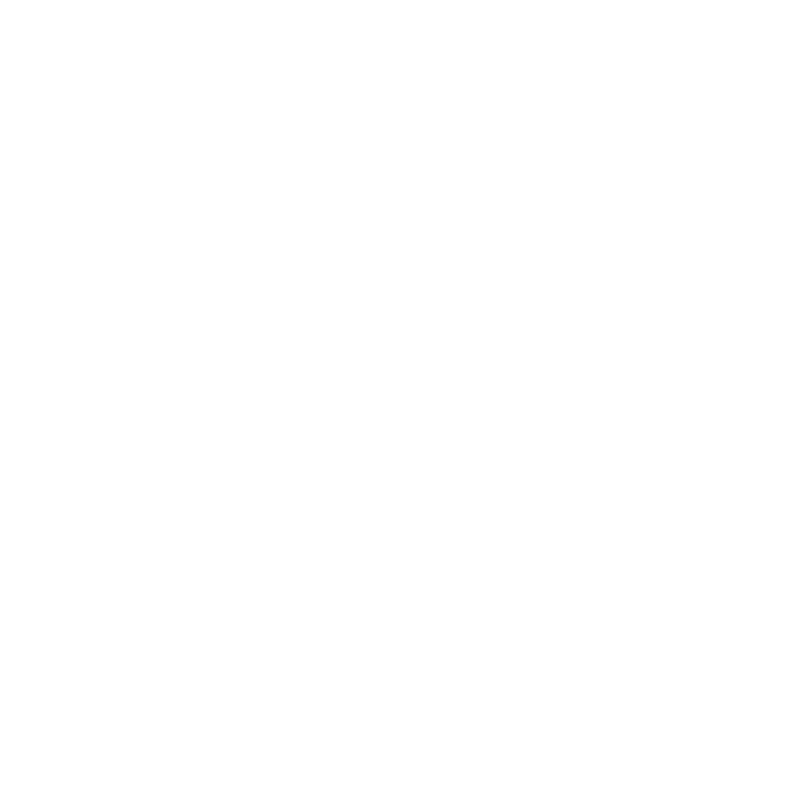

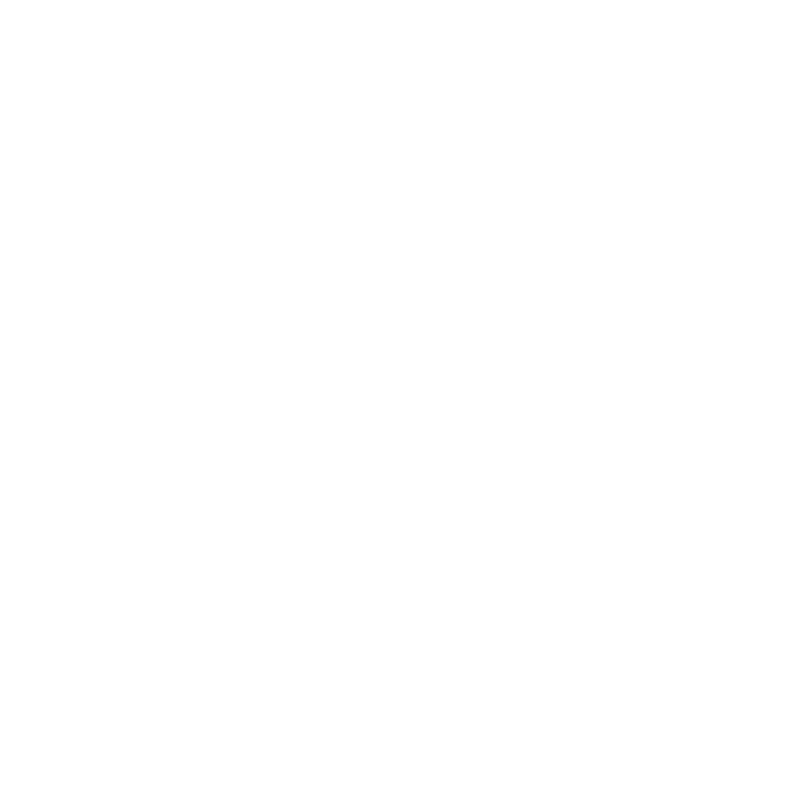

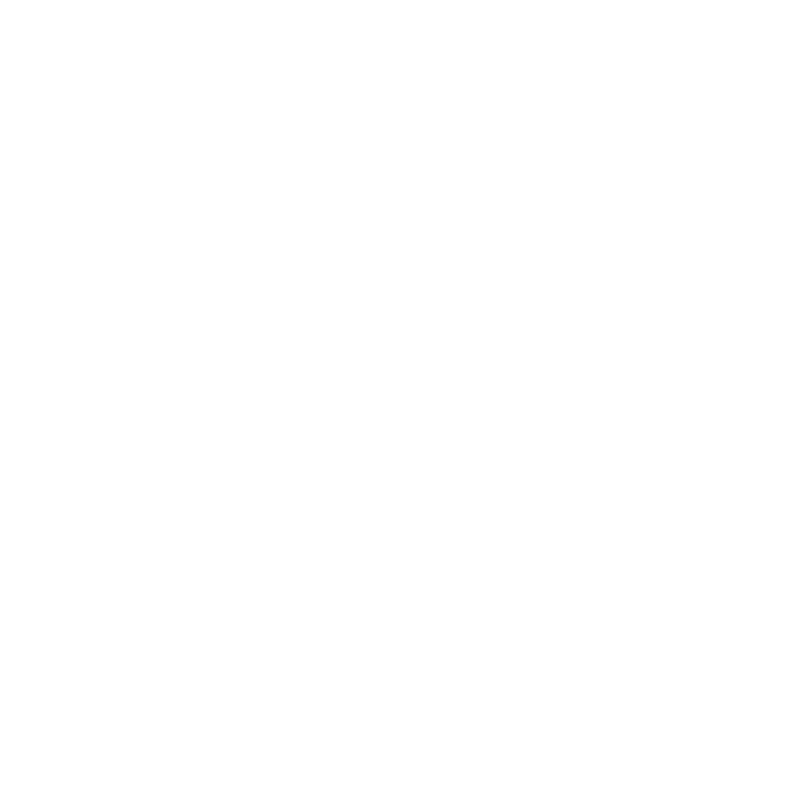

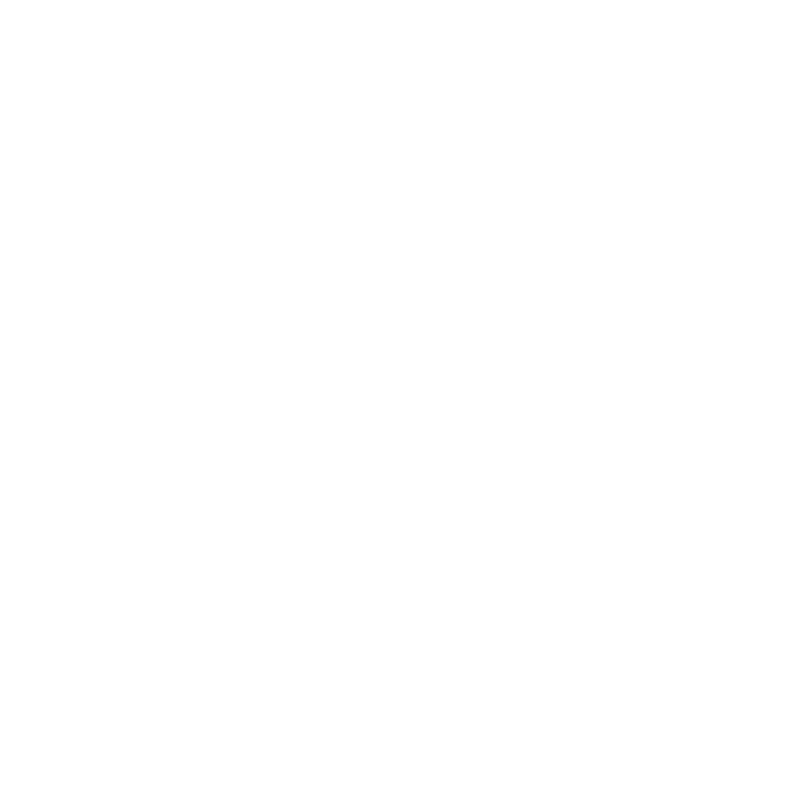

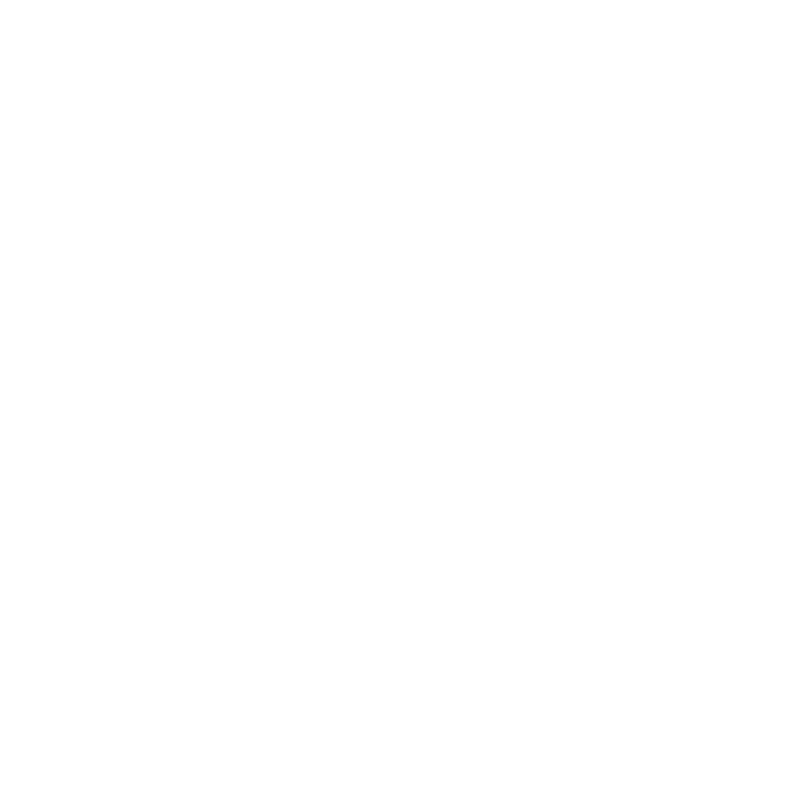

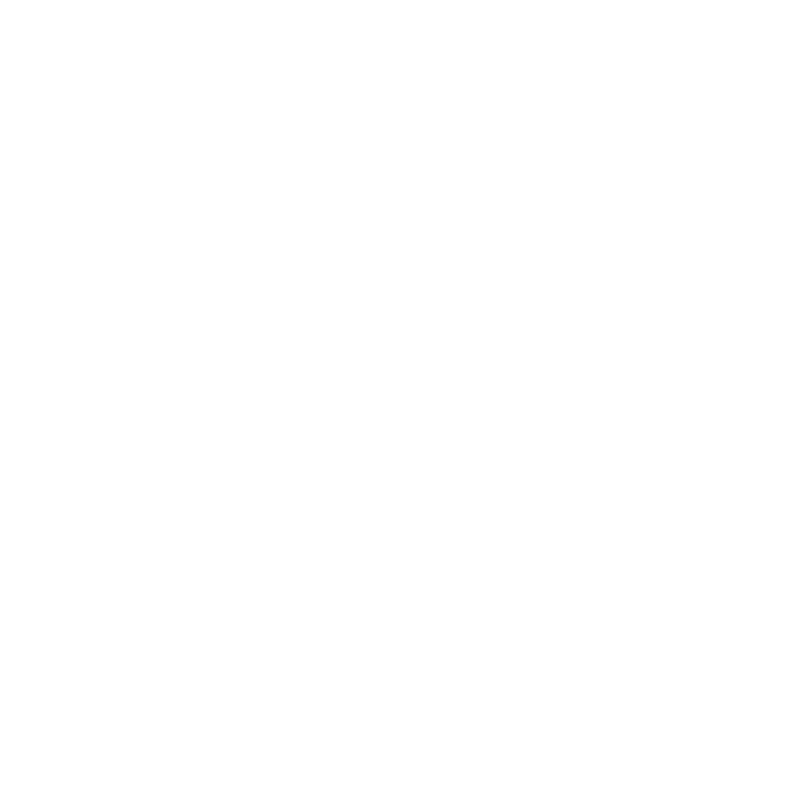

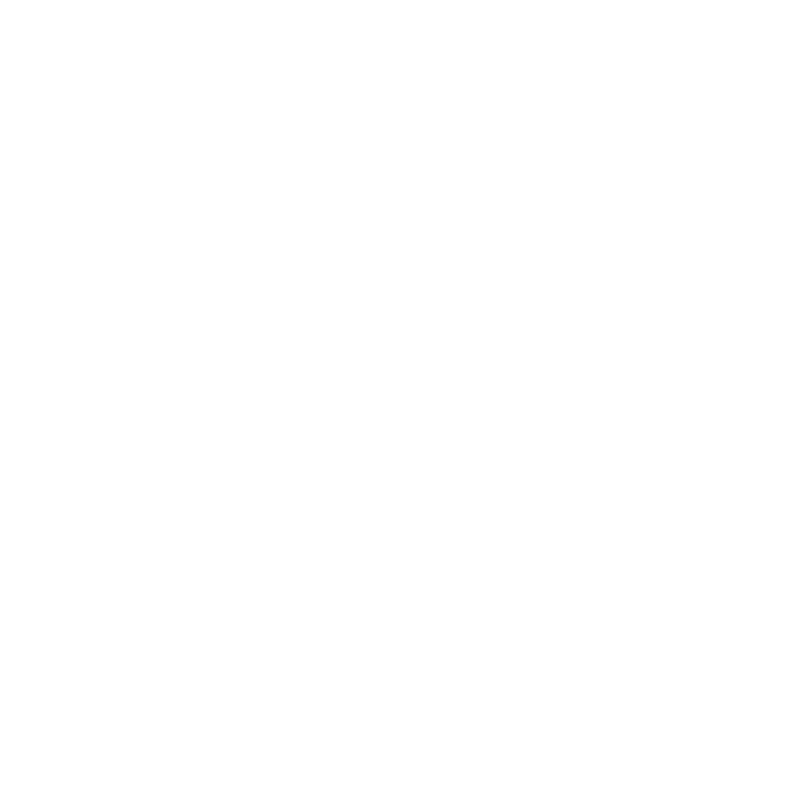

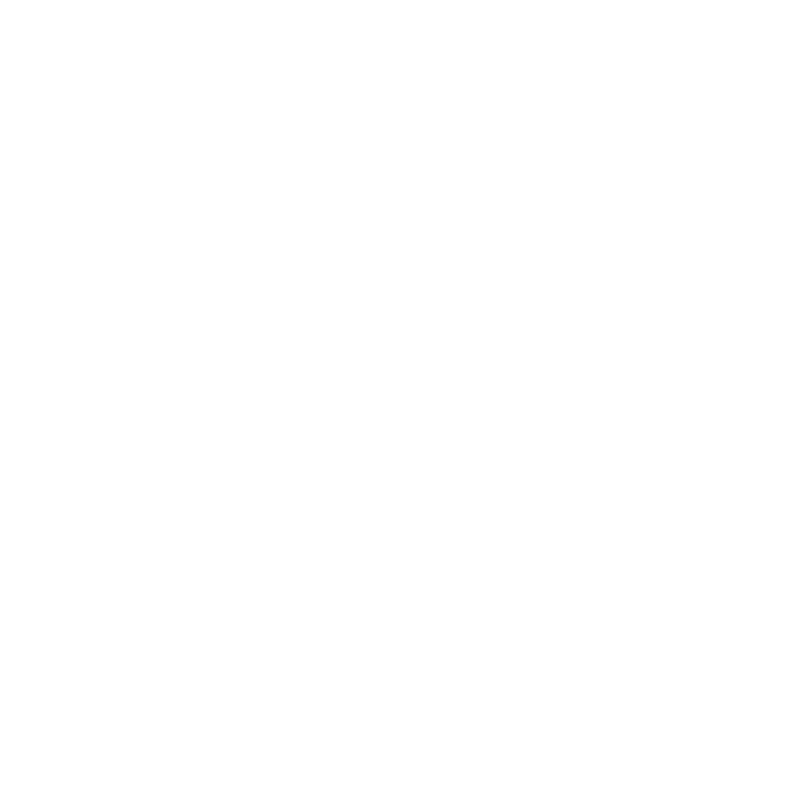

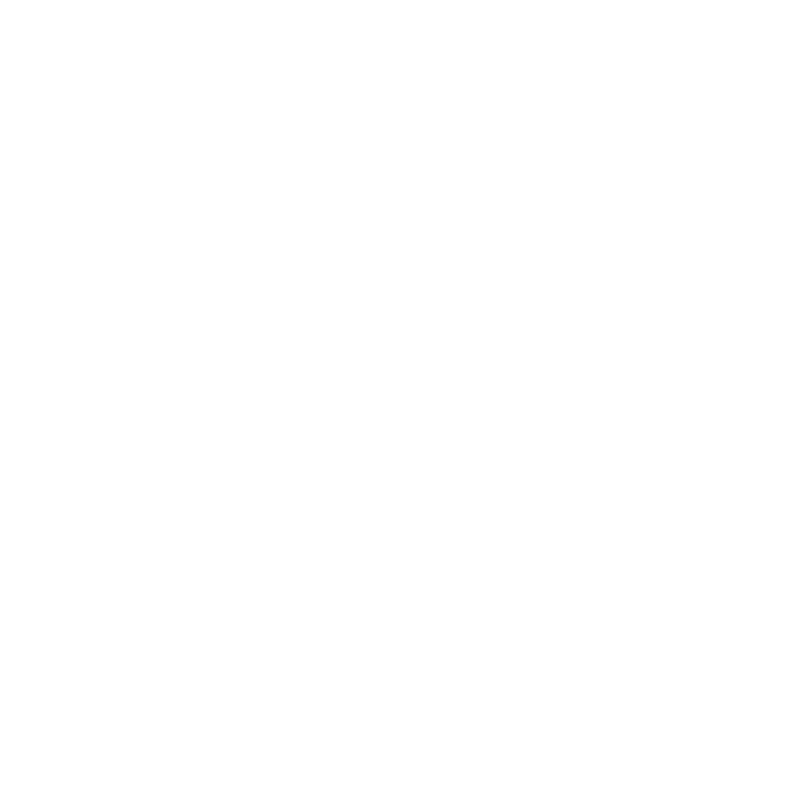

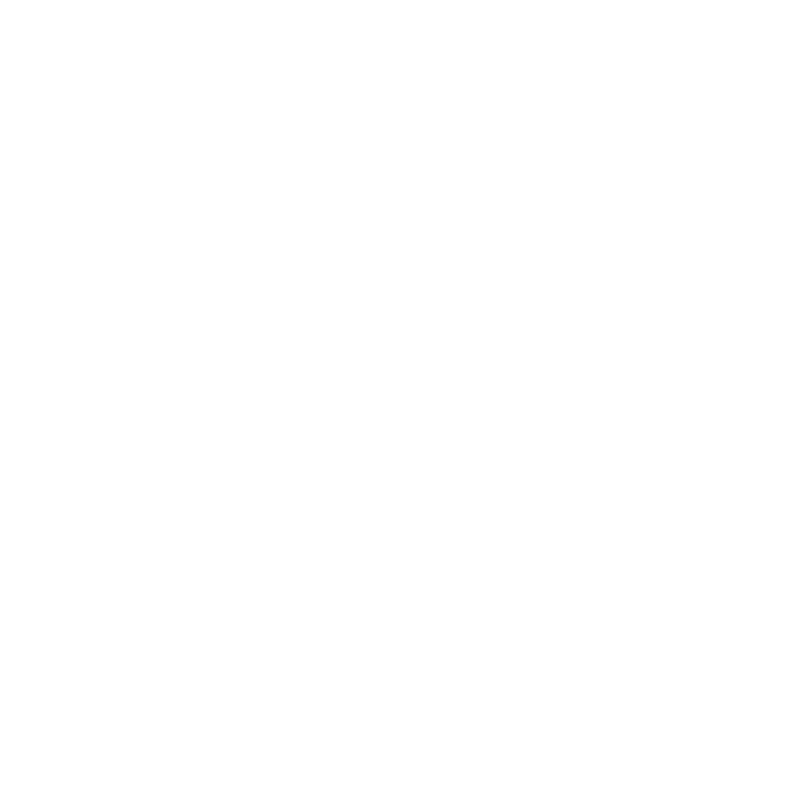

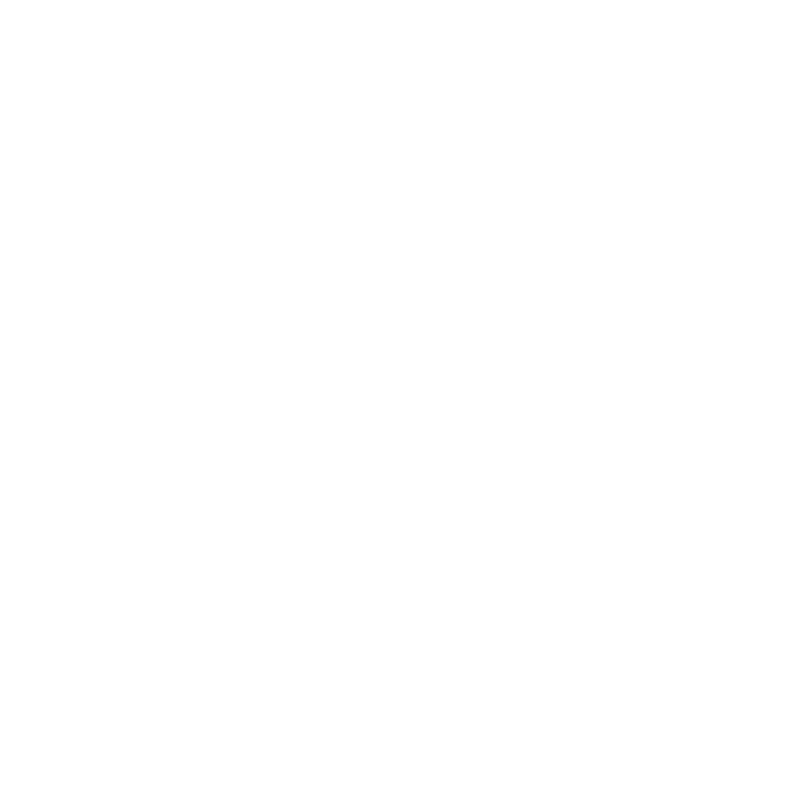

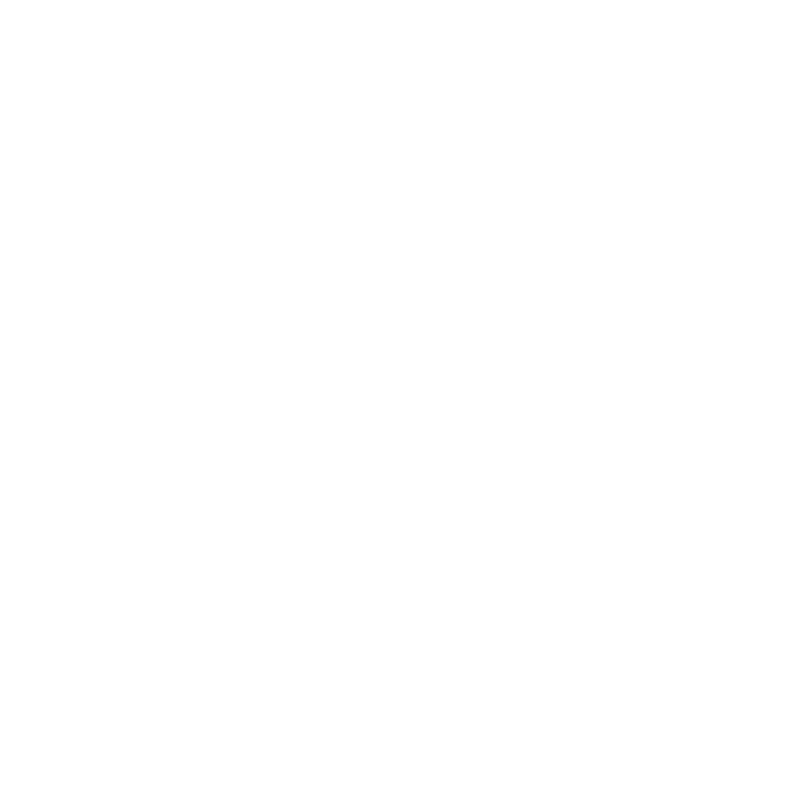

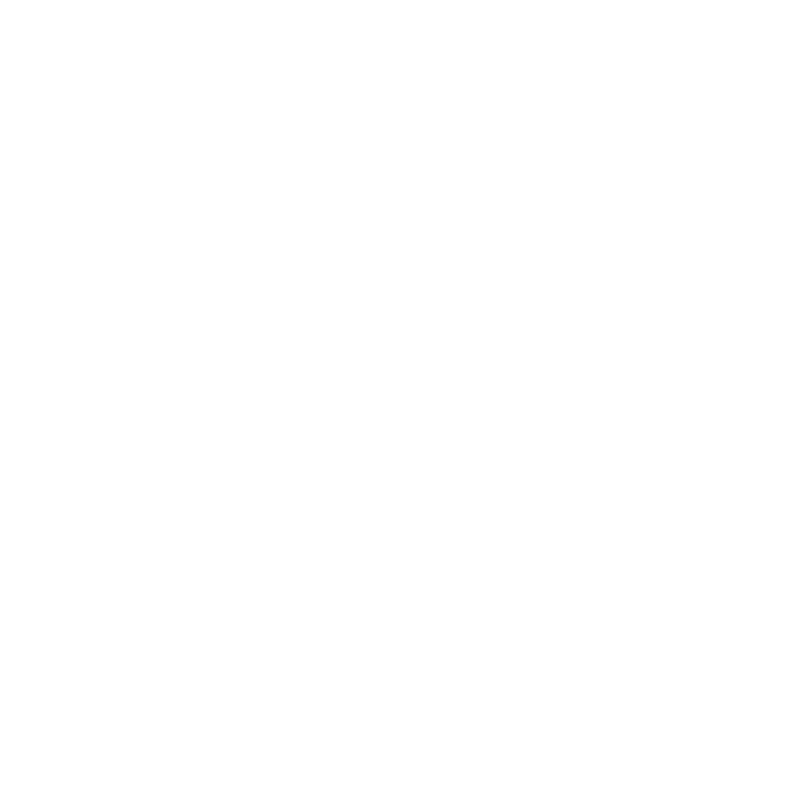

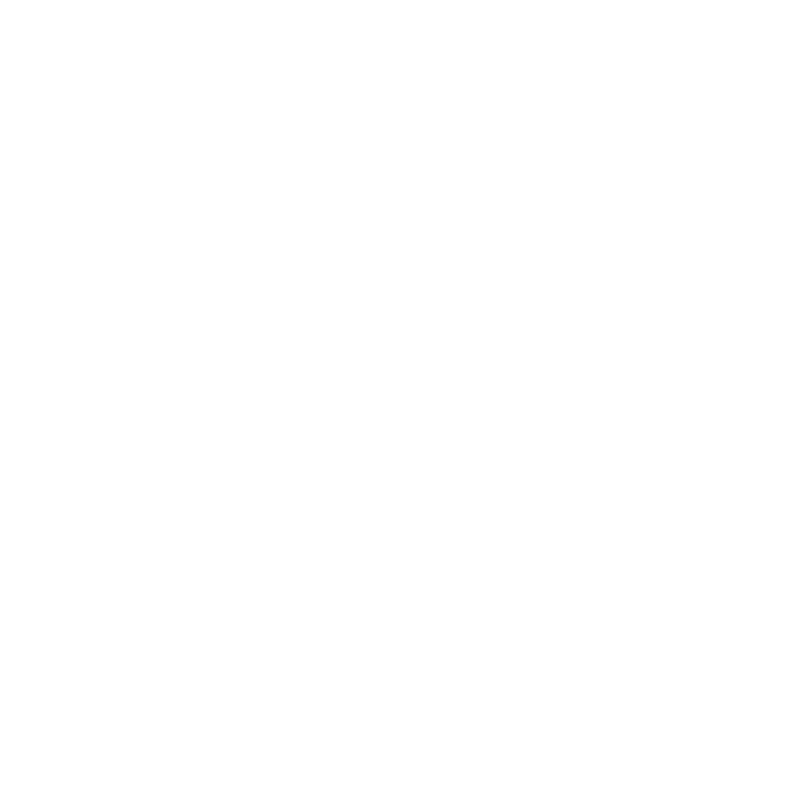

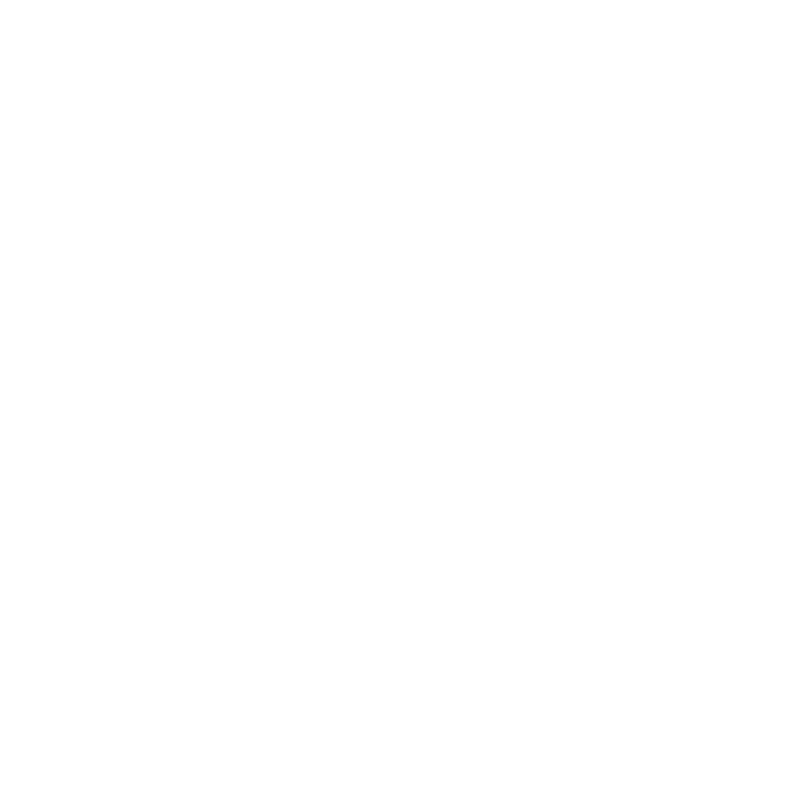

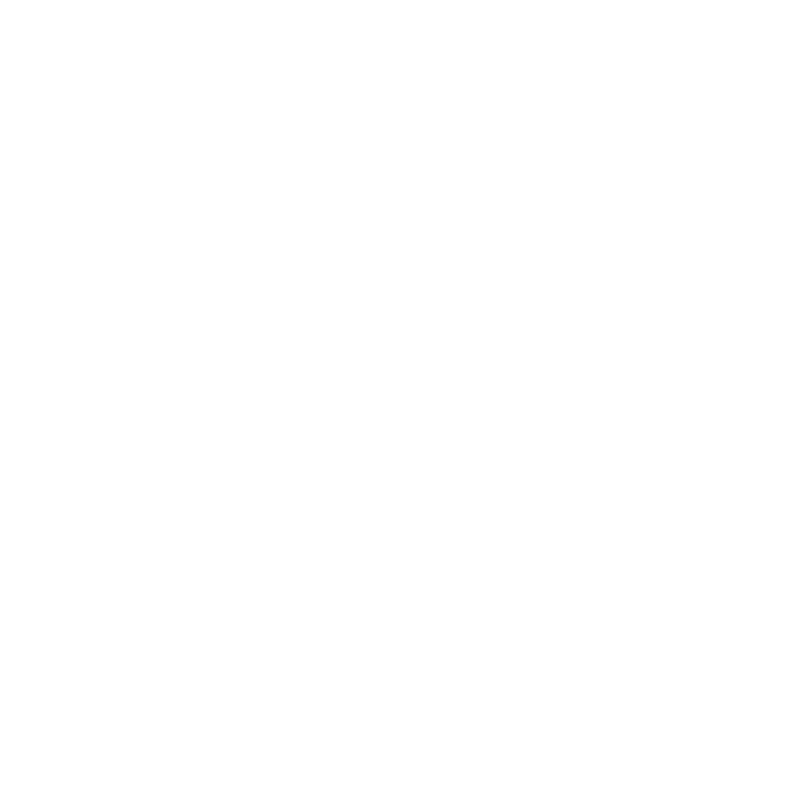

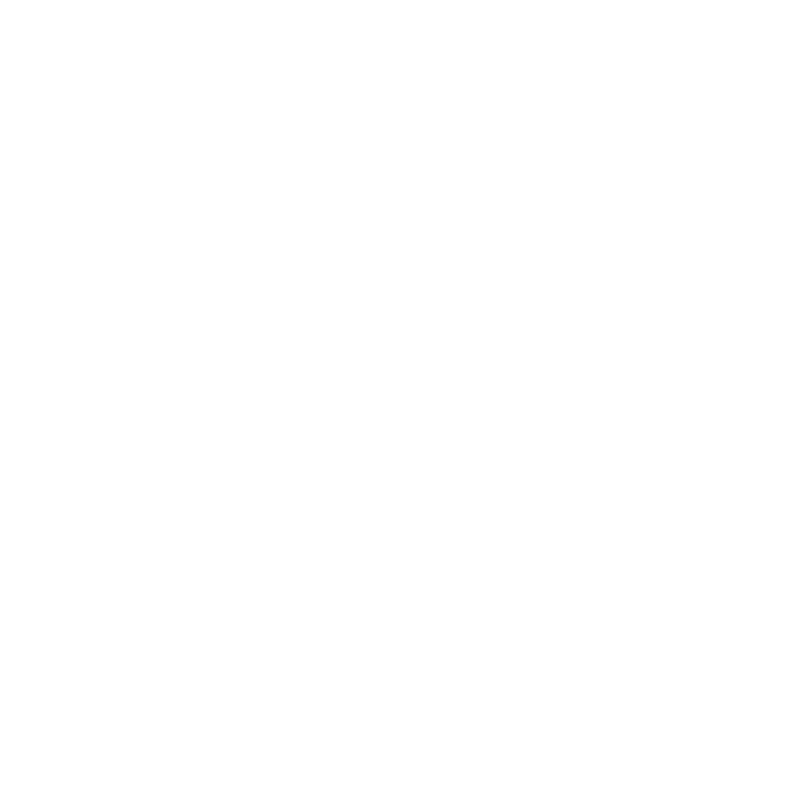

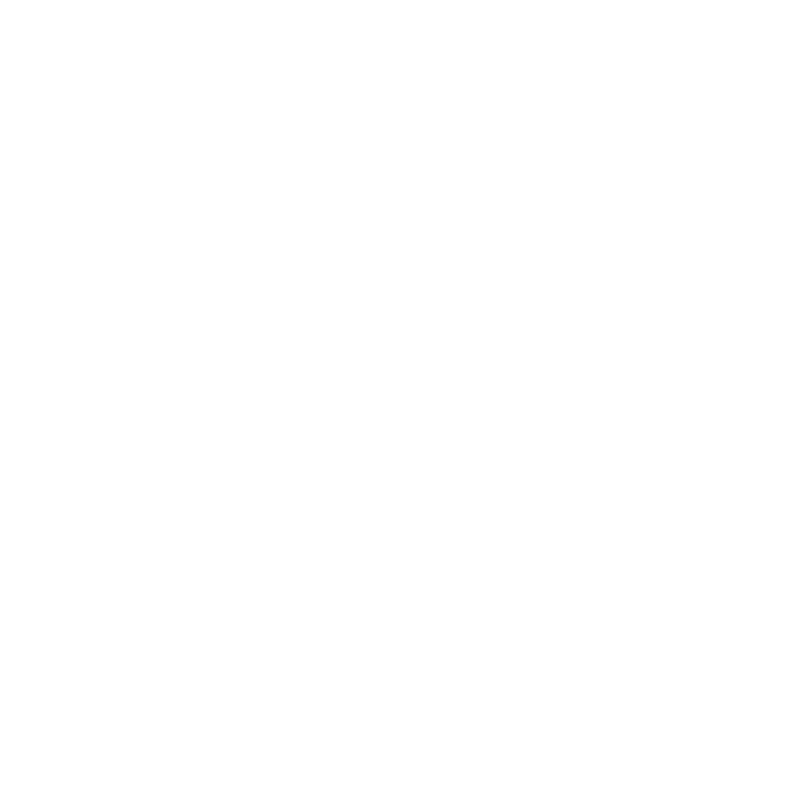

In [ ]:
# Progress bars that render well both in terminals and notebooks
from tqdm.auto import tqdm

# Build a dict of RGB colors from Matplotlib CSS color names
rgb_colors={}
for name, hex in matplotlib.colors.cnames.items():
    rgb_colors[name] = matplotlib.colors.to_rgb(hex)

# Ensure output directory exists
if os.path.isdir(path_mask_color_filter)==False:
  os.mkdir(path_mask_color_filter)

# Iterate over algorithm subfolders (outer progress bar)
for file_algo in tqdm(os.listdir(path_mask_filter), desc="Algorithms", unit="alg", position=0, leave=True):
 # Create the corresponding output subfolder if missing
 if os.path.isdir(path_mask_color_filter+file_algo)==False:
  os.mkdir(path_mask_color_filter+file_algo)

 # Iterate over mask files for this algorithm (inner progress bar)
 for file_mask in tqdm(os.listdir(path_mask_filter+file_algo), desc=f"{file_algo}", unit="img", position=1, leave=False):
  # Load the mask as a NumPy array
  mask= np.array(Image.open(path_mask_filter+file_algo+"/"+file_mask))

  # Label connected components (background=0); connectivity matches the mask dimensionality
  label=ski.measure.label(mask,connectivity=mask.ndim)

  # Collect region measurements into a DataFrame
  # Note: "coords" contains all pixel coordinates for each labeled object
  df_mask=ski.measure.regionprops_table(
      label,
      intensity_image=mask,
      properties=["area","coords","equivalent_diameter_area","bbox","axis_major_length","axis_minor_length","centroid"]
  )
  df_mask=pd.DataFrame(df_mask)

  # Prepare an empty RGB canvas where colored objects will be drawn
  crop_iou=np.zeros((mask.shape[0],mask.shape[1],3))

  # Iterate over detected objects (innermost progress bar)
  for i in tqdm(range(df_mask.shape[0]), desc="Objects", unit="obj", position=2, leave=False):
    # Pick a random color from the palette
    color=list(rgb_colors.values())[np.random.randint(len(rgb_colors))]

    # Keep objects based on size threshold (as in your original code)
    if df_mask.loc[i,"area"]>min_size or df_mask.loc[i,"area"]<max_size:
     # Paint all pixels belonging to this object with the chosen color
     for p in df_mask.loc[i,"coords"]:
        crop_iou[p[0],p[1]]=color

  # Render and save a borderless figure of the colorized mask
  plt.figure(figsize=(10,10))
  plt.axis('off')
  plt.imsave(path_mask_color_filter+file_algo+"/"+file_mask[:-4]+".png",crop_iou)
print("✅ Folder with color masks available there: "+ path_mask_color_filter)


#### Images with all the filtered objects

In [ ]:
# ------------------------- Configuration -------------------------
min_size = int(min_size)
max_size = int(max_size)

rgb_colors = {name: matplotlib.colors.to_rgb(hex_) for name, hex_ in matplotlib.colors.cnames.items()}
palette = np.array(list(rgb_colors.values()), dtype=np.float32)

rng = np.random.default_rng()

os.makedirs(path_obj_color_filter, exist_ok=True)

# ------------------------- Processing with ONE progress bar -------------------------
algos = sorted([d for d in os.listdir(path_mask)
                if os.path.isdir(os.path.join(path_mask, d))])

# Total number of images across all algorithms
total_files = sum(len(os.listdir(os.path.join(path_mask, algo))) for algo in algos)

with tqdm(total=total_files, desc="Processing masks", unit="img") as pbar:
    for file_algo in algos:
        src_dir = os.path.join(path_mask, file_algo)
        dst_dir = os.path.join(path_obj_color_filter, file_algo)
        os.makedirs(dst_dir, exist_ok=True)

        files = sorted([f for f in os.listdir(src_dir)
                        if os.path.isfile(os.path.join(src_dir, f))])

        for file_mask in files:
            src_path = os.path.join(src_dir, file_mask)
            out_path = os.path.join(dst_dir, f"{os.path.splitext(file_mask)[0]}.png")

            # Load mask
            mask = np.array(Image.open(src_path))
            H, W = mask.shape[:2]

            # Compute object sizes
            labels, counts = np.unique(mask, return_counts=True)
            valid = labels != 0
            labels = labels[valid]
            counts = counts[valid]

            # Select labels OUTSIDE the interval [min_size, max_size]
            keep_labels = labels[(counts > max_size) | (counts < min_size)]

            # Create empty RGB canvas
            color_img = np.zeros((H, W, 3), dtype=np.float32)

            if keep_labels.size > 0:
                rnd_idx = rng.integers(0, len(palette), size=keep_labels.size)
                keep_colors = palette[rnd_idx]

                for lab, col in zip(keep_labels, keep_colors):
                    color_img[mask == lab] = col

            # Save result
            plt.imsave(out_path, color_img)

            # Update ONE progress bar
            pbar.update(1)
print("✅ Folder with color objects available there: "+ path_obj_color_filter)

Processing masks:   0%|          | 0/92 [00:00<?, ?img/s]

✅ Folder with color objects available there: /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/obj_color_filtered/


## Combine algorithms to select bigest cells
Possibility to combine two predictions.
for each mask it chooses the biggest between the two algorithm

In [ ]:
list_algo=input("Enter the two algorithms you want to combine separated by a space: ").split()

Enter the two algorithms you want to combine separated by a space: mesmer cellposev3


In [ ]:
 path_mask_filter=path_segmentation_cells+"mask_filtered/"
 path_mask_combine=path_segmentation_cells+"mask_filtered/combine_"+list_algo[0]+"_"+list_algo[1]+"/"
 if os.path.isdir(path_mask_combine)==False:
    os.mkdir(path_mask_combine)
    print("✅ Folder for combined mask created")
 path_mask_color_combine=path_segmentation_cells+"mask_color_filtered/combine_"+list_algo[0]+"_"+list_algo[1]+"/"
 if os.path.isdir(path_mask_color_combine)==False:
    os.mkdir(path_mask_color_combine)
    print("✅ Folder for color combined masks created")

#### Combinaison

In [ ]:

# Ensure the output folder exists
os.makedirs(path_mask_combine, exist_ok=True)

# Build input folders and list files from the first algorithm
algo1_dir = os.path.join(path_mask_filter, list_algo[0])
algo2_dir = os.path.join(path_mask_filter, list_algo[1])
file_list = sorted(os.listdir(algo1_dir))

# Iterate over all mask files with a progress bar
for file_mask in tqdm(file_list, total=len(file_list), desc="Combining masks", unit="img"):
    # --- Load masks as numpy arrays
    mask1 = np.array(Image.open(os.path.join(algo1_dir, file_mask)))
    mask2 = np.array(Image.open(os.path.join(algo2_dir, file_mask)))

    # Output mask initialized to background, plus a running object id counter
    mask3 = np.zeros_like(mask1)
    obj3 = 1  # next object id to assign in mask3

    # --- Merge pass: for each object in mask1 (skip background id 0)
    for obj1 in np.unique(mask1):
        if obj1 == 0:
            continue

        # Labels from mask2 that overlap the current region in mask1
        overlap_pixels = mask2[mask1 == obj1]
        overlap_labels = [val for val in overlap_pixels if val > 0]

        if overlap_labels:
            # Most frequent overlapping label in mask2 (statistical mode)
            obj2 = mode(overlap_labels)

            # Binary regions for IoU and area calculations
            region1 = mask1 == obj1
            region2 = mask2 == obj2

            # Intersection-over-Union (IoU) between obj1 and its best match obj2
            intersection = np.logical_and(region1, region2).sum()
            union = np.logical_or(region1, region2).sum()
            iou = intersection / union if union > 0 else 0.0

            # Areas (in pixels) for both regions
            area1 = region1.sum()
            area2 = region2.sum()

            if iou >= 0.4:
                # Strong match: keep the larger region
                if area1 >= area2:
                    mask3[region1] = obj3
                else:
                    mask3[region2] = obj3
                obj3 += 1
            else:
                # Weak match: keep obj1 only
                mask3[region1] = obj3
                obj3 += 1
        else:
            # No overlap at all: copy obj1 to the output
            region1 = mask1 == obj1
            mask3[region1] = obj3
            obj3 += 1

    # --- Second pass: add objects that exist only in mask2 (no overlap with mask1)
    for obj2 in np.unique(mask2):
        if obj2 == 0:
            continue
        if np.sum(mask1[mask2 == obj2]) == 0:
            mask3[mask2 == obj2] = obj3
            obj3 += 1

    # --- Save the combined mask
    out_path = os.path.join(path_mask_combine, file_mask)
    Image.fromarray(mask3.astype(np.uint8)).save(out_path)


Combining masks:   0%|          | 0/23 [00:00<?, ?img/s]

#### Colored masks

In [ ]:

rgb_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
rgb_colors = [mcolors.to_rgb(c) for c in rgb_colors]

def random_color():
    return rgb_colors[np.random.randint(0, len(rgb_colors))]

for file_img in os.listdir(path_mask_combine):

    print(file_img)

    mask = np.array(Image.open(os.path.join(path_mask_combine, file_img)))
    label=ski.measure.label(mask,connectivity=mask.ndim)
    df_mask=ski.measure.regionprops_table(label,intensity_image=mask,properties=["area","coords","equivalent_diameter_area","bbox","axis_major_length","axis_minor_length","centroid"])
    df_mask=pd.DataFrame(df_mask)

    crop_iou = np.zeros((*mask.shape, 3), dtype=np.float32)

    obj_colors = [random_color() for _ in range(len(df_mask))]

    for i, coords in enumerate(df_mask["coords"]):
        coord_array = np.array(coords)
        crop_iou[coord_array[:, 0], coord_array[:, 1]] = obj_colors[i]

    imsave(os.path.join(path_mask_color_combine, file_img[:-4] + ".png"),crop_iou)
    plt.close()
print("✅ Folder with color masks available there: "+ path_mask_color_combine)


19U08731 a.tif
19U08731 b.tif
19U08731 c.tif
19U08731 d.tif
19U08731 e.tif
19U08731 f.tif
19U08731 g.tif
20U03813 a.tif
20U03813 b.tif
20U03813 c.tif
20U09477 a.tif
20U09477 b.tif
20U09477 c.tif
21U01570 a.tif
21U01570 b.tif
21U01570 c.tif
21U01570 d.tif
21U01570 e.tif
21U01570 f.tif
21U01570 g.tif
21U02147 a.tif
21U05395 a.tif
21U05395 b.tif
✅ Folder with color masks available there: /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/mask_color_filtered/combine_mesmer_cellposev3/


# Assessment without a ground truth

In [ ]:
path_eval=path_segmentation_cells+"Evaluation_segmentation/"
path_eval_quali=path_eval+"segmentation_quality/"
path_eval_quali_without_truth=path_eval_quali+"assessment_without_ground_truth/"
path_eval_mask_outline=path_eval_quali_without_truth+"mask_outline/"
path_mask=path_segmentation_cells+"mask_filtered/"
if os.path.isdir(path_eval)==False:
 os.mkdir(path_eval)
if os.path.isdir(path_eval_quali)==False:
 os.mkdir(path_eval_quali)
if os.path.isdir(path_eval_quali_without_truth)==False:
  os.mkdir(path_eval_quali_without_truth)
if os.path.isdir(path_eval_mask_outline)==False:
  os.mkdir(path_eval_mask_outline)

### Number of object

#### Functions

In [ ]:
def mask_to_df(path_mask):
   mask= np.array(Image.open(path_mask))
   label=ski.measure.label(mask,connectivity=mask.ndim)
   df_mask=ski.measure.regionprops_table(label,intensity_image=mask,properties=["area","coords","equivalent_diameter_area","bbox","axis_major_length","axis_minor_length","centroid"])
   df_mask=pd.DataFrame(df_mask)
   return df_mask


In [ ]:
def distribution_number_object(
    path_img="./img",
    path_mask="./mask",
    path_file="./segmentation_quality/",
    dico_algo_min={},
    dico_algo_max={},
    title=""
):
    """
    Build per-image object counts for each algorithm's masks and plot:
      1) grouped bar chart (images on X, counts on Y, one bar per algorithm)
      2) distribution plot across algorithms (box + swarm)

    Optimizations:
    - Stable, shared X-axis: we compute a common, sorted list of filenames across algorithms.
    - Fewer directory scans and safer path handling with os.path.join.
    - Clean progress bars at two levels: algorithms and images.
    """

    # --------------------------- Setup ---------------------------
    os.makedirs(path_file, exist_ok=True)  # ensure output folder exists

    # List subfolders in path_mask as algorithms
    algos = sorted([d.name for d in os.scandir(path_mask) if d.is_dir()])
    if not algos:
        raise RuntimeError(f"No algorithm subfolders found in '{path_mask}'.")

    # Build a common (intersection) sorted list of image filenames to ensure
    # every algorithm is evaluated on the same set and in the same order.
    file_sets = []
    for algo in algos:
        algo_dir = os.path.join(path_mask, algo)
        files = {f.name for f in os.scandir(algo_dir) if f.is_file()}
        file_sets.append(files)

    if file_sets:
        common_files = sorted(set.intersection(*file_sets))  # intersection across algos
    else:
        common_files = []

    if not common_files:
        # Fallback: use files from the first algorithm (keeps behavior closer to original)
        first_dir = os.path.join(path_mask, algos[0])
        common_files = sorted([f.name for f in os.scandir(first_dir) if f.is_file()])

    # Dictionary to collect counts per algorithm (kept for plotting)
    dico_algo_nb = {algo: [] for algo in algos}

    # --------------------------- Compute counts (with progress bars) ---------------------------
    # Outer bar: algorithms
    for algo in tqdm(algos, desc="Algorithms", unit="alg", position=0, leave=True):
        algo_dir = os.path.join(path_mask, algo)

        # Inner bar: images for current algorithm
        for file_mask in tqdm(common_files, desc=f"{algo}", unit="img", position=1, leave=False):
            mask_path = os.path.join(algo_dir, file_mask)

            # Keep original logic: if min/max dicts provided and algo != "truth", pass thresholds
            if dico_algo_max and dico_algo_min and algo != "truth":
                df = mask_to_df(mask_path, dico_algo_min.get(algo), dico_algo_max.get(algo))
            else:
                df = mask_to_df(mask_path)

            # Number of objects for this image in this algorithm
            dico_algo_nb[algo].append(df.shape[0])

    # --------------------------- Plot 1: Grouped bar chart ---------------------------
    n_algos = len(algos)
    n_imgs = len(common_files)
    if n_imgs == 0:
        raise RuntimeError("No images found to plot.")

    # Compute bar positions: pack bars for each image tightly with 0.8 total width
    width = 0.8 / n_algos
    x_base = np.arange(n_imgs)

    # Wider figure when many images; otherwise keep it readable
    plt.figure(figsize=(max(12, n_imgs * 0.5), 8))

    for i, algo in enumerate(algos):
        x_positions = x_base + i * width
        plt.bar(x_positions, dico_algo_nb[algo], label=algo, width=width)

    # Center x-ticks under grouped bars
    tick_positions = x_base + width * (n_algos - 1) / 2
    plt.title((f"{title}" if title else ""), fontsize=20)
    plt.ylabel("Number of objects", fontsize=16)
    plt.xlabel("Images", fontsize=16)
    plt.xticks(tick_positions, common_files, rotation=60, ha="right")
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Save bar chart
    bar_out = os.path.join(path_file, title if title else "number_of_objects.png")
    plt.savefig(bar_out, dpi=200)
    plt.close()

    # --------------------------- Plot 2: Box + swarm distribution ---------------------------
    # Build a long-form DataFrame for seaborn
    rows = []
    for algo in algos:
        for count in dico_algo_nb[algo]:
            rows.append({"Algorithm": algo, "Objects": count})
    df_plot = pd.DataFrame(rows)
    tab20_distinct = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#17BECF", "#BCBD22", "#E377C2", "#7F7F7F", "#8C564B",
    ]
    plt.figure(figsize=(max(12, n_algos * 2), 6))
    # Swarm first (points), then box (summary). Reverse if you prefer boxes under points.
    sns.swarmplot(data=df_plot, x="Algorithm", y="Objects", color="black", size=3)
    sns.boxplot(data=df_plot, x="Algorithm", y="Objects", showmeans=True,palette=tab20_distinct)
    plt.title("Average" + (f"{title}" if title else ""), fontsize=14)
    plt.ylabel("Number of objects", fontsize=12)
    plt.xlabel("Algorithm", fontsize=12)
    plt.tight_layout()

    box_out = os.path.join(path_file, f"mean_{title}" if title else "mean_number_of_objects.png")
    plt.savefig(box_out, dpi=200)
    plt.close()
    print("✅ files created : "+path_file)



#### Execution

In [ ]:
distribution_number_object(path_img_raw,path_mask,path_eval_quali_without_truth,title="Number of object")


Algorithms: 100%|██████████| 4/4 [01:38<00:00, 24.54s/alg]
/tmp/ipython-input-4220386289.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, x="Algorithm", y="Objects", showmeans=True,palette=tab20_distinct)
/tmp/ipython-input-4220386289.py:112: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(data=df_plot, x="Algorithm", y="Objects", showmeans=True,palette=tab20_distinct)


✅ files created : /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/Evaluation_segmentation/segmentation_quality/assessment_without_ground_truth/


### Object size distribution

#### Functions

In [ ]:
def size_distribution(
    path_mask: str = "./mask",
    path_file: str = "./segmentation_quality",
    dico_algo_min: dict = {},
    dico_algo_max: dict = {},
    title: str = "size_distribution.png"
):
    """
    Build an overlaid histogram of object sizes (pixel areas) for each algorithm's masks.

    - Scans each algorithm subfolder under `path_mask`.
    - For each image, calls `mask_to_df(...)` to obtain per-object measurements (expects an 'area' column).
    - Aggregates all 'area' values per algorithm and plots them together.
    - Saves the figure to `path_file/title`.

    Progress:
      - Outer tqdm: algorithms
      - Inner tqdm: images per algorithm

    Legend:
      - Stable order matching the sorted algorithm list.
      - Stable, consistent colors (tab20 if <=20 algos; otherwise husl).
      - Custom legend ensuring only algorithm names appear (no duplicates).

    Parameters
    ----------
    path_mask : str
        Root folder containing one subfolder per algorithm (e.g., ".../mask/algoname/*.png").
    path_file : str
        Output folder for the plot.
    dico_algo_min : dict
        Optional dict mapping algorithm -> min size threshold for `mask_to_df`.
    dico_algo_max : dict
        Optional dict mapping algorithm -> max size threshold for `mask_to_df`.
    title : str
        Output filename for the saved figure.

    Returns
    -------
    dict
        Dictionary {algorithm: [area1, area2, ...]} with all collected areas.
    """

    # ---------- Setup & safety ----------
    os.makedirs(path_file, exist_ok=True)

    # Sorted algorithm subfolders for stable order and colors
    algos = sorted(
        d for d in os.listdir(path_mask)
        if os.path.isdir(os.path.join(path_mask, d))
    )
    if not algos:
        raise RuntimeError(f"No algorithm subfolders found in '{path_mask}'")

    # Prepare container for all sizes per algorithm
    dico_algo_size = {algo: [] for algo in algos}

    # ---------- Collect areas with progress bars ----------
    for algo in tqdm(algos, desc="Algorithms", unit="alg", position=0, leave=True):
        algo_dir = os.path.join(path_mask, algo)
        files = sorted(
            f for f in os.listdir(algo_dir)
            if os.path.isfile(os.path.join(algo_dir, f))
        )

        for name_img in tqdm(files, desc=f"{algo}", unit="img", position=1, leave=False):
            mask_path = os.path.join(algo_dir, name_img)

            # Keep original threshold logic:
            # Only pass (min,max) if both dicts exist AND algo != "truth" AND keys are present
            if dico_algo_min and dico_algo_max and algo != "truth" \
               and (algo in dico_algo_min) and (algo in dico_algo_max):
                df_mask = mask_to_df(mask_path, dico_algo_min[algo], dico_algo_max[algo])
            else:
                df_mask = mask_to_df(mask_path)

            # Extend with all object areas from this image (expects 'area' column)
            if "area" in df_mask.columns:
                dico_algo_size[algo].extend(df_mask["area"].tolist())

    # ---------- Assemble long-form DataFrame for seaborn ----------
    df_plot = pd.DataFrame(
        [(algo, area) for algo, areas in dico_algo_size.items() for area in areas],
        columns=["Algorithm", "Area"]
    )

    if df_plot.empty:
        raise RuntimeError("No object areas were collected. Check your input masks and 'mask_to_df' output.")

    # ---------- Choose a stable palette ----------
    # If <=20 algorithms, use tab20 for crisp distinct colors; else fall back to 'husl' spanning the hue circle
    tab20_distinct = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#17BECF", "#BCBD22", "#E377C2", "#7F7F7F", "#8C564B",
    ]
    if len(algos) <= 20:
        palette =tab20_distinct
    else:
        palette = sns.color_palette("husl", n_colors=len(algos))

    # Map algorithm -> color to ensure the legend matches the bars/lines
    algo_to_color = {algo: palette[i] for i, algo in enumerate(algos)}

    # ---------- Plot: overlaid histograms with KDE and a clean legend ----------
    plt.figure(figsize=(20, 12))
    ax = plt.gca()
    ax.set_title("Mask object size distribution", fontsize=24)
    ax.set_xlabel("Size (pixels)", fontsize=18)
    ax.set_ylabel("Number of objects", fontsize=18)

    # Draw one hist per algorithm to keep full control of legend & colors
    # (This avoids duplicated or missing legend entries when using hue directly.)
    for algo in algos:
        if len(dico_algo_size[algo]) == 0:
            continue  # skip empty
        sns.histplot(
            dico_algo_size[algo],
            kde=True,
            element="step",
            stat="count",
            common_norm=False,
            bins="auto",
            ax=ax,
            color=algo_to_color[algo],
            label=algo
        )

    # Build a clean legend from our explicit labels (one per algorithm)
    # If many algorithms, place legend outside and split into columns.
    handles = [Patch(facecolor=algo_to_color[a], edgecolor="black", label=a) for a in algos]

    if len(algos) > 10:
        ncol = 2 if len(algos) <= 20 else 3
        ax.legend(
            handles=handles,
            title="Algorithms",
            loc="upper left",
            bbox_to_anchor=(1.02, 1.0),
            borderaxespad=0.0,
            frameon=True,
            fontsize=12,
            title_fontsize=12,
            ncol=ncol
        )
        # Make room on the right for the outside legend
        plt.tight_layout(rect=[0, 0, 0.8, 1])
    else:
        ax.legend(
            handles=handles,
            title="Algorithms",
            loc="upper right",
            frameon=True,
            fontsize=12,
            title_fontsize=12
        )
        plt.tight_layout()

    # ---------- Save & close ----------
    out_path = os.path.join(path_file, title)
    plt.savefig(out_path, dpi=200)
    print("✅ files created : "+str(path_file)+title)
    plt.close()

#### Execution

In [ ]:
size_distribution(path_mask,path_eval_quali_without_truth)

Algorithms: 100%|██████████| 4/4 [01:38<00:00, 24.53s/alg]


✅ files created : /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/Evaluation_segmentation/segmentation_quality/assessment_without_ground_truth/size_distribution.png


### Percentage of the DNA signal outside the cell

#### Function

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch


def percentage_in_out(
    list_marker=("DNA",),
    path_img="./images/raw_images",
    path_mask="./mask_roi",
    path_file="./"
):
    """
    Compute the percentage of marker intensity located inside segmentation masks.
    Produces:
        1) grouped bar chart per ROI
        2) boxplot + swarmplot per algorithm (color-coded)
           - legend outside (right)
           - mean value annotated above the max whisker
    """

    # ------------------------- Setup -------------------------
    os.makedirs(path_file, exist_ok=True)

    list_name_img = sorted([d.name for d in os.scandir(path_img) if d.is_dir()])
    algos = sorted([d.name for d in os.scandir(path_mask) if d.is_dir()])

    if not list_name_img:
        raise RuntimeError(f"No image folders found in '{path_img}'.")
    if not algos:
        raise RuntimeError(f"No algorithm folders found in '{path_mask}'.")

    dico_algo_in_out = {algo: [] for algo in algos}

    # ------------------------- Single progress bar -------------------------
    total_steps = len(algos) * len(list_name_img)

    with tqdm(total=total_steps, desc="Computing % in masks", unit="image", ncols=100) as pbar:
        for algo in algos:
            algo_dir = os.path.join(path_mask, algo)

            for name_img in list_name_img:
                mask_path = os.path.join(algo_dir, f"{name_img}.tif")
                if not os.path.isfile(mask_path):
                    dico_algo_in_out[algo].append(np.nan)
                    pbar.update(1)
                    continue

                mask = np.array(Image.open(mask_path))
                mask_in = mask > 0
                mask_out = ~mask_in

                sum_in = np.uint64(0)
                sum_out = np.uint64(0)

                for marker in list_marker:
                    img_path = os.path.join(path_img, name_img, f"{marker}.tiff")
                    if not os.path.isfile(img_path):
                        continue

                    img = np.array(Image.open(img_path))

                    # arcsinh + normalize_255 doivent exister dans ton environnement
                    img = normalize_255(np.arcsinh(img))

                    img_thr = img * (img > 150)

                    sum_in += img_thr[mask_in].sum(dtype=np.uint64)
                    sum_out += img_thr[mask_out].sum(dtype=np.uint64)

                denom = int(sum_in + sum_out)
                percent_in = (100 * sum_in / denom) if denom > 0 else 0.0
                dico_algo_in_out[algo].append(float(percent_in))

                pbar.update(1)

    # ------------------------- PLOT 1 : Grouped bar chart -------------------------
    n_imgs = len(list_name_img)
    for algo in algos:
        if len(dico_algo_in_out[algo]) < n_imgs:
            dico_algo_in_out[algo].extend([np.nan] * (n_imgs - len(dico_algo_in_out[algo])))

    plt.figure(figsize=(max(18, n_imgs * 0.7), 8))
    width = 0.8 / len(algos)
    x_base = np.arange(n_imgs)

    for i, algo in enumerate(algos):
        plt.bar(x_base + i * width, dico_algo_in_out[algo], width=width, label=algo)

    tick_pos = x_base + width * (len(algos) - 1) / 2
    plt.xticks(tick_pos, list_name_img, rotation=70, ha="right", fontsize=14)

    plt.ylabel("Percentage (%)", fontsize=16)
    plt.xlabel("Images", fontsize=16)
    plt.title("Percentage of marker intensity inside masks", fontsize=20)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(path_file, "percentage_marker_in.png"), dpi=200, bbox_inches="tight")
    plt.close()

    # ------------------------- PLOT 2 : Box + swarm -------------------------
    rows = []
    for algo in algos:
        for val in dico_algo_in_out[algo]:
            if not np.isnan(val):
                rows.append({"Algorithm": algo, "Percentage": val})

    df_plot = pd.DataFrame(rows)
    if df_plot.empty:
        print("⚠️ No data available for boxplot.")
        print("✔️ Files saved in:", path_file)
        return dico_algo_in_out

    palette = sns.color_palette("tab10", len(algos))
    algo_to_color = {algo: palette[i] for i, algo in enumerate(algos)}

    plt.figure(figsize=(max(14, len(algos) * 1.6), 8))

    sns.boxplot(
        data=df_plot,
        x="Algorithm",
        y="Percentage",
        order=algos,
        palette=algo_to_color,
        showmeans=True,
        meanprops=dict(
            marker="D",
            markerfacecolor="white",
            markeredgecolor="black",
            markersize=6,
        ),
    )

    sns.swarmplot(
        data=df_plot,
        x="Algorithm",
        y="Percentage",
        order=algos,
        color="black",
        size=3,
        alpha=0.7,
    )

    # Moyenne (pour le texte) et maximum (pour la position verticale)
    stats = df_plot.groupby("Algorithm")["Percentage"].agg(["mean", "max"])
    y_min, y_max = plt.ylim()
    offset = 0.02 * (y_max - y_min)

    for i, algo in enumerate(algos):
        mean_val = stats.loc[algo, "mean"]
        max_val = stats.loc[algo, "max"]
        plt.text(
            i,
            max_val + offset,          # position au-dessus du trait de max
            f"{mean_val:.1f}%",        # valeur affichée = moyenne
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )

    plt.ylabel("Percentage (%)", fontsize=16)
    plt.xlabel("Algorithm", fontsize=16)
    plt.title("Percentage of marker intensity inside masks", fontsize=20)

    # Légende à l'extérieur, sans gros blanc à droite
    handles = [
        Patch(facecolor=algo_to_color[algo], edgecolor="black", label=algo)
        for algo in algos
    ]
    plt.legend(
        handles=handles,
        title="Algorithms",
        bbox_to_anchor=(1.02, 1),
        loc="upper left",
        borderaxespad=0,
        fontsize=11,
        title_fontsize=12,
    )

    plt.tight_layout()
    plt.savefig(os.path.join(path_file, "mean_marker_in.png"), dpi=200, bbox_inches="tight")
    plt.close()

    print("✔️ Files saved in:", path_file)


#### Execution

In [ ]:
percentage_in_out(["DNA"],path_img_raw,path_mask,path_eval_quali_without_truth)

Computing % in masks: 100%|██████████████████████████████████████| 92/92 [00:02<00:00, 33.03image/s]
/tmp/ipython-input-3816404535.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


✔️ Files saved in: /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/Evaluation_segmentation/segmentation_quality/assessment_without_ground_truth/


#### Dna outside of the objects

In [ ]:
path_eval_mask_dna=path_eval_quali_without_truth+"mask_dna/"
if os.path.isdir(path_eval_mask_dna)==False:
  os.mkdir(path_eval_mask_dna)


In [ ]:
list_name_img=os.listdir(path_img_raw)
for algo in os.listdir(path_mask):
  if os.path.isdir(path_eval_mask_dna+algo)==False:
    os.mkdir(path_eval_mask_dna+algo)
  for file_mask in os.listdir(path_mask+"/"+algo):
            mask= np.array(Image.open(path_mask+"/"+algo+"/"+file_mask))
            img= np.array(Image.open(path_img_raw+file_mask[:-4]+"/DNA.tiff"))
            img=normalize_255(np.arcsinh(img))
            img=np.where(img<150,0,img)
            img_in=np.where(mask>0,img,0)
            img_out=np.where(mask==0,img,0)
            img_out=np.where(img_out>0,255,0)
            img_in=np.where(img_in>0,255,0)
            im = Image.fromarray(img_out.astype(np.uint8))
            im.save(path_eval_mask_dna+algo+"/"+file_mask[:-4]+".tif")
print("✅ files available : "+path_eval_mask_dna)


### Outline the mask

#### Function

In [ ]:
def outline(img,df,w=1,color=(255,255,255)):
    for i in df.index.to_list():
        img_outline=np.zeros((img.shape[0],img.shape[1]))
        list_pixel= df.loc[i,"coords"]
        for p in list_pixel:
            img_outline[p[0],p[1]]=1
        img_outline=np.uint8(img_outline)
        contours, hierarchy = cv2.findContours(img_outline, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, color, w)
    return img


In [ ]:
# Show the borders of all objects for each image across all algorithm folders.
# The DNA channel is mapped to blue; an optional 'marker' is mapped to green.
def display_outline_mask(path_img, path_mask, marker, path="./", dico_algo_size={}):
    """
    Parameters
    ----------
    path_img : str
        Root folder containing one subfolder per image name, each with channel PNGs (e.g., DNA.png, <marker>.png).
    path_mask : str
        Root folder containing one subfolder per algorithm. Each subfolder has masks named "<image>.tif".
    marker : str
        Optional marker (channel) name to overlay in green. Pass "" to skip.
    path : str
        Output root folder where "<path>/<algo>/<image>.png" will be saved.
    dico_algo_size : dict
        Optional dict like {algo: {"min": X, "max": Y}} to filter objects in mask_to_df.

    Notes
    -----
    - Uses `normalize_255`, `mask_to_df`, and `outline` functions assumed to be defined elsewhere.
    - Progress bars:
        * Outer tqdm: algorithms
        * Inner tqdm: images per algorithm
    """

    # Collect algorithms and image folders (sorted for stable order)
    algos = sorted([d for d in os.listdir(path_mask) if os.path.isdir(os.path.join(path_mask, d))])
    images = sorted([d for d in os.listdir(path_img) if os.path.isdir(os.path.join(path_img, d))])

    # Progress bar over algorithms
    for algo in tqdm(algos, desc="Algorithms", unit="alg", position=0, leave=True):
        out_dir = os.path.join(path, algo)
        os.makedirs(out_dir, exist_ok=True)

        algo_dir = os.path.join(path_mask, algo)

        # Progress bar over images for this algorithm
        for name_img in tqdm(images, desc=algo, unit="img", position=1, leave=False):
            dna_path  = os.path.join(path_img, name_img, "DNA.tiff")

            mask_path = os.path.join(algo_dir, f"{name_img}.tif")

            if not os.path.isfile(dna_path) or not os.path.isfile(mask_path):
                # Skip gracefully if required files are missing
                # tqdm.write(f"Missing file for {algo}/{name_img}")
                continue

            # --- Load DNA channel, apply arcsinh + scaling, then threshold ---
            img_dna = np.array(Image.open(dna_path))
            img_dna = normalize_255(np.arcsinh(img_dna * 10))
            img_dna = np.where(img_dna < 150, 0, img_dna)

            # --- Prepare RGB canvas: blue = DNA; green = optional marker ---
            H, W = img_dna.shape[:2]
            img_outline = np.zeros((H, W, 3), dtype=img_dna.dtype)
            img_outline[:, :, 2] = img_dna  # Blue channel

            if marker:
                marker_path = os.path.join(path_img, name_img, f"{marker}.tiff")
                if os.path.isfile(marker_path):
                    img_marker = plt.imread(marker_path)
                    img_outline[:, :, 1] = normalize_255(img_marker)  # Green channel

            # --- Build dataframe of mask objects (with optional size filtering per algorithm) ---
            if dico_algo_size:
                df_mask = mask_to_df(mask_path, dico_algo_size[algo]["min"], dico_algo_size[algo]["max"])
            else:
                df_mask = mask_to_df(mask_path)

            # Optional: log object count without breaking tqdm rendering
            # tqdm.write(f"{algo}/{name_img}: {df_mask.shape[0]} objects")

            # --- Draw object outlines on the RGB canvas ---
            img_outline = outline(img_outline, df_mask)

            # --- Save the result as PNG (normalized to 0..255) ---
            out_path = os.path.join(out_dir, f"{name_img}.png")
            cv2.imwrite(out_path, normalize_255(img_outline))
    print("✅ files created : "+path)


#### Execution

In [ ]:
dico_algo_size={"mesmer":{"min":20,"max":300},"instanseg":{"min":20,"max":300},"cellposev3":{"min":20,"max":300}}

In [ ]:
display_outline_mask(path_img_raw,path_mask,"",path_eval_mask_outline,dico_algo_size={})

Algorithms: 100%|██████████| 4/4 [10:14<00:00, 153.74s/alg]

✅ files created : /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/Evaluation_segmentation/segmentation_quality/assessment_without_ground_truth/mask_outline/


### Difference between algorithms

In [ ]:

# Font settings for OpenCV labels
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
thickness = 2

# Dossier contenant les sous-dossiers de masques (un par algo)
# Exemple : path_mask_filtered/algo1/, path_mask_filtered/algo2/, ...
base_mask_dir = path_mask  # À définir avant ce code
base_mask_dir = os.path.abspath(base_mask_dir)

# Récupérer tous les algos = tous les sous-dossiers de base_mask_dir
list_algo = sorted(
    [
        d for d in os.listdir(base_mask_dir)
        if os.path.isdir(os.path.join(base_mask_dir, d))
    ]
)

print("Algorithmes trouvés dans path_mask_filtered :")
for algo in list_algo:
    print(" -", algo)

if len(list_algo) < 2:
    raise RuntimeError("Il faut au moins deux algorithmes dans path_mask_filtered pour comparer.")

# Boucle sur toutes les paires d'algos (algo_i vs algo_j)
from itertools import combinations

for algo0, algo1 in combinations(list_algo, 2):
    print(f"\n=== Comparaison {algo0} vs {algo1} ===")

    # Couleurs pour les labels
    color_algo0 = (255, 0, 0)   # BGR bleu
    color_algo1 = (0, 255, 0)   # BGR vert

    # Dossier de sortie pour cette paire
    path_eval_mask_dif = os.path.join(
        path_eval_quali_without_truth,
        f"mask_dif_{algo0}_{algo1}"
    )
    os.makedirs(path_eval_mask_dif, exist_ok=True)

    # Dossiers source pour les deux algos
    dir_algo0 = os.path.join(base_mask_dir, algo0)
    dir_algo1 = os.path.join(base_mask_dir, algo1)

    # Fichiers (masques) présents dans algo0
    files = sorted(os.listdir(dir_algo0))

    for file_mask in tqdm(files, desc=f"Diff {algo0} vs {algo1}", unit="img"):

        path0 = os.path.join(dir_algo0, file_mask)
        path1 = os.path.join(dir_algo1, file_mask)

        # Si le masque correspondant n'existe pas pour algo1 → on skip
        if not os.path.isfile(path1):
            # tqdm.write(f"Missing in {algo1}: {file_mask}")
            continue

        # --- Load masks and binarize (presence = 1, absence = 0) ---
        mask  = np.array(Image.open(path0))
        mask  = np.where(mask  > 0, 1, 0).astype(np.uint8)

        mask2 = np.array(Image.open(path1))
        mask2 = np.where(mask2 > 0, 1, 0).astype(np.uint8)

        # --- Build RGB difference image (uint8 for OpenCV) ---
        H, W = mask.shape[:2]
        dif_mask = np.zeros((H, W, 3), dtype=np.uint8)

        # Rouge = seulement algo0 ; Vert = seulement algo1
        dif_mask[:, :, 0] = np.where(mask  > mask2, 255, 0).astype(np.uint8)  # Rouge (R)
        dif_mask[:, :, 1] = np.where(mask2 > mask,  255, 0).astype(np.uint8)  # Vert (G)

        # --- Add algorithm labels on the image (OpenCV uses BGR colors) ---
        dif_mask = cv2.putText(
            dif_mask, algo0, (10, 20),
            font, fontScale, color_algo0, thickness, cv2.LINE_AA
        )
        dif_mask = cv2.putText(
            dif_mask, algo1, (10, 50),
            font, fontScale, color_algo1, thickness, cv2.LINE_AA
        )

        # --- Display and save (borderless figure) ---
        plt.figure(figsize=(10, 10))
        plt.axis('off')
        # Matplotlib attend RGB → dif_mask est déjà dans l'ordre (R,G,B)
        plt.imshow(dif_mask)
        out_png = os.path.join(
            path_eval_mask_dif,
            f"{os.path.splitext(file_mask)[0]}.png"
        )
        plt.savefig(out_png, bbox_inches='tight', pad_inches=0)
        plt.close()

    print(f"✅ Fichiers créés pour la paire {algo0} vs {algo1} dans : {path_eval_mask_dif}")

print("\n✅ Comparaison terminée pour toutes les paires d'algorithmes.")


# Segmentation of the crops and assessment with a ground truth (not mandatory)

In [ ]:
path_eval=path_segmentation_cells+"Evaluation_segmentation/"
path_eval_with_truth=path_eval+"assessment_with_ground_truth/"
path_eval_quali_truth=path_eval_with_truth+"segmentation_quality/"
path_eval_mask_outline=path_eval_with_truth+"mask_outline/"
path_crop=path_eval_with_truth+"crop/"
path_mask_crop=path_eval_with_truth+"mask_crop/"
if os.path.isdir(path_eval)==False:
 os.mkdir(path_eval)
if os.path.isdir(path_eval_with_truth)==False:
  os.mkdir(path_eval_with_truth)
if os.path.isdir(path_eval_quali_truth)==False:
  os.mkdir(path_eval_quali_truth)
if os.path.isdir(path_eval_mask_outline)==False:
  os.mkdir(path_eval_mask_outline)
if os.path.isdir(path_crop)==False:
  os.mkdir(path_crop)
if os.path.isdir(path_mask_crop)==False:
  os.mkdir(path_mask_crop)

## define the crops

In [ ]:
roi=input("Enter one name of your images (If you want to choose a random one enter 'r'): ")
d=int(input(" Enter The size of your crop: "))
x=int(input(" Enter the x coordinate of the top left corner of your crop: "))
y=int(input(" Enter the y coordinate of the top left corner of your crop: "))
list_marker=input(" Enter a list of markers (separated with a commma) you want to display on the crop: ")
list_marker=list_marker.split(",")


Enter one name of your images (If you want to choose a random one enter 'r'): r
 Enter The size of your crop: 200
 Enter the x coordinate of the top left corner of your crop: 100
 Enter the y coordinate of the top left corner of your crop: 200
 Enter a list of markers (separated with a commma) you want to display on the crop: CD20


✅ Crop available there: /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/Evaluation_segmentation/segmentation_quality/assessment_with_ground_truth/crop/19U08731 d_100_200_200.png


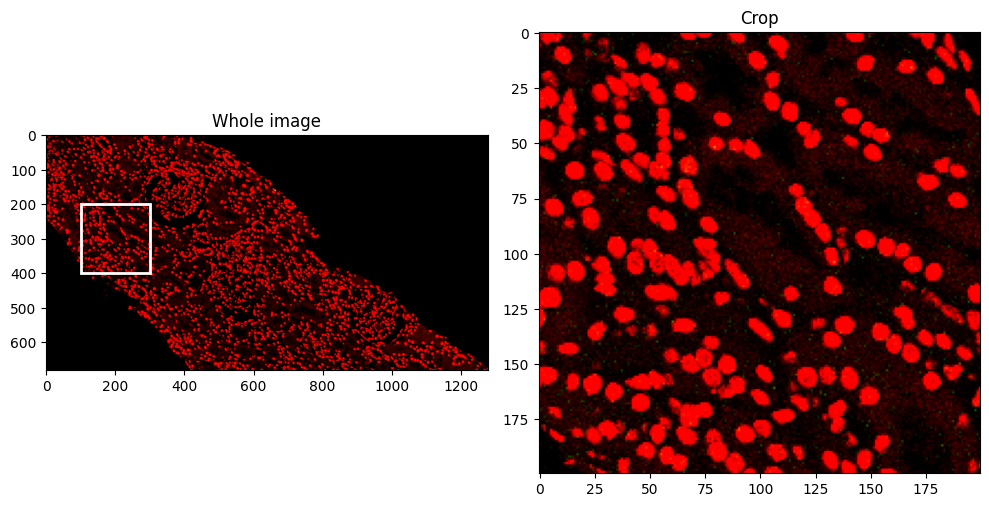

In [ ]:

if roi == 'r':
    list_roi = os.listdir(path_img_raw)
    name_roi= list_roi[np.random.randint(len(list_roi))]

img_dna = np.arcsinh(plt.imread(path_img_raw + name_roi + "/DNA.png")*5)

img_tot = np.zeros((img_dna.shape[0], img_dna.shape[1], 3))
img_tot[:, :, 0] = img_dna

for marker in list_marker:
  img_marker = np.arcsinh(plt.imread(path_img_raw + name_roi + "/" + marker + ".png") * 20)
  img_tot[:, :, 1] += img_marker

# zone sélectionnée
crop = img_tot[y:y+d, x:x+d]

# affichage avec un carré blanc entourant la zone
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(img_tot)
# (x, y) = coin supérieur gauche ; largeur=hauteur=d
ax1.add_patch(Rectangle((x, y), d, d, linewidth=2, edgecolor='white', facecolor='none'))
ax1.set_title("Whole image")

ax2.imshow(crop)
ax2.set_title("Crop")

plt.tight_layout()
# Normalize the crop to 0-255 range and convert to uint8 before saving
im = Image.fromarray(normalize_255(crop).astype(np.uint8))
im.save(path_crop+name_roi+"_"+str(x)+"_"+str(y)+"_"+str(d)+".png")
print("✅ Crop available there: "+path_crop+name_roi+"_"+str(x)+"_"+str(y)+"_"+str(d)+".png")
plt.show()

## Segmentation of the crop

### Mesmer


In [ ]:
path_mask_crop_mesmer=path_mask_crop+"mesmer/"
path_mask_crop_geojson=path_eval_quali_with_truth+"geojson/"
if os.path.isdir(path_mask_crop_mesmer)==False:
    os.mkdir(path_mask_crop_mesmer)
    print("✅ Folder for mesmer masks created")
if os.path.isdir(path_mask_crop_geojson)==False:
    os.mkdir(path_mask_crop_geojson)
    print("✅ Folder for geojson masks created")

##### Function

In [ ]:
# Étape 1 : Installer micromamba (mini version d'Anaconda compatible Colab)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
!mkdir -p /root/micromamba/envs

# Étape 2 : Créer un environnement Python 3.9 avec micromamba
!./bin/micromamba create -y -p /root/micromamba/envs/deepcell-env python=3.9

# Étape 3 : Activer l'environnement et installer DeepCell + dépendances
!./bin/micromamba run -p /root/micromamba/envs/deepcell-env pip install deepcell==0.12.6 scikit-image matplotlib

# Étape 4 : Démarrer Python dans ce nouvel environnement
import os
from IPython.display import clear_output

os.environ['PYTHONPATH'] = "/root/micromamba/envs/deepcell-env/lib/python3.9/site-packages"
os.environ['PATH'] = "/root/micromamba/envs/deepcell-env/bin:" + os.environ['PATH']
clear_output()
print("✅ Environnement Python 3.9 avec DeepCell prêt dans Colab")


✅ Environnement Python 3.9 avec DeepCell prêt dans Colab


##### Segmentation

In [ ]:
resolution=float(input("Enter the resolution (1.5 micrometer per pixel by default): "))

Enter the resolution (1.5 micrometer per pixel by default): 1.5


In [ ]:
code = f"""
from deepcell.applications import Mesmer
from tifffile import imsave
from PIL import Image
import numpy as np
import os
import traceback

project = "rejection"
path = "{path}"
path_crop = "{path_crop}"
path_mask_crop_mesmer = "{path_mask_crop_mesmer}"
path_mask_crop_geojson = "{path_mask_crop_geojson}"


try:
    app = Mesmer()
    print("🧠 Modèle Mesmer chargé avec succès.")
except Exception as e:
    raise RuntimeError("❌ Échec du chargement de Mesmer : " + str(e))

for i,crop in enumerate(os.listdir(path_crop)):
   img = np.array(Image.open(path_crop+crop))
   crop2=img[:,:,:2]
   crop2= np.expand_dims(crop2, axis=0)
   predictions = app.predict(crop2, image_mpp={resolution})
   mask=predictions[0,:,:,0]
   im = Image.fromarray(mask)
   im.save(path_mask_crop_mesmer+"/"+crop[:-4]+".tif")
   print("✅ Done :",crop)


"""


In [ ]:
with open("run_mesmer.py", "w") as f:
    f.write(code)

# Exécution
!./bin/micromamba run -p /root/micromamba/envs/deepcell-env python run_mesmer.py


2025-12-02 15:28:00.016681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/micromamba/envs/deepcell-env/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/lib/python3.12/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-12-02 15:28:00.016717: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-12-02 15:28:03.513636: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/micromamba/envs/deepcell-env/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/lib/python3.12/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2025-12-02 15:28:03.513766: W tensorflow

##### Geojson file
Creation of the geojson files from the maks made by Mesmer to load it in QuPath and manually correct them

In [ ]:
for mask_file in os.listdir(path_mask_crop_mesmer):
   # Load the mask image into a NumPy array
   mask = np.array(Image.open(os.path.join(path_mask_crop_mesmer, mask_file)))
   features = labels_to_features(mask, object_type="annotation")
   geojson = json.dumps(features)
   with open(path_mask_crop_geojson+mask_file[:-4]+".geojson","w") as f:
    dump(features, f)

### Cellpose


In [ ]:
path_mask_crop_cellpose=path_mask_crop+"cellposev3/"
if os.path.isdir(path_mask_crop_cellpose)==False:
    os.mkdir(path_mask_crop_cellpose)
    print("✅ Folder for cellpose masks created")

##### Functions

In [ ]:
%pip install cellpose
from cellpose import core, utils, io, models, metrics
model = models.CellposeModel(gpu=True, model_type="cyto3")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 93.0 MB/s eta 0:00:00


100%|██████████| 1.15G/1.15G [00:03<00:00, 332MB/s]


##### Segmentation

In [ ]:
for i,crop in enumerate(os.listdir(path_crop)):
  print(crop)
  img= np.array(Image.open(path_crop+"/"+crop))
  masks_pred, flows, styles = model.eval(img, channels=[2,1],niter=2000) # using more iterations for bacteria
  im = Image.fromarray(masks_pred)
  im.save(path_mask_crop_cellpose+crop[:-4]+".tif")

21U01570 c_100_200_200.png


21U01570 g_100_200_200.png


21U01570 a_100_200_200.png


21U01570 f_100_200_200.png


19U08731 d_100_200_200.png


## InstanSeg

In [ ]:
path_mask_crop_instanseg=path_mask_crop+"instanseg/"
if os.path.isdir(path_mask_crop_instanseg)==False:
    os.mkdir(path_mask_crop_instanseg)
    print("✅ Folder for Instanseg masks created")

#### Installation of Instanseg
(May takes few minutes)

In [ ]:
# === Cellule 1 : installation de l'environnement InstanSeg ===

# 1) Installer micromamba (mini-conda)
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
!mkdir -p /root/micromamba/envs

# 2) Créer un environnement Python 3.11 pour InstanSeg
!./bin/micromamba create -y -p /root/micromamba/envs/instanseg-env python=3.11

# 3) Installer InstanSeg + dépendances dans cet environnement
!./bin/micromamba run -p /root/micromamba/envs/instanseg-env pip install -q \
    "instanseg-torch[full]" "matplotlib<3.9"


bin/micromamba
[+] 0.0s
[+] 0.1s
conda-forge/linux-64  ⣾  
conda-forge/noarch     1%[+] 0.2s
conda-forge/linux-64   9%
conda-forge/noarch    18%[+] 0.3s
conda-forge/linux-64  20%
conda-forge/noarch    41%[+] 0.4s
conda-forge/linux-64  31%
conda-forge/noarch    64%[+] 0.5s
conda-forge/linux-64  42%
conda-forge/noarch    87%[+] 0.6s
conda-forge/linux-64  48%
conda-forge/noarch   100%[+] 0.7s
conda-forge/linux-64  48%
conda-forge/noarch   100%conda-forge/noarch                                
[+] 0.8s
conda-forge/linux-64  60%[+] 0.9s
conda-forge/linux-64  83%[+] 1.0s
conda-forge/linux-64  94%[+] 1.1s
conda-forge/linux-64  94%[+] 1.2s
conda-forge/linux-64  94%[+] 1.3s
conda-forge/linux-64  94%[+] 1.4s
conda-forge/linux-64  94%[+] 1.5s
conda-forge/linux-64  94%[+] 1.6s
conda-forge/linux-64  94%[+] 1.7s
conda-forge/linux-64  94%[+] 1.8s
conda-forge/linux-64  94%[+] 1.9s
conda-forge/linux-64  94%[+] 2.0s
conda-forge/linux-64  94%conda-forge/linux-64                              


Transactio

In [ ]:
import os, subprocess, textwrap

env = os.environ.copy()
env["MPLBACKEND"] = "Agg"   # évite le backend Jupyter non supporté

code = """
import matplotlib
matplotlib.use('Agg')

import sys
print("Python utilisé :", sys.version)

from instanseg import InstanSeg
print("InstanSeg importé OK :", InstanSeg)
"""

subprocess.run(
    ["/root/micromamba/envs/instanseg-env/bin/python", "-c", code],
    check=True,
    env=env,
)


FileNotFoundError: [Errno 2] No such file or directory: '/root/micromamba/envs/instanseg-env/bin/python'

In [ ]:
!./bin/micromamba run -p /root/micromamba/envs/instanseg-env pip install requests


#### Segmentation

In [ ]:
import os, subprocess, textwrap
from pathlib import Path

image_dir = path_crop
output_dir = path_mask_crop_instanseg

print("Input folder:", image_dir)
print("Output folder (masks):", output_dir)
print("-" * 70)

env = os.environ.copy()
env["MPLBACKEND"] = "Agg"

code = textwrap.dedent(f"""
import matplotlib
matplotlib.use('Agg')

from instanseg import InstanSeg
from pathlib import Path
import numpy as np
import tifffile as tiff

img_dir = Path({image_dir!r})
out_dir = Path({output_dir!r})

print("Input folder:", img_dir)
print("Output folder:", out_dir)

if not img_dir.exists():
    raise SystemExit(f"Path {{img_dir}} does not exist")

if not img_dir.is_dir():
    raise SystemExit(f"Path {{img_dir}} is not a folder")

out_dir.mkdir(parents=True, exist_ok=True)

print("Loading InstanSeg model (fluorescence_nuclei_and_cells, reader=skimage.io)...")
model = InstanSeg(
    "fluorescence_nuclei_and_cells",
    image_reader="skimage.io",   # <--- CHANGED HERE
    verbosity=1
)

images = sorted(
    list(img_dir.glob("*.tif")) +
    list(img_dir.glob("*.tiff")) +
    list(img_dir.glob("*.png"))
)

print("Number of images found:", len(images))
if not images:
    raise SystemExit("No .tif/.tiff/.png images found in " + str(img_dir))

for img_path in images:
    print("\\nProcessing:", img_path.name)

    labeled_output = model.eval(
        image=str(img_path),
        save_output=False,
        save_overlay=False
    )

    mask = np.asarray(labeled_output)
    mask_path = out_dir / (img_path.stem + ".tif")

    tiff.imwrite(str(mask_path), mask)
    print("Saved mask:", mask_path)

print("Segmentation completed.")
""")

res = subprocess.run(
    ["/root/micromamba/envs/instanseg-env/bin/python", "-c", code],
    env=env,
    capture_output=True,
    text=True,
)

print("----- STDOUT -----")
print(res.stdout)
print("----- STDERR -----")
print(res.stderr)

if res.returncode != 0:
    raise RuntimeError(f"InstanSeg failed (code {res.returncode})")
else:
    print(DONE_ASCII)
    print(f"All outline images have been saved in:\n  {path_mask_crop_instanseg}")

Input folder: /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/Evaluation_segmentation/segmentation_quality/assessment_with_ground_truth/crop/
Output folder (masks): /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/Evaluation_segmentation/segmentation_quality/assessment_with_ground_truth/mask_crop/instanseg/
----------------------------------------------------------------------
----- STDOUT -----
Input folder: /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/Evaluation_segmentation/segmentation_quality/assessment_with_ground_truth/crop
Output folder: /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/Evaluation_segmentation/segmentation_quality/assessment_with_ground_truth/mask_crop/instanseg
Loading InstanSeg model (fluorescence_nuclei_and_cells, reader=skimage.io)...
Model fluorescence_nuclei_and_cells version 0.1.0 already downloaded in /root/micromamba/envs/

## outline

#### Function

In [ ]:
def outline(img,df,w=1,color=(255,255,255)):
    for i in df.index.to_list():
        img_outline=np.zeros((img.shape[0],img.shape[1]))
        list_pixel= df.loc[i,"coords"]
        for p in list_pixel:
            img_outline[p[0],p[1]]=1
        img_outline=np.uint8(img_outline)
        contours, hierarchy = cv2.findContours(img_outline, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, color, w)
    return img



In [ ]:
def mask_to_df(path_mask,min_size=0,max_size=10000000):
    #img= np.array(Image.open(path_img))
    mask= np.array(Image.open(path_mask))
    label=ski.measure.label(mask,connectivity=mask.ndim)
    df_mask=ski.measure.regionprops_table(label,intensity_image=mask,properties=["area","coords","equivalent_diameter_area","bbox","axis_major_length","axis_minor_length","centroid"])
    df_mask=pd.DataFrame(df_mask)
    df=df_mask[df_mask.loc[:,"area"]>min_size].copy()
    df=df[df.loc[:,"area"]<max_size].copy()
    return df

In [ ]:
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt

DONE_ASCII = r"""
 ____   ___  _   _  _____
|  _ \ / _ \| \ | || ____|
| | | | | | |  \| ||  _|
| |_| | |_| | |\  || |___
|____/ \___/|_| \_||_____|
"""

def display_outline_mask(path_img, path_mask, output_root):
    os.makedirs(output_root, exist_ok=True)

    algos = [a for a in os.listdir(path_mask)
             if os.path.isdir(os.path.join(path_mask, a))]

    total = sum(len(os.listdir(os.path.join(path_mask, algo))) for algo in algos)
    pbar = tqdm(total=total, desc="Outline masks", unit="img")

    for algo in algos:
        out_algo_dir = os.path.join(output_root, algo)
        os.makedirs(out_algo_dir, exist_ok=True)

        algo_mask_dir = os.path.join(path_mask, algo)
        for name_img in sorted(os.listdir(algo_mask_dir)):
            img_name = os.path.splitext(name_img)[0]

            img_dna_path = os.path.join(path_img, img_name + ".png")
            mask_path    = os.path.join(algo_mask_dir, name_img)

            if not os.path.isfile(img_dna_path):
                pbar.update(1)
                continue

            img_dna   = plt.imread(img_dna_path)
            df_mask   = mask_to_df(mask_path)
            img_outline = outline(img_dna, df_mask)

            # --- Normalisation pour imsave ---
            img_to_save = img_outline
            if np.issubdtype(img_to_save.dtype, np.floating):
                # Si les valeurs sont typiquement 0–255 -> ramener en 0–1
                if img_to_save.max() > 1.0 or img_to_save.min() < 0.0:
                    img_to_save = img_to_save.astype(np.float32)
                    img_to_save = np.clip(img_to_save, 0, 255) / 255.0

            out_path = os.path.join(out_algo_dir, img_name + ".png")
            plt.imsave(out_path, img_to_save)

            pbar.update(1)

    pbar.close()
    print(DONE_ASCII)
    print(f"All outline images have been saved in:\n  {output_root}")


#### Execution

In [ ]:
display_outline_mask(path_crop,path_mask_crop,path_eval_mask_outline)


Outline masks: 100%|██████████| 17/17 [00:02<00:00,  7.25img/s]


 ____   ___  _   _  _____ 
|  _ \ / _ \| \ | || ____|
| | | | | | |  \| ||  _|  
| |_| | |_| | |\  || |___ 
|____/ \___/|_| \_||_____|

All outline images have been saved in:
  /content/gdrive/MyDrive/these/pipeline/rejection/segmentation/segmentation_cells/Evaluation_segmentation/segmentation_quality/assessment_with_ground_truth/mask_outline/


## Average precision and other metrics

### Functions

In [ ]:
def mask_to_df(path_mask,min_size=0,max_size=10000000):
    #img= np.array(Image.open(path_img))
    mask= np.array(Image.open(path_mask))
    label=ski.measure.label(mask,connectivity=mask.ndim)
    df_mask=ski.measure.regionprops_table(label,intensity_image=mask,properties=["area","coords","equivalent_diameter_area","bbox","axis_major_length","axis_minor_length","centroid"])
    df_mask=pd.DataFrame(df_mask)
    df=df_mask[df_mask.loc[:,"area"]>min_size].copy()
    df=df[df.loc[:,"area"]<max_size].copy()
    return df

In [ ]:
import os
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def distribution_number_object(
    path_img="./img",
    path_mask="./mask",
    path_file="./segmentation_quality/",
    dico_algo_min={},
    dico_algo_max={},
    title=""
):

    # ----------------------------------------------------------------------
    # Disable warnings (clean output)
    # ----------------------------------------------------------------------
    warnings.filterwarnings("ignore")

    # ----------------------------------------------------------------------
    # Setup
    # ----------------------------------------------------------------------
    os.makedirs(path_file, exist_ok=True)

    algos = sorted([d.name for d in os.scandir(path_mask) if d.is_dir()])
    if not algos:
        raise RuntimeError(f"No algorithm subfolders found in '{path_mask}'.")

    # Compute common filenames to evaluate per algorithm
    file_sets = []
    for algo in algos:
        algo_dir = Path(path_mask) / algo
        files = {f.name for f in algo_dir.iterdir() if f.is_file()}
        file_sets.append(files)

    if file_sets:
        common_files = sorted(set.intersection(*file_sets))
    else:
        common_files = []

    if not common_files:  # fallback
        first_dir = Path(path_mask) / algos[0]
        common_files = sorted([f.name for f in first_dir.iterdir() if f.is_file()])

    if not common_files:
        raise RuntimeError("No images found in mask folders.")

    # Init result dict
    dico_algo_nb = {algo: [] for algo in algos}

    # ----------------------------------------------------------------------
    # Single progress bar over all (algo, image) pairs
    # ----------------------------------------------------------------------
    total_steps = len(algos) * len(common_files)
    pbar = tqdm(total=total_steps, desc="Counting objects", unit="img", ncols=100)

    for algo in algos:
        algo_dir = Path(path_mask) / algo

        min_size = dico_algo_min.get(algo, 0)
        max_size = dico_algo_max.get(algo, 1_000_000_00)

        for filename in common_files:
            mask_path = algo_dir / filename

            # Use thresholds only if truth not involved
            if algo != "truth" and (dico_algo_min and dico_algo_max):
                df = mask_to_df(mask_path, min_size, max_size)
            else:
                df = mask_to_df(mask_path)

            dico_algo_nb[algo].append(df.shape[0])

            pbar.update(1)

    pbar.close()

    # ----------------------------------------------------------------------
    # Plot 1: Grouped bar chart
    # ----------------------------------------------------------------------
    n_algos = len(algos)
    n_imgs = len(common_files)

    width = 0.8 / n_algos
    x_base = np.arange(n_imgs)

    plt.figure(figsize=(max(12, n_imgs * 0.5), 8))

    for i, algo in enumerate(algos):
        x_positions = x_base + i * width
        plt.bar(x_positions, dico_algo_nb[algo], label=algo, width=width)

    tick_positions = x_base + width * (n_algos - 1) / 2

    plt.title(title, fontsize=20)
    plt.ylabel("Number of objects", fontsize=16)
    plt.xlabel("Images", fontsize=16)
    plt.xticks(tick_positions, common_files, rotation=60, ha="right")
    plt.legend(fontsize=12)
    plt.tight_layout()

    bar_out = Path(path_file) / (title if title else "number_of_objects.png")
    plt.savefig(bar_out, dpi=200)
    plt.close()

    # ----------------------------------------------------------------------
    # Plot 2: Box + swarm distribution
    # ----------------------------------------------------------------------
    rows = []
    for algo in algos:
        for count in dico_algo_nb[algo]:
            rows.append({"Algorithm": algo, "Objects": count})

    df_plot = pd.DataFrame(rows)

    tab20_distinct = [
        "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
        "#17BECF", "#BCBD22", "#E377C2", "#7F7F7F", "#8C564B"
    ]

    plt.figure(figsize=(max(12, n_algos * 2), 6))
    sns.swarmplot(data=df_plot, x="Algorithm", y="Objects", color="black", size=3)
    sns.boxplot(data=df_plot, x="Algorithm", y="Objects", showmeans=True, palette=tab20_distinct)

    plt.title("Average " + title, fontsize=14)
    plt.ylabel("Number of objects", fontsize=12)
    plt.xlabel("Algorithm", fontsize=12)
    plt.tight_layout()

    box_out = Path(path_file) / f"mean_{title if title else 'number_of_objects'}.png"
    plt.savefig(box_out, dpi=200)
    plt.close()

    print(f"✅ Files created in: {path_file}")


In [ ]:
import os
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.patches import Patch

def size_distribution(
    path_mask: str = "./mask",
    path_file: str = "./segmentation_quality",
    dico_algo_min: dict = {},
    dico_algo_max: dict = {},
    title: str = "size_distribution.png"
):

    # ----------------------- Clean terminal output -----------------------
    warnings.filterwarnings("ignore")               # Remove all warnings
    os.makedirs(path_file, exist_ok=True)

    # ----------------------- Scan algorithm subfolders -------------------
    algos = sorted([
        d for d in os.listdir(path_mask)
        if os.path.isdir(os.path.join(path_mask, d))
    ])
    if not algos:
        raise RuntimeError(f"No algorithm subfolders found in '{path_mask}'")

    # Prepare dict for all object areas
    dico_algo_size = {algo: [] for algo in algos}

    # ----------------------- Count total steps for single tqdm -----------
    total_images = 0
    for algo in algos:
        algo_dir = Path(path_mask) / algo
        total_images += len([f for f in algo_dir.iterdir() if f.is_file()])

    # Global_PROGRESS_BAR
    pbar = tqdm(total=total_images, desc="Size object distribution", unit="img", ncols=100)

    # ----------------------- MAIN LOOP (ONE tqdm ONLY) -------------------
    for algo in algos:
        algo_dir = Path(path_mask) / algo
        files = sorted([f.name for f in algo_dir.iterdir() if f.is_file()])

        min_size = dico_algo_min.get(algo, None)
        max_size = dico_algo_max.get(algo, None)

        for fname in files:
            mask_path = algo_dir / fname

            # Threshold logic unchanged
            if min_size is not None and max_size is not None and algo != "truth":
                df_mask = mask_to_df(mask_path, min_size, max_size)
            else:
                df_mask = mask_to_df(mask_path)

            # Extract areas
            if "area" in df_mask.columns:
                dico_algo_size[algo].extend(df_mask["area"].values.tolist())

            pbar.update(1)

    pbar.close()

    # ----------------------- Build DataFrame ------------------------------
    df_plot = pd.DataFrame(
        [(algo, area) for algo, areas in dico_algo_size.items() for area in areas],
        columns=["Algorithm", "Area"]
    )
    if df_plot.empty:
        raise RuntimeError("No areas found. Check input masks or mask_to_df output.")

    # ----------------------- Choose a palette-------------------------------
    tab20_distinct = [
        "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
        "#17BECF", "#BCBD22", "#E377C2", "#7F7F7F", "#8C564B",
    ]
    if len(algos) <= 20:
        palette = tab20_distinct[:len(algos)]
    else:
        palette = sns.color_palette("husl", n_colors=len(algos))

    algo_to_color = {algo: palette[i] for i, algo in enumerate(algos)}

    # ----------------------- Plot histogram -------------------------------
    plt.figure(figsize=(20, 12))
    ax = plt.gca()
    ax.set_title("Mask object size distribution", fontsize=24)
    ax.set_xlabel("Size (pixels)", fontsize=18)
    ax.set_ylabel("Number of objects", fontsize=18)

    # Overlaid histograms
    for algo in algos:
        areas = dico_algo_size[algo]
        if len(areas) == 0:
            continue

        sns.histplot(
            areas,
            kde=True,
            element="step",
            stat="count",
            common_norm=False,
            bins="auto",
            ax=ax,
            color=algo_to_color[algo],
            label=algo
        )

    # Legend
    handles = [
        Patch(facecolor=algo_to_color[a], edgecolor="black", label=a)
        for a in algos
    ]

    if len(algos) > 10:
        ax.legend(handles=handles, title="Algorithms", loc="upper left",
                  bbox_to_anchor=(1.02, 1), fontsize=12, ncol=2)
        plt.tight_layout(rect=[0, 0, 0.75, 1])
    else:
        ax.legend(handles=handles, title="Algorithms", loc="upper right", fontsize=12)
        plt.tight_layout()

    # Save
    out_path = os.path.join(path_file, title)
    plt.savefig(out_path, dpi=200)
    plt.close()

    print(f"✅ Size distribution saved to: {out_path}")

    return dico_algo_size


In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm


def calcul_auc(path_img, path_mask, path_file, title,
               dict_min_size=None, dict_max_size=None):
    """
    Compute Average Precision (AP) per algorithm across IoU thresholds,
    and save a precision-vs-IoU plot.
    """

    path_img = Path(path_img)
    path_mask = Path(path_mask)
    path_file = Path(path_file)

    path_file.mkdir(parents=True, exist_ok=True)

    if dict_min_size is None:
        dict_min_size = {}
    if dict_max_size is None:
        dict_max_size = {}

    # IoU thresholds (x-axis)
    iou_thresholds = np.arange(0.0, 1.0, 0.1)  # [0.0, 0.1, ..., 0.9]

    plt.figure(figsize=(20, 12))
    plt.title("Average precision", fontsize=40)

    dict_algo_ap = {}

    # List algorithms (subfolders) except "truth"
    algo_dirs = [
        d for d in sorted(path_mask.iterdir())
        if d.is_dir() and d.name != "truth"
    ]
    truth_dir = path_mask / "truth"

    # --------- Pré-calcul : fichiers communs + total pour tqdm ---------
    algo_to_common_files = {}
    total_images = 0

    truth_files = {f.name for f in truth_dir.iterdir() if f.is_file()}

    for algo_dir in algo_dirs:
        algo = algo_dir.name
        algo_files = {f.name for f in algo_dir.iterdir() if f.is_file()}
        common_files = sorted(algo_files & truth_files)

        if not common_files:
            print(f"⚠️  No common files for algorithm '{algo}'. Skipping.")
        else:
            algo_to_common_files[algo] = common_files
            total_images += len(common_files)

    if total_images == 0:
        print("⚠️  No common images found for any algorithm. Nothing to do.")
        return dict_algo_ap

    # --------- Boucle principale avec barre de progression ---------
    with tqdm(total=total_images, desc="Computing Average Precision", unit="img", ncols=100) as pbar:
        for idx_algo, algo_dir in enumerate(algo_dirs):
            algo = algo_dir.name

            # Algorithme sans fichiers communs → déjà signalé, on passe
            if algo not in algo_to_common_files:
                continue

            common_files = algo_to_common_files[algo]

            min_size = int(dict_min_size.get(algo, 0))
            max_size = int(dict_max_size.get(algo, 100000000))

            precision_sum = np.zeros_like(iou_thresholds, dtype=float)
            recall_sum = np.zeros_like(iou_thresholds, dtype=float)
            count_per_thresh = np.zeros_like(iou_thresholds, dtype=int)

            for fname in common_files:
                algo_path = str(path_mask / algo / fname)
                img_path = str(path_img / (fname[:-4] + ".png"))
                truth_path = str(truth_dir / fname)

                iou, dico_objet, df_mask, df_truth = calcul_iou(
                    img_path,
                    algo_path,
                    truth_path,
                    min_size,
                    max_size
                )

                for i, thr in enumerate(iou_thresholds):
                    recall, precision, tp, fp, fn = recall_precision(
                        thr, df_mask, df_truth
                    )
                    precision_sum[i] += precision
                    recall_sum[i] += recall
                    count_per_thresh[i] += 1

                pbar.update(1)

            valid = count_per_thresh > 0
            mean_precision = np.zeros_like(precision_sum)
            mean_recall = np.zeros_like(recall_sum)

            mean_precision[valid] = precision_sum[valid] / count_per_thresh[valid]
            mean_recall[valid] = recall_sum[valid] / count_per_thresh[valid]

            ap = float(np.round(metrics.auc(iou_thresholds, mean_precision), 2))
            dict_algo_ap[algo] = ap

            plt.plot(iou_thresholds, mean_precision, label=algo)
            plt.text(
                0.05,
                0.05 + idx_algo / 20.0,
                f"Algorithm: {algo}  Average precision = {ap:.2f}",
                fontsize=14,
            )

    plt.xlabel("IoU threshold", fontsize=20)
    plt.ylabel("Precision", fontsize=20)
    plt.ylim(0, 1.05)
    plt.xlim(0, 1.0)
    plt.legend(fontsize=20)
    plt.grid(True, alpha=0.3)

    out_path = path_file / f"{title}.png"
    plt.savefig(out_path, bbox_inches="tight")
    plt.close()

    print(f"✅ AUC plot saved to: {out_path}")
    return dict_algo_ap


In [ ]:
def calcul_iou(path_img,path_mask,path_truth,min_size=0,max_size=10000000):
    df_mask=mask_to_df(path_mask,min_size,max_size)
    df_truth=mask_to_df(path_truth)
    dico_objet,df_mask,df_truth,iou=iou_mean(df_truth,df_mask)
    return iou,dico_objet,df_mask,df_truth

In [ ]:
def recall_precision(thresh,df_mask,df_truth):
    list_true_pos=[i for i in df_mask.loc[:,"iou"] if i>thresh]
    list_false_pos=[i for i in df_mask.loc[:,"iou"] if i<thresh]
    list_false_neg=[i for i in df_truth.loc[:,"iou"] if i<thresh]

    recall=np.around(len(list_true_pos)/df_truth.shape[0],2)
    precision=np.around(len(list_true_pos)/(len(list_true_pos)+len(list_false_pos)),2)

    return recall,precision,len(list_true_pos),len(list_false_pos),len(list_false_neg)

In [ ]:
# make a plot of the mean iou according the maximum size in the predicted mask
def calcul_max_size(path_img,path_mask,path_file,step=0):
    dico_algo_size_iou={}
    for algo in os.listdir(path_mask):
        if algo!="truth":
            dico_algo_size_iou[algo]={}
            for file in os.listdir(path_mask+"/"+algo):
                df_truth=mask_to_df(path_mask+"/truth/"+file,0)
                df_mask=mask_to_df(path_mask+"/"+algo+"/"+file,0)
                if step==0:
                    step=np.max(df_mask["area"])//10
                for size in range(0,int(max(df_mask["area"])),int(step)):
                    if size not in dico_algo_size_iou.keys():
                        dico_algo_size_iou[algo][size]=[]
                    df=df_mask[df_mask.loc[:,"area"]<size].copy()
                    dico_objet,df,df_truth,iou=iou_mean(df_truth,df)
                    dico_algo_size_iou[algo][size].append(iou)
    dico_algo_mean={}
    for k in dico_algo_size_iou.keys():
        dico_algo_mean[k]=[]
        for k2 in dico_algo_size_iou[k].keys():
            dico_algo_mean[k].append(np.mean(dico_algo_size_iou[k][k2]))
    dico_algo_best={}
    for k in dico_algo_size_iou.keys():
        dico_algo_best[k]=list(dico_algo_size_iou[k].keys())[np.argmax(dico_algo_mean[k])]
    plt.figure()
    plt.title("IOU according to the maximum size of an object in the predicted mask")
    plt.ylim(0)
    plt.xlabel("Size in pixel")
    plt.ylabel("IOU")
    for n,k in enumerate(dico_algo_size_iou.keys()):
        plt.plot(list(dico_algo_size_iou[k].keys()),dico_algo_mean[k],label=k)
        plt.text(0,0.95-(n/20),"Algo: "+str(k)+" Best Iou: "+str(np.max(dico_algo_mean[k]))+" for a size of: "+str(list(dico_algo_size_iou[k].keys())[np.argmax(dico_algo_mean[k])])+" µm²")

    plt.legend(loc='upper right')
    plt.savefig(path_file+"IOU_max_size.png")
    return dico_algo_best

def calcul_min_size(path_img,path_mask,path_file,step=100):
    dico_algo_size_iou={}
    for algo in os.listdir(path_mask):
        if algo!="truth":
            dico_algo_size_iou[algo]={}
            for file in os.listdir(path_mask+"/"+algo):
                df_truth=mask_to_df(path_mask+"/truth/"+file,0)
                df_mask=mask_to_df(path_mask+"/"+algo+"/"+file,0)
                if step==0:
                    step=np.max(df_mask["area"])//10
                for size in range(0,int(max(df_truth["area"])//2),int(step)):
                    if size not in dico_algo_size_iou.keys():
                        dico_algo_size_iou[algo][size]=[]
                    df=df_mask[df_mask.loc[:,"area"]>size].copy()
                    dico_objet,df,df_truth,iou=iou_mean(df_truth,df)
                    dico_algo_size_iou[algo][size].append(iou)
    dico_algo_mean={}
    for k in dico_algo_size_iou.keys():
        dico_algo_mean[k]=[]
        for k2 in dico_algo_size_iou[k].keys():
            dico_algo_mean[k].append(np.mean(dico_algo_size_iou[k][k2]))
    dico_algo_best={}
    for k in dico_algo_size_iou.keys():
        dico_algo_best[k]=list(dico_algo_size_iou[k].keys())[np.argmax(dico_algo_mean[k])]
    plt.figure()
    plt.title("IOU according to the minimum size of an object in the predicted mask")
    plt.ylim(0)
    plt.xlabel("Size (µm²)")
    plt.ylabel("IOU")
    for n,k in enumerate(dico_algo_size_iou.keys()):
        plt.plot(list(dico_algo_size_iou[k].keys()),dico_algo_mean[k],label=k)
        plt.text(0.1,0.95-(n/20),"Algo: "+str(k)+" Best Iou: "+str(np.max(dico_algo_mean[k]))+" for a size of: "+str(list(dico_algo_size_iou[k].keys())[np.argmax(dico_algo_mean[k])])+" µm²")
    plt.legend()
    plt.savefig(path_file+"IOU_min_size.png")
    return dico_algo_best

In [ ]:
def outline_iou(path_img,path_file,name,algo,df_truth,df_mask,threshold=0.5):
    if os.path.isdir(path_file+"outline_iou")==False:
        os.mkdir(path_file+"outline_iou")
    if os.path.isdir(path_file+"outline_iou/"+algo)==False:
        os.mkdir(path_file+"outline_iou/"+algo)
    crop= np.array(Image.open(path_img))
    if len(crop.shape)==2:
        crop=cv2.cvtColor(crop,cv2.COLOR_GRAY2RGB)
    for i in df_mask.index.to_list():
        img=np.zeros((crop.shape[0],crop.shape[1]))
        if df_mask.loc[i,"iou"]>threshold:
            color=(0,255,0)
        else:
            color=(0,0,255)
        list_pixel= df_mask.loc[i,"coords"]
        for p in list_pixel:
            img[p[0],p[1]]=1
        img=np.uint8(img)
        contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(crop, contours, -1, color, 1)
    for i in df_truth.index.to_list():
        img=np.zeros((crop.shape[0],crop.shape[1]))
        list_pixel= df_truth.loc[i,"coords"]
        for p in list_pixel:
            img[p[0],p[1]]=1
        img=np.uint8(img)
        contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(crop, contours, -1, (255,0,0), 1)

    cv2.imwrite(path_file+"outline_iou/"+algo+"/"+name[:-4]+".png",normalize_255(crop))
    return crop


In [ ]:
# Create an image with the predicted mask in different colors and the outline of the ground truth
def outline_mask_color(path_img,path_mask,path_file,algo,threshold,dico_algo_min,dico_algo_max):
    if os.path.isdir(path_file+"outline_color")==False:
        os.mkdir(path_file+"outline_color")
    if os.path.isdir(path_file+"outline_color/"+algo)==False:
        os.mkdir(path_file+"outline_color/"+algo)

    for file_mask in os.listdir(path_mask+"/"+algo):
        img= np.array(Image.open(path_img+"/"+file_mask[:-4]+".png"))
        crop_iou=np.zeros((img.shape[0],img.shape[1],3))
        iou,dico_objet,df_mask,df_truth=calcul_iou(path_img+"/"+file_mask,path_mask+"/"+algo+"/"+file_mask,path_mask+"/truth/"+file_mask,dico_algo_min[algo],dico_algo_max[algo])
        for i in df_mask.index:
            iou_cell=df_mask.loc[i,'iou']
            if iou_cell>threshold:
                color=(0,iou_cell,0)
            elif df_mask.loc[i,'iou']==0:
                color=(0,0,1)
            elif iou<threshold:
                color=(0,iou_cell,iou_cell)

            for p in df_mask.loc[i,"coords"]:
                crop_iou[p[0],p[1]]=color
        img=outline(normalize_255(crop_iou),df_truth,1,(255,255,255))
        cv2.imwrite(path_file+"outline_color/"+algo+"/"+file_mask[:-4]+".png",normalize_255(img))
        #plt.figure()
        #plt.imshow(img)
        #plt.axis('off')
        #plt.savefig(path_file+"outline_color/"+algo+"/"+file_mask[:-4]+".png",bbox_inches = 'tight', pad_inches = 0)

In [ ]:
def iou_mean(df_truth,df_mask):
  dico_objet={}
  list_iou=[]
  df_mask["iou"]=float(0)
  df_truth["iou"]=float(0)
  for i in df_mask.index.to_list():
    centre_mask=(df_mask.loc[i,"centroid-1"],df_mask.loc[i,"centroid-0"])
    diametre_mask=df_mask.loc[i,"equivalent_diameter_area"]+5
    list_cell_mask=[]
    for p in df_mask.loc[i,"coords"]:
          list_cell_mask.append(tuple(p))
    for j in df_truth.index.to_list():
     centre_truth=(df_truth.loc[j,"centroid-1"],df_truth.loc[j,"centroid-0"])
     diametre_truth=df_truth.loc[j,"equivalent_diameter_area"]+5
     distance=np.abs(centre_mask[0]-centre_truth[0])+np.abs(centre_mask[1]-centre_truth[1])
     if distance<diametre_mask/2 or distance<diametre_truth/2:
      list_cell_truth=[]
      for p in df_truth.loc[j,"coords"]:
          list_cell_truth.append(tuple(p))
      total_mask=len(list_cell_mask)
      total_truth=len(list_cell_truth)
      intersection= len(list(set(list_cell_truth).intersection(set(list_cell_mask))))
      if intersection>0:
          iou=intersection/(total_mask+total_truth-intersection)
          if iou>df_mask.loc[i,"iou"] and iou>df_truth.loc[j,"iou"]:
            list_iou.append(iou)
            df_mask.loc[i,"iou"]=iou
            df_truth.loc[j,"iou"]=iou
            dico_objet[(i,j)]=iou

  iou=np.around(np.sum(list_iou)/(df_truth.shape[0]+df_mask.shape[0]-len(list_iou)),2)
  return dico_objet,df_mask,df_truth,iou

In [ ]:
def outline(img,df,w=1,color=(255,255,255)):
    for i in df.index.to_list():
        img_outline=np.zeros((img.shape[0],img.shape[1]))
        list_pixel= df.loc[i,"coords"]
        for p in list_pixel:
            img_outline[p[0],p[1]]=1
        img_outline=np.uint8(img_outline)
        contours, hierarchy = cv2.findContours(img_outline, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, color, w)
    return img

In [ ]:
import os
from pathlib import Path
from contextlib import redirect_stdout
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed


def main_evaluation_fast(
    path_crop,
    path_mask_crop,
    path_eval_quali_truth,
    path_eval_with_truth,
    threshold: float = 0.5,
    step: int = 10,
):

    path_img = Path(path_crop)
    path_mask = Path(path_mask_crop)
    out_path = Path(path_eval_quali_truth)
    out_path.mkdir(parents=True, exist_ok=True)

    summarize_path = out_path / "summarize.txt"

    with open(summarize_path, "w") as f, redirect_stdout(f):

        algos = sorted(
            d.name for d in path_mask.iterdir()
            if d.is_dir() and d.name != "truth"
        )

        print(f"Image path: {path_img}")
        print(f"Mask path:  {path_mask}")
        print(f"Output path: {out_path}")
        print(f"IoU threshold: {threshold}")
        print(f"Step for size optimization: {step}")
        print("\n" + "=" * 80 + "\n")

        # 1. Distributions sans filtre
        size_distribution(
            path_mask=str(path_mask),
            title="size_distribution.png",
            path_file=str(out_path),
        )
        distribution_number_object(
            path_img=str(path_img),
            path_mask=str(path_mask),
            title="number_objects.png",
            path_file=str(out_path),
        )

        # 2. AUC sans filtre
        print("\n\nEvaluation of algorithms without size filter\n")
        dico_algo_ap = calcul_auc(
            str(path_img),
            str(path_mask),
            str(out_path),
            title="Average_precision_without_size_filter",
        )

        # 3. Métriques par algo (sans filtre) en parallèle
        results_no_filter = {}
        with ProcessPoolExecutor() as ex:
            futures = {
                ex.submit(
                    compute_metrics_for_algo,
                    algo,
                    str(path_img),
                    str(path_mask),
                    threshold,
                    None,
                    None,
                ): algo
                for algo in algos
            }
            for fut in as_completed(futures):
                res = fut.result()
                results_no_filter[res["algo"]] = res

        for algo in algos:
            res = results_no_filter.get(algo, None)
            if res is None or not res["iou"]:
                print(f"⚠️  No valid results for algo '{algo}' (no filter).")
                continue

            ious = np.array(res["iou"])
            recalls = np.array(res["recall"])
            precisions = np.array(res["precision"])
            tps = np.array(res["tp"])
            fps = np.array(res["fp"])
            fns = np.array(res["fn"])

            print("*" * 50)
            print(algo)
            print("*" * 50)
            print(f"Mean IoU = {ious.mean():.4f} (without size filter)")
            print(f"Average precision: {dico_algo_ap.get(algo, float('nan'))}")
            print("")
            print(f"Number of predicted objects: {tps.sum() + fps.sum()}")
            print(f"Real object number:         {tps.sum() + fns.sum()}")
            print("")
            print(f"For IoU threshold = {threshold}:")
            print(f"   Recall    = {recalls.mean():.4f}")
            print(f"   Precision = {precisions.mean():.4f}")
            print(f"   True positive  = {tps.sum()}")
            print(f"   False positive = {fps.sum()}")
            print(f"   False negative = {fns.sum()}")
            print("")

        # 4. Optimisation min / max size
        print("\n\nOptimizing object size ranges per algorithm...\n")
        dico_algo_max = calcul_max_size(
            str(path_img), str(path_mask), str(path_eval_quali_truth), step
        )
        dico_algo_min = calcul_min_size(
            str(path_img), str(path_mask), str(path_eval_quali_truth), step
        )

        # 5. AUC avec filtre
        dico_algo_ap_filtered = calcul_auc(
            str(path_img),
            str(path_mask),
            str(out_path),
            title="Average_precision_with_size_filter",
            dict_min_size=dico_algo_min,
            dict_max_size=dico_algo_max,
        )

        # 6. Distributions avec filtre
        size_distribution(
            path_mask=str(path_mask),
            dico_algo_min=dico_algo_min,
            dico_algo_max=dico_algo_max,
            title="size_distribution_filtered.png",
            path_file=str(out_path),
        )
        distribution_number_object(
            path_img=str(path_img),
            path_mask=str(path_mask),
            path_file=str(out_path),
            dico_algo_max=dico_algo_max,
            dico_algo_min=dico_algo_min,
            title="number_objects_filtered.png",
        )

        print("\n\nEvaluation of the algorithms with a size filter\n")

        # 7. Métriques par algo (avec filtre) en parallèle
        results_filtered = {}
        with ProcessPoolExecutor() as ex:
            futures = {
                ex.submit(
                    compute_metrics_for_algo,
                    algo,
                    str(path_img),
                    str(path_mask),
                    threshold,
                    int(dico_algo_min[algo]),
                    int(dico_algo_max[algo]),
                ): algo
                for algo in algos
            }
            for fut in as_completed(futures):
                res = fut.result()
                results_filtered[res["algo"]] = res

        # 8. Affichage + éventuellement visuels (ici on fait visuels en séquentiel)
        for algo in algos:
            res = results_filtered.get(algo, None)
            if res is None or not res["iou"]:
                print(f"⚠️  No valid results for algo '{algo}' (with filter).")
                continue

            ious = np.array(res["iou"])
            recalls = np.array(res["recall"])
            precisions = np.array(res["precision"])
            tps = np.array(res["tp"])
            fps = np.array(res["fp"])
            fns = np.array(res["fn"])

            print("*" * 100)
            print(algo)
            print("*" * 100)
            print(
                f"Best IoU = {ious.mean():.4f} by filtering "
                f"objects < {dico_algo_min[algo]} px and > {dico_algo_max[algo]} px"
            )
            print(
                f"Average precision (with size filter): "
                f"{dico_algo_ap_filtered.get(algo, float('nan'))}"
            )
            print("")
            print(f"Number of predicted objects: {tps.sum() + fps.sum()}")
            print(f"Real object number:         {tps.sum() + fns.sum()}")
            print("")
            print(f"For IoU threshold = {threshold}:")
            print(f"   Recall       = {recalls.mean():.4f}")
            print(f"   Precision    = {precisions.mean():.4f}")
            print(f"   True positive  = {tps.sum()}")
            print(f"   False positive = {fps.sum()}")
            print(f"   False negative = {fns.sum()}")
            print("")

        print(f"\n✅ Evaluation finished. Summary written to: {summarize_path}")


In [ ]:
import os
import sys
from pathlib import Path
from contextlib import redirect_stdout

import numpy as np

# On suppose que ces fonctions existent déjà :
# - size_distribution
# - distribution_number_object
# - calcul_auc
# - calcul_iou
# - recall_precision
# - calcul_max_size
# - calcul_min_size
# - outline_iou
# - outline_mask_color


def _compute_metrics_for_algo(
    algo: str,
    path_img: Path,
    path_mask: Path,
    threshold: float,
    min_size: int | None = None,
    max_size: int | None = None,
    do_outlines: bool = False,
    path_eval_with_truth: Path | None = None,
):
    """
    Calcule les listes :
    - IoU,
    - recall,
    - precision,
    - true_pos, false_pos, false_neg
    pour un algorithme donné, avec ou sans filtre de taille.
    """

    list_iou = []
    list_recall = []
    list_precision = []
    list_true_pos = []
    list_false_pos = []
    list_false_neg = []

    algo_dir = path_mask / algo
    truth_dir = path_mask / "truth"

    # Fichiers communs -> robustesse (au lieu de zip(os.listdir(...)))
    algo_files = {f.name for f in algo_dir.iterdir() if f.is_file()}
    img_files = {f.name for f in path_img.iterdir() if f.is_file()}
    truth_files = {f.name for f in truth_dir.iterdir() if f.is_file()}

    common_files = sorted(algo_files & truth_files & img_files)
    if not common_files:
        print(f"⚠️  No common files for algorithm '{algo}'.")
        return (
            list_iou,
            list_recall,
            list_precision,
            list_true_pos,
            list_false_pos,
            list_false_neg,
        )

    for fname in common_files:
        img_path = path_img / (fname[:-4] + ".png")  # image PNG
        algo_mask_path = algo_dir / fname
        truth_mask_path = truth_dir / fname

        if min_size is None or max_size is None:
            iou, dico_objet, df_mask, df_truth = calcul_iou(
                str(img_path),
                str(algo_mask_path),
                str(truth_mask_path),
            )
        else:
            iou, dico_objet, df_mask, df_truth = calcul_iou(
                str(img_path),
                str(algo_mask_path),
                str(truth_mask_path),
                min_size,
                max_size,
            )

        list_iou.append(iou)
        recall, precision, true_pos, false_pos, false_neg = recall_precision(
            threshold, df_mask, df_truth
        )
        list_precision.append(precision)
        list_recall.append(recall)
        list_true_pos.append(true_pos)
        list_false_pos.append(false_pos)
        list_false_neg.append(false_neg)

        # Visualisations optionnelles
        if do_outlines and path_eval_with_truth is not None:
            outline_iou(
                str(path_img / (fname[:-4] + ".png")),
                str(path_eval_with_truth),
                fname,
                algo,
                df_truth,
                df_mask,
                threshold,
            )
            # selon ton implémentation, cette fonction traite souvent un set complet ;
            # si c'est le cas, la sortir de la boucle serait encore plus optimal.
            outline_mask_color(
                str(path_img),
                str(path_mask),
                str(path_eval_with_truth),
                algo,
                threshold,
                dico_algo_min={algo: min_size} if min_size is not None else {},
                dico_algo_max={algo: max_size} if max_size is not None else {},
            )

    return (
        list_iou,
        list_recall,
        list_precision,
        list_true_pos,
        list_false_pos,
        list_false_neg,
    )


def main_evaluation(
    path_crop,
    path_mask_crop,
    path_eval_quali_truth,
    path_eval_with_truth,
    threshold: float = 0.5,
    step: int = 10,
):

    path_img = Path(path_crop)
    path_mask = Path(path_mask_crop)
    out_path = Path(path_eval_quali_truth)

    out_path.mkdir(parents=True, exist_ok=True)

    summarize_path = out_path / "summarize.txt"
    with open(summarize_path, "w") as f, redirect_stdout(f):

        print(f"Image path: {path_img}")
        print(f"Mask path:  {path_mask}")
        print(f"Output path: {out_path}")
        print(f"IoU threshold for metrics: {threshold}")
        print(f"Step for size optimization: {step}")
        print("\n" + "=" * 80 + "\n")

        # ------------------------------------------------------------------
        # 1. Distributions sans filtre de taille
        # ------------------------------------------------------------------
        print("Size distribution (no size filter)")
        size_distribution(
            path_mask=str(path_mask),
            title="size_distribution.png",
            path_file=str(out_path),
        )

        print("\nNumber of objects per image (no size filter)")
        distribution_number_object(
            path_img=str(path_img),
            path_mask=str(path_mask),
            title="number_objects.png",
            path_file=str(out_path),
        )

        # ------------------------------------------------------------------
        # 2. IoU / AP sans filtre de taille
        # ------------------------------------------------------------------
        print("\n\nEvaluation of algorithms without size filter\n")

        dico_algo_ap = calcul_auc(
            str(path_img),
            str(path_mask),
            str(out_path),
            title="Average_precision_without_size_filter",
        )

        for algo in sorted(os.listdir(path_mask)):
            if algo == "truth":
                continue

            (
                list_iou,
                list_recall,
                list_precision,
                list_true_pos,
                list_false_pos,
                list_false_neg,
            ) = _compute_metrics_for_algo(
                algo=algo,
                path_img=path_img,
                path_mask=path_mask,
                threshold=threshold,
                min_size=None,
                max_size=None,
                do_outlines=False,
            )

            if not list_iou:
                continue

            print("*" * 50)
            print(algo)
            print("*" * 50)
            print(f"Mean IoU = {np.mean(list_iou):.4f} (without size filter)")
            print(f"Average precision: {dico_algo_ap.get(algo, float('nan'))}")
            print("")
            print(
                "Number of predicted objects: "
                f"{np.sum(list_true_pos) + np.sum(list_false_pos)}"
            )
            print(
                "Real object number: "
                f"{np.sum(list_true_pos) + np.sum(list_false_neg)}"
            )
            print("")
            print(f"For IoU threshold = {threshold} :")
            print(f"   Recall   = {np.mean(list_recall):.4f}")
            print(f"   Precision= {np.mean(list_precision):.4f}")
            print(f"   True positives = {np.sum(list_true_pos)}")
            print(f"   False positives= {np.sum(list_false_pos)}")
            print(f"   False negatives= {np.sum(list_false_neg)}")
            print("")

        # ------------------------------------------------------------------
        # 3. Calcul des min/max de taille par algo
        # ------------------------------------------------------------------
        print("\n\nOptimizing object size ranges per algorithm...\n")

        dico_algo_max = calcul_max_size(
            str(path_img), str(path_mask), str(path_eval_quali_truth), step
        )
        dico_algo_min = calcul_min_size(
            str(path_img), str(path_mask), str(path_eval_quali_truth), step
        )

        # ------------------------------------------------------------------
        # 4. AP avec filtre de taille
        # ------------------------------------------------------------------
        dico_algo_ap_filtered = calcul_auc(
            str(path_img),
            str(path_mask),
            str(out_path),
            title="Average_precision_with_size_filter",
            dict_min_size=dico_algo_min,
            dict_max_size=dico_algo_max,
        )

        # ------------------------------------------------------------------
        # 5. Distributions avec filtre de taille
        # ------------------------------------------------------------------
        print("\nSize distribution (with size filter)")
        size_distribution(
            path_mask=str(path_mask),
            dico_algo_min=dico_algo_min,
            dico_algo_max=dico_algo_max,
            title="size_distribution_filtered.png",
            path_file=str(out_path),
        )

        print("\nNumber of objects per image (with size filter)")
        distribution_number_object(
            path_img=str(path_img),
            path_mask=str(path_mask),
            path_file=str(out_path),
            dico_algo_max=dico_algo_max,
            dico_algo_min=dico_algo_min,
            title="number_objects_filtered.png",
        )

        # ------------------------------------------------------------------
        # 6. IoU / AP avec filtre de taille + visualisation
        # ------------------------------------------------------------------
        print("\n\nEvaluation of the algorithms with a size filter\n")

        for algo in sorted(os.listdir(path_mask)):
            if algo == "truth":
                continue

            print("*" * 100)
            print(algo)
            print("*" * 100)

            (
                list_iou,
                list_recall,
                list_precision,
                list_true_pos,
                list_false_pos,
                list_false_neg,
            ) = _compute_metrics_for_algo(
                algo=algo,
                path_img=path_img,
                path_mask=path_mask,
                threshold=threshold,
                min_size=dico_algo_min[algo],
                max_size=dico_algo_max[algo],
                do_outlines=True,
                path_eval_with_truth=Path(path_eval_with_truth),
            )

            if not list_iou:
                continue

            print(
                f"Algorithm: {algo}\n"
                f"Best IoU = {np.mean(list_iou):.4f} by filtering "
                f"objects < {dico_algo_min[algo]} px and > {dico_algo_max[algo]} px"
            )
            print(
                f"Average precision (with size filter): "
                f"{dico_algo_ap_filtered.get(algo, float('nan'))}"
            )
            print("")
            print(
                "Number of predicted objects: "
                f"{np.sum(list_true_pos) + np.sum(list_false_pos)}"
            )
            print(
                "Real object number: "
                f"{np.sum(list_true_pos) + np.sum(list_false_neg)}"
            )
            print("")
            print(f"For IoU threshold = {threshold} :")
            print(f"   Recall       = {np.around(np.mean(list_recall), 2)}")
            print(f"   Precision    = {np.around(np.mean(list_precision), 2)}")
            print(f"   True positive  = {np.sum(list_true_pos)}")
            print(f"   False positive = {np.sum(list_false_pos)}")
            print(f"   False negative = {np.sum(list_false_neg)}")
            print("")

    print(f"✅ Evaluation finished. Summary written to: {summarize_path}")


In [ ]:
from pathlib import Path
import numpy as np

def compute_metrics_for_algo(
    algo: str,
    path_img: str,
    path_mask: str,
    threshold: float,
    min_size: int | None = None,
    max_size: int | None = None,
):
    """
    Compute IoU, recall, precision, TP/FP/FN for one algorithm,
    with optional size filtering.
    Returns a dict with all lists.
    """
    path_img = Path(path_img)
    path_mask = Path(path_mask)
    algo_dir = path_mask / algo
    truth_dir = path_mask / "truth"

    list_iou = []
    list_recall = []
    list_precision = []
    list_true_pos = []
    list_false_pos = []
    list_false_neg = []

    algo_files = {f.name for f in algo_dir.iterdir() if f.is_file()}
    truth_files = {f.name for f in truth_dir.iterdir() if f.is_file()}
    img_files = {f.name for f in path_img.iterdir() if f.is_file()}

    common_files = sorted(algo_files & truth_files & img_files)
    if not common_files:
        return {
            "algo": algo,
            "iou": list_iou,
            "recall": list_recall,
            "precision": list_precision,
            "tp": list_true_pos,
            "fp": list_false_pos,
            "fn": list_false_neg,
        }

    for fname in common_files:
        img_path = path_img / (fname[:-4] + ".png")
        algo_mask_path = algo_dir / fname
        truth_mask_path = truth_dir / fname

        if min_size is None or max_size is None:
            iou, dico_objet, df_mask, df_truth = calcul_iou(
                str(img_path),
                str(algo_mask_path),
                str(truth_mask_path),
            )
        else:
            iou, dico_objet, df_mask, df_truth = calcul_iou(
                str(img_path),
                str(algo_mask_path),
                str(truth_mask_path),
                min_size,
                max_size,
            )

        list_iou.append(iou)
        recall, precision, tp, fp, fn = recall_precision(
            threshold, df_mask, df_truth
        )
        list_precision.append(precision)
        list_recall.append(recall)
        list_true_pos.append(tp)
        list_false_pos.append(fp)
        list_false_neg.append(fn)

    return {
        "algo": algo,
        "iou": list_iou,
        "recall": list_recall,
        "precision": list_precision,
        "tp": list_true_pos,
        "fp": list_false_pos,
        "fn": list_false_neg,
    }


### Execution

Counting objects: 100%|██████████████████████████████████████████████| 8/8 [00:00<00:00,  8.03img/s]


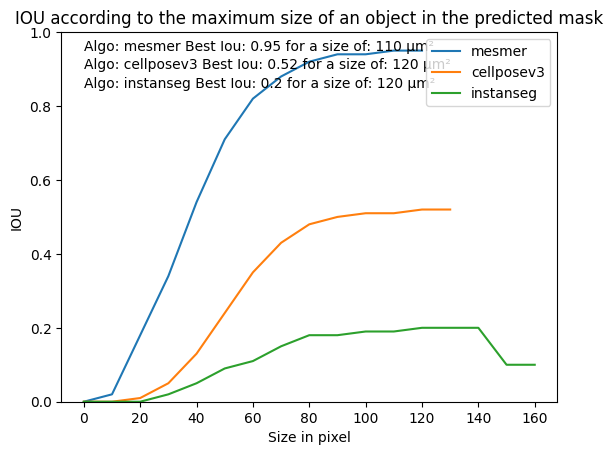

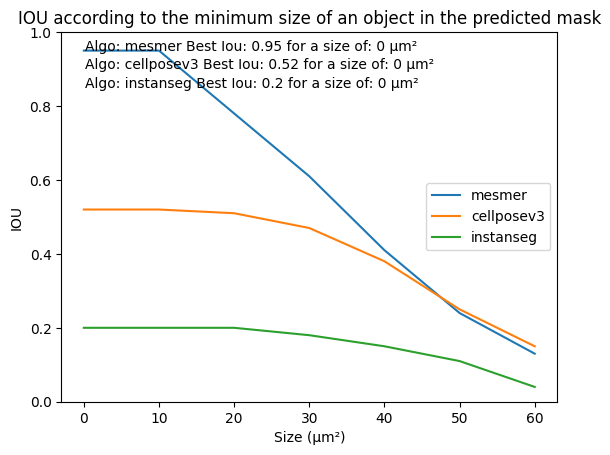

In [ ]:
main_evaluation_fast(
    path_crop=path_crop,
    path_mask_crop=path_mask_crop,
    path_eval_quali_truth=path_eval_quali_truth,
    path_eval_with_truth=path_eval_with_truth,
    threshold=0.5,
    step=10,
)
